In [1]:
# !pip install earthengine-api
# !pip install geemap
# !pip install pandas
# !pip install geopandas
# !pip install numpy
# !pip install scikit-learn
# !pip install xgboost
# !pip install joblib
# !pip install matplotlib
# !pip install folium
# !pip install branca
# !pip install osmnx
# !pip install shapely

# geemap.update_package()

**1. Installing libraries**

In [2]:
import os

# Google Earth Engine Libraries
import ee
import geemap

# For Data Preprocessing
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

import joblib

# For Analysis and Mapping
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import branca
import osmnx as ox
from shapely.geometry import Point

**2. Authenticate and initialize Earth Engine**

In [5]:
ee.Authenticate()

Enter verification code: 4/1AbUR2VNzUxyxYNLofcZRZQeDiIYb9IRNMfwohOPS6mMKM_CwcqNIJwASaQg

Successfully saved authorization token.


In [6]:
ee.Initialize()

**Creating Region Of Interest = USA, & map**

In [7]:
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017");
roi = countries.filter(ee.Filter.eq("country_na", "United States"))

Map = geemap.Map()

**Initializing dataset (landsat 8)**

In [ ]:
%time

# Applies scaling factors.
def applyScaleFactors(image):
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    LonLat = image.pixelLonLat()
    image = image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .addBands(LonLat) \
        .clip(roi) 
    return image

def addDate(image):
    time = image.metadata('system:time_start')
    return image.addBands(time.rename('time'))

bands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7',
    'longitude', 'latitude', 'time',
    'ST_B10'] # temperature of the atmosphere

bands_data = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10']
bands_comparison = ['longitude', 'latitude', 'time']

dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2021-01-01', '2022-01-01') \
    .map(applyScaleFactors) \
    .map(addDate) \
    .select(bands) \
    .mosaic()

visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

Map.centerObject(roi, 4)
Map.addLayer(dataset, visualization, 'Landsat 8')
usa_rectangle = ee.Geometry.Rectangle([-125, 24, -66, 50])
Map.addLayer(usa_rectangle)
Map

In [ ]:
data = dataset.select(bands_data)
comparison = dataset.select(bands_comparison)
print(f'data: {data.bandNames().getInfo()}')
print(f'comarison: {comparison.bandNames().getInfo()}')
print(f'dataset: {dataset.bandNames().getInfo()}')

**saving data**

In [13]:
%%time

# Function to split a list into smaller chunks
def split_list(input_list, chunk_size):
    return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

lon_values = np.arange(-125, -66, 0.1)
lat_values = np.arange(24, 50, 0.1)
lon_lat_points = []
for lon in lon_values:
    for lat in lat_values:
        lon_lat_points.append(ee.Geometry.Point(lon, lat))

# Split the grid points into smaller chunks
chunk_size = 1000
grid_chunks = split_list(lon_lat_points, chunk_size)

# Download data for each chunk
data_frames = []
for i, chunk in enumerate(grid_chunks):
    print(f"Processing chunk {i + 1}/{len(grid_chunks)}")
    chunk_fc = ee.FeatureCollection(chunk)
    data_out_csv = os.path.join(f'data/2021/chunks/Landsat8_chunk_{i}.csv')

#     geemap.extract_values_to_points(chunk_fc, dataset, data_out_csv, 30)
    get_data = pd.read_csv(data_out_csv)
    get_data.drop(get_data[get_data['SR_B1']==None].index, inplace=True)
    get_data.dropna()

    data_frames.append(get_data)

# Concatenate data from all chunks
df_Landsat = pd.concat(data_frames, ignore_index=True)
df_Landsat = df_Landsat.dropna()
df_Landsat.to_csv(f'data/2021/Landsat.csv')

Processing chunk 1/154
Processing chunk 2/154
Processing chunk 3/154
Processing chunk 4/154
Processing chunk 5/154
Processing chunk 6/154
Processing chunk 7/154
Processing chunk 8/154
Processing chunk 9/154
Processing chunk 10/154
Processing chunk 11/154
Processing chunk 12/154
Processing chunk 13/154
Processing chunk 14/154
Processing chunk 15/154
Processing chunk 16/154
Processing chunk 17/154
Processing chunk 18/154
Processing chunk 19/154
Processing chunk 20/154
Processing chunk 21/154
Processing chunk 22/154
Processing chunk 23/154
Processing chunk 24/154
Processing chunk 25/154
Processing chunk 26/154
Processing chunk 27/154
Processing chunk 28/154
Processing chunk 29/154
Processing chunk 30/154
Processing chunk 31/154
Processing chunk 32/154
Processing chunk 33/154
Processing chunk 34/154
Processing chunk 35/154
Processing chunk 36/154
Processing chunk 37/154
Processing chunk 38/154
Processing chunk 39/154
Processing chunk 40/154
Processing chunk 41/154
Processing chunk 42/154
P

In [14]:
df_epa = pd.read_csv('data/2021/hourly_81102_2021.csv')

**Evaluating the datetime column for both tables**

In [15]:
# converting date dd.mm.YY
def convertDate(value):
    time = datetime.datetime.fromtimestamp(value/1000.0)
    return time.strftime('%Y-%m-%d')
df_Landsat['date'] = df_Landsat['time'].apply(convertDate)

# converting date HH:MM:SS
def convertTime(value):
    time = datetime.datetime.fromtimestamp(value/1000.0)
    return time.strftime('%H:00') # %H:%M:%S
df_Landsat['time'] = df_Landsat['time'].apply(convertTime)

# moving time and date to the front of the table
df_Landsat = df_Landsat[['time'] + [x for x in df_Landsat.columns if x != 'time']]
df_Landsat = df_Landsat[['date'] + [x for x in df_Landsat.columns if x != 'date']]

df_epa['datetime'] = pd.to_datetime(df_epa['Date Local'] + ' ' + df_epa['Time Local'])
df_Landsat['datetime'] = pd.to_datetime(df_Landsat['date'] + ' ' + df_Landsat['time'])

In [16]:
df_epa.head()

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Date Local,...,MDL,Uncertainty,Qualifier,Method Type,Method Code,Method Name,State Name,County Name,Date of Last Change,datetime
0,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20,2021-01-01 00:00:00
1,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20,2021-01-01 01:00:00
2,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20,2021-01-01 02:00:00
3,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20,2021-01-01 03:00:00
4,1,73,23,81102,4,33.553056,-86.815,WGS84,PM10 Total 0-10um STP,2021-01-01,...,0.1,NaN,NaN,FEM,239,Teledyne API T640X at 16.67 LPM - Broadband sp...,Alabama,Jefferson,2021-04-20,2021-01-01 04:00:00


In [21]:
df_Landsat.head()

,date,time,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,longitude,latitude,ST_B10,system:index,datetime
1279,2021-12-30,22:00,-0.000900,0.002592,0.008862,0.002537,0.041752,0.016370,0.009385,-124.599878,47.900102,272.745996,279,2021-12-30 22:00:00
1280,2021-12-30,22:00,-0.075453,-0.071712,-0.036430,-0.041958,0.233785,0.056493,0.024372,-124.599878,48.000085,272.428120,280,2021-12-30 22:00:00
1281,2021-12-30,22:00,-0.006703,-0.011322,0.018955,0.013373,0.171745,0.032265,0.019477,-124.599878,48.100067,272.397358,281,2021-12-30 22:00:00
1282,2021-12-30,22:00,-0.006840,-0.002275,0.020495,0.008725,0.403762,0.070242,0.027150,-124.599878,48.200050,271.566779,282,2021-12-30 22:00:00
1283,2021-12-30,22:00,-0.004062,-0.007225,0.017250,0.016095,0.271955,0.024867,0.020082,-124.599878,48.300032,269.731302,283,2021-12-30 22:00:00


# EPA and Landsat 8 Data Correlation

In [22]:
%%time
# Create a GeoDataFrame from df_Landsat
gdf_Landsat = gpd.GeoDataFrame(
    df_Landsat, geometry=gpd.points_from_xy(df_Landsat.longitude, df_Landsat.latitude)
)
# Create a GeoDataFrame from df_epa
gdf_epa = gpd.GeoDataFrame(
    df_epa, geometry=gpd.points_from_xy(df_epa.Longitude, df_epa.Latitude)
)

# Create a spatial index for gdf_epa
epa_sindex = gdf_epa.sindex

# Define a function to check if two datetimes are close enough
def is_close_enough(time1, time2, tolerance=pd.Timedelta(hours=1)):
    return abs(time1 - time2) <= tolerance

# Prepare a buffer distance for latitude and longitude (0.1 degrees)
buffer_dist = 0.1

# Loop through gdf_Landsat
combined_rows = []
i = 0
count = 0
for index_landsat, row_landsat in gdf_Landsat.iterrows():
    # Find nearby points in gdf_epa using the spatial index
    possible_matches_index = list(
        epa_sindex.intersection(
            (
                row_landsat.geometry.x - buffer_dist,
                row_landsat.geometry.y - buffer_dist,
                row_landsat.geometry.x + buffer_dist,
                row_landsat.geometry.y + buffer_dist,
            )
        )
    )
    possible_matches = gdf_epa.iloc[possible_matches_index]
    print(f'Processing item {i}/{gdf_Landsat.shape[0]}')
    i += 1

    # Check if the points have close-enough datetime values
    for index_epa, row_epa in possible_matches.iterrows():
        if is_close_enough(row_landsat["datetime"], row_epa["datetime"]):
            # Add suffixes to the columns of the two DataFrames to avoid duplicate column names
            row_landsat_suffixed = row_landsat.add_suffix('_Landsat')
            row_epa_suffixed = row_epa.add_suffix('_epa')
            combined_row = pd.concat([row_landsat_suffixed, row_epa_suffixed], axis=0)
            combined_rows.append(combined_row)
            count += 1

# Create a DataFrame from the combined rows
df_combined = pd.DataFrame(combined_rows).reset_index(drop=True)

# Keep only the specified columns
selected_columns = [
#     'longitude_Landsat', 'latitude_Landsat',
    'SR_B1_Landsat', 'SR_B2_Landsat', 'SR_B3_Landsat', 'SR_B4_Landsat', 'SR_B5_Landsat', 'SR_B6_Landsat', 'SR_B7_Landsat',
    'ST_B10_Landsat', 'Sample Measurement_epa'
]
df_combined = df_combined[selected_columns]

# Rename columns in df_combined
df_combined = df_combined.rename(columns={
    'SR_B1_Landsat': 'SR_B1',
    'SR_B2_Landsat': 'SR_B2',
    'SR_B3_Landsat': 'SR_B3',
    'SR_B4_Landsat': 'SR_B4',
    'SR_B5_Landsat': 'SR_B5',
    'SR_B6_Landsat': 'SR_B6',
    'SR_B7_Landsat': 'SR_B7',
    'ST_B10_Landsat': 'ST_B10',
    'Sample Measurement_epa': 'Sample Measurement'
})

df_combined.to_csv(f'data/2021/finalData.csv')

Processing item 0/81693
Processing item 1/81693
Processing item 2/81693
Processing item 3/81693
Processing item 4/81693
Processing item 5/81693
Processing item 6/81693
Processing item 7/81693
Processing item 8/81693
Processing item 9/81693
Processing item 10/81693
Processing item 11/81693
Processing item 12/81693
Processing item 13/81693
Processing item 14/81693
Processing item 15/81693
Processing item 16/81693
Processing item 17/81693
Processing item 18/81693
Processing item 19/81693
Processing item 20/81693
Processing item 21/81693
Processing item 22/81693
Processing item 23/81693
Processing item 24/81693
Processing item 25/81693
Processing item 26/81693
Processing item 27/81693
Processing item 28/81693
Processing item 29/81693
Processing item 30/81693
Processing item 31/81693
Processing item 32/81693
Processing item 33/81693
Processing item 34/81693
Processing item 35/81693
Processing item 36/81693
Processing item 37/81693
Processing item 38/81693
Processing item 39/81693
Processing

Processing item 378/81693
Processing item 379/81693
Processing item 380/81693
Processing item 381/81693
Processing item 382/81693
Processing item 383/81693
Processing item 384/81693
Processing item 385/81693
Processing item 386/81693
Processing item 387/81693
Processing item 388/81693
Processing item 389/81693
Processing item 390/81693
Processing item 391/81693
Processing item 392/81693
Processing item 393/81693
Processing item 394/81693
Processing item 395/81693
Processing item 396/81693
Processing item 397/81693
Processing item 398/81693
Processing item 399/81693
Processing item 400/81693
Processing item 401/81693
Processing item 402/81693
Processing item 403/81693
Processing item 404/81693
Processing item 405/81693
Processing item 406/81693
Processing item 407/81693
Processing item 408/81693
Processing item 409/81693
Processing item 410/81693
Processing item 411/81693
Processing item 412/81693
Processing item 413/81693
Processing item 414/81693
Processing item 415/81693
Processing i

Processing item 764/81693
Processing item 765/81693
Processing item 766/81693
Processing item 767/81693
Processing item 768/81693
Processing item 769/81693
Processing item 770/81693
Processing item 771/81693
Processing item 772/81693
Processing item 773/81693
Processing item 774/81693
Processing item 775/81693
Processing item 776/81693
Processing item 777/81693
Processing item 778/81693
Processing item 779/81693
Processing item 780/81693
Processing item 781/81693
Processing item 782/81693
Processing item 783/81693
Processing item 784/81693
Processing item 785/81693
Processing item 786/81693
Processing item 787/81693
Processing item 788/81693
Processing item 789/81693
Processing item 790/81693
Processing item 791/81693
Processing item 792/81693
Processing item 793/81693
Processing item 794/81693
Processing item 795/81693
Processing item 796/81693
Processing item 797/81693
Processing item 798/81693
Processing item 799/81693
Processing item 800/81693
Processing item 801/81693
Processing i

Processing item 1139/81693
Processing item 1140/81693
Processing item 1141/81693
Processing item 1142/81693
Processing item 1143/81693
Processing item 1144/81693
Processing item 1145/81693
Processing item 1146/81693
Processing item 1147/81693
Processing item 1148/81693
Processing item 1149/81693
Processing item 1150/81693
Processing item 1151/81693
Processing item 1152/81693
Processing item 1153/81693
Processing item 1154/81693
Processing item 1155/81693
Processing item 1156/81693
Processing item 1157/81693
Processing item 1158/81693
Processing item 1159/81693
Processing item 1160/81693
Processing item 1161/81693
Processing item 1162/81693
Processing item 1163/81693
Processing item 1164/81693
Processing item 1165/81693
Processing item 1166/81693
Processing item 1167/81693
Processing item 1168/81693
Processing item 1169/81693
Processing item 1170/81693
Processing item 1171/81693
Processing item 1172/81693
Processing item 1173/81693
Processing item 1174/81693
Processing item 1175/81693
P

Processing item 1534/81693
Processing item 1535/81693
Processing item 1536/81693
Processing item 1537/81693
Processing item 1538/81693
Processing item 1539/81693
Processing item 1540/81693
Processing item 1541/81693
Processing item 1542/81693
Processing item 1543/81693
Processing item 1544/81693
Processing item 1545/81693
Processing item 1546/81693
Processing item 1547/81693
Processing item 1548/81693
Processing item 1549/81693
Processing item 1550/81693
Processing item 1551/81693
Processing item 1552/81693
Processing item 1553/81693
Processing item 1554/81693
Processing item 1555/81693
Processing item 1556/81693
Processing item 1557/81693
Processing item 1558/81693
Processing item 1559/81693
Processing item 1560/81693
Processing item 1561/81693
Processing item 1562/81693
Processing item 1563/81693
Processing item 1564/81693
Processing item 1565/81693
Processing item 1566/81693
Processing item 1567/81693
Processing item 1568/81693
Processing item 1569/81693
Processing item 1570/81693
P

Processing item 1854/81693
Processing item 1855/81693
Processing item 1856/81693
Processing item 1857/81693
Processing item 1858/81693
Processing item 1859/81693
Processing item 1860/81693
Processing item 1861/81693
Processing item 1862/81693
Processing item 1863/81693
Processing item 1864/81693
Processing item 1865/81693
Processing item 1866/81693
Processing item 1867/81693
Processing item 1868/81693
Processing item 1869/81693
Processing item 1870/81693
Processing item 1871/81693
Processing item 1872/81693
Processing item 1873/81693
Processing item 1874/81693
Processing item 1875/81693
Processing item 1876/81693
Processing item 1877/81693
Processing item 1878/81693
Processing item 1879/81693
Processing item 1880/81693
Processing item 1881/81693
Processing item 1882/81693
Processing item 1883/81693
Processing item 1884/81693
Processing item 1885/81693
Processing item 1886/81693
Processing item 1887/81693
Processing item 1888/81693
Processing item 1889/81693
Processing item 1890/81693
P

Processing item 2262/81693
Processing item 2263/81693
Processing item 2264/81693
Processing item 2265/81693
Processing item 2266/81693
Processing item 2267/81693
Processing item 2268/81693
Processing item 2269/81693
Processing item 2270/81693
Processing item 2271/81693
Processing item 2272/81693
Processing item 2273/81693
Processing item 2274/81693
Processing item 2275/81693
Processing item 2276/81693
Processing item 2277/81693
Processing item 2278/81693
Processing item 2279/81693
Processing item 2280/81693
Processing item 2281/81693
Processing item 2282/81693
Processing item 2283/81693
Processing item 2284/81693
Processing item 2285/81693
Processing item 2286/81693
Processing item 2287/81693
Processing item 2288/81693
Processing item 2289/81693
Processing item 2290/81693
Processing item 2291/81693
Processing item 2292/81693
Processing item 2293/81693
Processing item 2294/81693
Processing item 2295/81693
Processing item 2296/81693
Processing item 2297/81693
Processing item 2298/81693
P

Processing item 2622/81693
Processing item 2623/81693
Processing item 2624/81693
Processing item 2625/81693
Processing item 2626/81693
Processing item 2627/81693
Processing item 2628/81693
Processing item 2629/81693
Processing item 2630/81693
Processing item 2631/81693
Processing item 2632/81693
Processing item 2633/81693
Processing item 2634/81693
Processing item 2635/81693
Processing item 2636/81693
Processing item 2637/81693
Processing item 2638/81693
Processing item 2639/81693
Processing item 2640/81693
Processing item 2641/81693
Processing item 2642/81693
Processing item 2643/81693
Processing item 2644/81693
Processing item 2645/81693
Processing item 2646/81693
Processing item 2647/81693
Processing item 2648/81693
Processing item 2649/81693
Processing item 2650/81693
Processing item 2651/81693
Processing item 2652/81693
Processing item 2653/81693
Processing item 2654/81693
Processing item 2655/81693
Processing item 2656/81693
Processing item 2657/81693
Processing item 2658/81693
P

Processing item 3016/81693
Processing item 3017/81693
Processing item 3018/81693
Processing item 3019/81693
Processing item 3020/81693
Processing item 3021/81693
Processing item 3022/81693
Processing item 3023/81693
Processing item 3024/81693
Processing item 3025/81693
Processing item 3026/81693
Processing item 3027/81693
Processing item 3028/81693
Processing item 3029/81693
Processing item 3030/81693
Processing item 3031/81693
Processing item 3032/81693
Processing item 3033/81693
Processing item 3034/81693
Processing item 3035/81693
Processing item 3036/81693
Processing item 3037/81693
Processing item 3038/81693
Processing item 3039/81693
Processing item 3040/81693
Processing item 3041/81693
Processing item 3042/81693
Processing item 3043/81693
Processing item 3044/81693
Processing item 3045/81693
Processing item 3046/81693
Processing item 3047/81693
Processing item 3048/81693
Processing item 3049/81693
Processing item 3050/81693
Processing item 3051/81693
Processing item 3052/81693
P

Processing item 3415/81693
Processing item 3416/81693
Processing item 3417/81693
Processing item 3418/81693
Processing item 3419/81693
Processing item 3420/81693
Processing item 3421/81693
Processing item 3422/81693
Processing item 3423/81693
Processing item 3424/81693
Processing item 3425/81693
Processing item 3426/81693
Processing item 3427/81693
Processing item 3428/81693
Processing item 3429/81693
Processing item 3430/81693
Processing item 3431/81693
Processing item 3432/81693
Processing item 3433/81693
Processing item 3434/81693
Processing item 3435/81693
Processing item 3436/81693
Processing item 3437/81693
Processing item 3438/81693
Processing item 3439/81693
Processing item 3440/81693
Processing item 3441/81693
Processing item 3442/81693
Processing item 3443/81693
Processing item 3444/81693
Processing item 3445/81693
Processing item 3446/81693
Processing item 3447/81693
Processing item 3448/81693
Processing item 3449/81693
Processing item 3450/81693
Processing item 3451/81693
P

Processing item 3787/81693
Processing item 3788/81693
Processing item 3789/81693
Processing item 3790/81693
Processing item 3791/81693
Processing item 3792/81693
Processing item 3793/81693
Processing item 3794/81693
Processing item 3795/81693
Processing item 3796/81693
Processing item 3797/81693
Processing item 3798/81693
Processing item 3799/81693
Processing item 3800/81693
Processing item 3801/81693
Processing item 3802/81693
Processing item 3803/81693
Processing item 3804/81693
Processing item 3805/81693
Processing item 3806/81693
Processing item 3807/81693
Processing item 3808/81693
Processing item 3809/81693
Processing item 3810/81693
Processing item 3811/81693
Processing item 3812/81693
Processing item 3813/81693
Processing item 3814/81693
Processing item 3815/81693
Processing item 3816/81693
Processing item 3817/81693
Processing item 3818/81693
Processing item 3819/81693
Processing item 3820/81693
Processing item 3821/81693
Processing item 3822/81693
Processing item 3823/81693
P

Processing item 4094/81693
Processing item 4095/81693
Processing item 4096/81693
Processing item 4097/81693
Processing item 4098/81693
Processing item 4099/81693
Processing item 4100/81693
Processing item 4101/81693
Processing item 4102/81693
Processing item 4103/81693
Processing item 4104/81693
Processing item 4105/81693
Processing item 4106/81693
Processing item 4107/81693
Processing item 4108/81693
Processing item 4109/81693
Processing item 4110/81693
Processing item 4111/81693
Processing item 4112/81693
Processing item 4113/81693
Processing item 4114/81693
Processing item 4115/81693
Processing item 4116/81693
Processing item 4117/81693
Processing item 4118/81693
Processing item 4119/81693
Processing item 4120/81693
Processing item 4121/81693
Processing item 4122/81693
Processing item 4123/81693
Processing item 4124/81693
Processing item 4125/81693
Processing item 4126/81693
Processing item 4127/81693
Processing item 4128/81693
Processing item 4129/81693
Processing item 4130/81693
P

Processing item 4515/81693
Processing item 4516/81693
Processing item 4517/81693
Processing item 4518/81693
Processing item 4519/81693
Processing item 4520/81693
Processing item 4521/81693
Processing item 4522/81693
Processing item 4523/81693
Processing item 4524/81693
Processing item 4525/81693
Processing item 4526/81693
Processing item 4527/81693
Processing item 4528/81693
Processing item 4529/81693
Processing item 4530/81693
Processing item 4531/81693
Processing item 4532/81693
Processing item 4533/81693
Processing item 4534/81693
Processing item 4535/81693
Processing item 4536/81693
Processing item 4537/81693
Processing item 4538/81693
Processing item 4539/81693
Processing item 4540/81693
Processing item 4541/81693
Processing item 4542/81693
Processing item 4543/81693
Processing item 4544/81693
Processing item 4545/81693
Processing item 4546/81693
Processing item 4547/81693
Processing item 4548/81693
Processing item 4549/81693
Processing item 4550/81693
Processing item 4551/81693
P

Processing item 4821/81693
Processing item 4822/81693
Processing item 4823/81693
Processing item 4824/81693
Processing item 4825/81693
Processing item 4826/81693
Processing item 4827/81693
Processing item 4828/81693
Processing item 4829/81693
Processing item 4830/81693
Processing item 4831/81693
Processing item 4832/81693
Processing item 4833/81693
Processing item 4834/81693
Processing item 4835/81693
Processing item 4836/81693
Processing item 4837/81693
Processing item 4838/81693
Processing item 4839/81693
Processing item 4840/81693
Processing item 4841/81693
Processing item 4842/81693
Processing item 4843/81693
Processing item 4844/81693
Processing item 4845/81693
Processing item 4846/81693
Processing item 4847/81693
Processing item 4848/81693
Processing item 4849/81693
Processing item 4850/81693
Processing item 4851/81693
Processing item 4852/81693
Processing item 4853/81693
Processing item 4854/81693
Processing item 4855/81693
Processing item 4856/81693
Processing item 4857/81693
P

Processing item 5129/81693
Processing item 5130/81693
Processing item 5131/81693
Processing item 5132/81693
Processing item 5133/81693
Processing item 5134/81693
Processing item 5135/81693
Processing item 5136/81693
Processing item 5137/81693
Processing item 5138/81693
Processing item 5139/81693
Processing item 5140/81693
Processing item 5141/81693
Processing item 5142/81693
Processing item 5143/81693
Processing item 5144/81693
Processing item 5145/81693
Processing item 5146/81693
Processing item 5147/81693
Processing item 5148/81693
Processing item 5149/81693
Processing item 5150/81693
Processing item 5151/81693
Processing item 5152/81693
Processing item 5153/81693
Processing item 5154/81693
Processing item 5155/81693
Processing item 5156/81693
Processing item 5157/81693
Processing item 5158/81693
Processing item 5159/81693
Processing item 5160/81693
Processing item 5161/81693
Processing item 5162/81693
Processing item 5163/81693
Processing item 5164/81693
Processing item 5165/81693
P

Processing item 5437/81693
Processing item 5438/81693
Processing item 5439/81693
Processing item 5440/81693
Processing item 5441/81693
Processing item 5442/81693
Processing item 5443/81693
Processing item 5444/81693
Processing item 5445/81693
Processing item 5446/81693
Processing item 5447/81693
Processing item 5448/81693
Processing item 5449/81693
Processing item 5450/81693
Processing item 5451/81693
Processing item 5452/81693
Processing item 5453/81693
Processing item 5454/81693
Processing item 5455/81693
Processing item 5456/81693
Processing item 5457/81693
Processing item 5458/81693
Processing item 5459/81693
Processing item 5460/81693
Processing item 5461/81693
Processing item 5462/81693
Processing item 5463/81693
Processing item 5464/81693
Processing item 5465/81693
Processing item 5466/81693
Processing item 5467/81693
Processing item 5468/81693
Processing item 5469/81693
Processing item 5470/81693
Processing item 5471/81693
Processing item 5472/81693
Processing item 5473/81693
P

Processing item 5862/81693
Processing item 5863/81693
Processing item 5864/81693
Processing item 5865/81693
Processing item 5866/81693
Processing item 5867/81693
Processing item 5868/81693
Processing item 5869/81693
Processing item 5870/81693
Processing item 5871/81693
Processing item 5872/81693
Processing item 5873/81693
Processing item 5874/81693
Processing item 5875/81693
Processing item 5876/81693
Processing item 5877/81693
Processing item 5878/81693
Processing item 5879/81693
Processing item 5880/81693
Processing item 5881/81693
Processing item 5882/81693
Processing item 5883/81693
Processing item 5884/81693
Processing item 5885/81693
Processing item 5886/81693
Processing item 5887/81693
Processing item 5888/81693
Processing item 5889/81693
Processing item 5890/81693
Processing item 5891/81693
Processing item 5892/81693
Processing item 5893/81693
Processing item 5894/81693
Processing item 5895/81693
Processing item 5896/81693
Processing item 5897/81693
Processing item 5898/81693
P

Processing item 6175/81693
Processing item 6176/81693
Processing item 6177/81693
Processing item 6178/81693
Processing item 6179/81693
Processing item 6180/81693
Processing item 6181/81693
Processing item 6182/81693
Processing item 6183/81693
Processing item 6184/81693
Processing item 6185/81693
Processing item 6186/81693
Processing item 6187/81693
Processing item 6188/81693
Processing item 6189/81693
Processing item 6190/81693
Processing item 6191/81693
Processing item 6192/81693
Processing item 6193/81693
Processing item 6194/81693
Processing item 6195/81693
Processing item 6196/81693
Processing item 6197/81693
Processing item 6198/81693
Processing item 6199/81693
Processing item 6200/81693
Processing item 6201/81693
Processing item 6202/81693
Processing item 6203/81693
Processing item 6204/81693
Processing item 6205/81693
Processing item 6206/81693
Processing item 6207/81693
Processing item 6208/81693
Processing item 6209/81693
Processing item 6210/81693
Processing item 6211/81693
P

Processing item 6617/81693
Processing item 6618/81693
Processing item 6619/81693
Processing item 6620/81693
Processing item 6621/81693
Processing item 6622/81693
Processing item 6623/81693
Processing item 6624/81693
Processing item 6625/81693
Processing item 6626/81693
Processing item 6627/81693
Processing item 6628/81693
Processing item 6629/81693
Processing item 6630/81693
Processing item 6631/81693
Processing item 6632/81693
Processing item 6633/81693
Processing item 6634/81693
Processing item 6635/81693
Processing item 6636/81693
Processing item 6637/81693
Processing item 6638/81693
Processing item 6639/81693
Processing item 6640/81693
Processing item 6641/81693
Processing item 6642/81693
Processing item 6643/81693
Processing item 6644/81693
Processing item 6645/81693
Processing item 6646/81693
Processing item 6647/81693
Processing item 6648/81693
Processing item 6649/81693
Processing item 6650/81693
Processing item 6651/81693
Processing item 6652/81693
Processing item 6653/81693
P

Processing item 7024/81693
Processing item 7025/81693
Processing item 7026/81693
Processing item 7027/81693
Processing item 7028/81693
Processing item 7029/81693
Processing item 7030/81693
Processing item 7031/81693
Processing item 7032/81693
Processing item 7033/81693
Processing item 7034/81693
Processing item 7035/81693
Processing item 7036/81693
Processing item 7037/81693
Processing item 7038/81693
Processing item 7039/81693
Processing item 7040/81693
Processing item 7041/81693
Processing item 7042/81693
Processing item 7043/81693
Processing item 7044/81693
Processing item 7045/81693
Processing item 7046/81693
Processing item 7047/81693
Processing item 7048/81693
Processing item 7049/81693
Processing item 7050/81693
Processing item 7051/81693
Processing item 7052/81693
Processing item 7053/81693
Processing item 7054/81693
Processing item 7055/81693
Processing item 7056/81693
Processing item 7057/81693
Processing item 7058/81693
Processing item 7059/81693
Processing item 7060/81693
P

Processing item 7363/81693
Processing item 7364/81693
Processing item 7365/81693
Processing item 7366/81693
Processing item 7367/81693
Processing item 7368/81693
Processing item 7369/81693
Processing item 7370/81693
Processing item 7371/81693
Processing item 7372/81693
Processing item 7373/81693
Processing item 7374/81693
Processing item 7375/81693
Processing item 7376/81693
Processing item 7377/81693
Processing item 7378/81693
Processing item 7379/81693
Processing item 7380/81693
Processing item 7381/81693
Processing item 7382/81693
Processing item 7383/81693
Processing item 7384/81693
Processing item 7385/81693
Processing item 7386/81693
Processing item 7387/81693
Processing item 7388/81693
Processing item 7389/81693
Processing item 7390/81693
Processing item 7391/81693
Processing item 7392/81693
Processing item 7393/81693
Processing item 7394/81693
Processing item 7395/81693
Processing item 7396/81693
Processing item 7397/81693
Processing item 7398/81693
Processing item 7399/81693
P

Processing item 7667/81693
Processing item 7668/81693
Processing item 7669/81693
Processing item 7670/81693
Processing item 7671/81693
Processing item 7672/81693
Processing item 7673/81693
Processing item 7674/81693
Processing item 7675/81693
Processing item 7676/81693
Processing item 7677/81693
Processing item 7678/81693
Processing item 7679/81693
Processing item 7680/81693
Processing item 7681/81693
Processing item 7682/81693
Processing item 7683/81693
Processing item 7684/81693
Processing item 7685/81693
Processing item 7686/81693
Processing item 7687/81693
Processing item 7688/81693
Processing item 7689/81693
Processing item 7690/81693
Processing item 7691/81693
Processing item 7692/81693
Processing item 7693/81693
Processing item 7694/81693
Processing item 7695/81693
Processing item 7696/81693
Processing item 7697/81693
Processing item 7698/81693
Processing item 7699/81693
Processing item 7700/81693
Processing item 7701/81693
Processing item 7702/81693
Processing item 7703/81693
P

Processing item 7971/81693
Processing item 7972/81693
Processing item 7973/81693
Processing item 7974/81693
Processing item 7975/81693
Processing item 7976/81693
Processing item 7977/81693
Processing item 7978/81693
Processing item 7979/81693
Processing item 7980/81693
Processing item 7981/81693
Processing item 7982/81693
Processing item 7983/81693
Processing item 7984/81693
Processing item 7985/81693
Processing item 7986/81693
Processing item 7987/81693
Processing item 7988/81693
Processing item 7989/81693
Processing item 7990/81693
Processing item 7991/81693
Processing item 7992/81693
Processing item 7993/81693
Processing item 7994/81693
Processing item 7995/81693
Processing item 7996/81693
Processing item 7997/81693
Processing item 7998/81693
Processing item 7999/81693
Processing item 8000/81693
Processing item 8001/81693
Processing item 8002/81693
Processing item 8003/81693
Processing item 8004/81693
Processing item 8005/81693
Processing item 8006/81693
Processing item 8007/81693
P

Processing item 8412/81693
Processing item 8413/81693
Processing item 8414/81693
Processing item 8415/81693
Processing item 8416/81693
Processing item 8417/81693
Processing item 8418/81693
Processing item 8419/81693
Processing item 8420/81693
Processing item 8421/81693
Processing item 8422/81693
Processing item 8423/81693
Processing item 8424/81693
Processing item 8425/81693
Processing item 8426/81693
Processing item 8427/81693
Processing item 8428/81693
Processing item 8429/81693
Processing item 8430/81693
Processing item 8431/81693
Processing item 8432/81693
Processing item 8433/81693
Processing item 8434/81693
Processing item 8435/81693
Processing item 8436/81693
Processing item 8437/81693
Processing item 8438/81693
Processing item 8439/81693
Processing item 8440/81693
Processing item 8441/81693
Processing item 8442/81693
Processing item 8443/81693
Processing item 8444/81693
Processing item 8445/81693
Processing item 8446/81693
Processing item 8447/81693
Processing item 8448/81693
P

Processing item 8720/81693
Processing item 8721/81693
Processing item 8722/81693
Processing item 8723/81693
Processing item 8724/81693
Processing item 8725/81693
Processing item 8726/81693
Processing item 8727/81693
Processing item 8728/81693
Processing item 8729/81693
Processing item 8730/81693
Processing item 8731/81693
Processing item 8732/81693
Processing item 8733/81693
Processing item 8734/81693
Processing item 8735/81693
Processing item 8736/81693
Processing item 8737/81693
Processing item 8738/81693
Processing item 8739/81693
Processing item 8740/81693
Processing item 8741/81693
Processing item 8742/81693
Processing item 8743/81693
Processing item 8744/81693
Processing item 8745/81693
Processing item 8746/81693
Processing item 8747/81693
Processing item 8748/81693
Processing item 8749/81693
Processing item 8750/81693
Processing item 8751/81693
Processing item 8752/81693
Processing item 8753/81693
Processing item 8754/81693
Processing item 8755/81693
Processing item 8756/81693
P

Processing item 9048/81693
Processing item 9049/81693
Processing item 9050/81693
Processing item 9051/81693
Processing item 9052/81693
Processing item 9053/81693
Processing item 9054/81693
Processing item 9055/81693
Processing item 9056/81693
Processing item 9057/81693
Processing item 9058/81693
Processing item 9059/81693
Processing item 9060/81693
Processing item 9061/81693
Processing item 9062/81693
Processing item 9063/81693
Processing item 9064/81693
Processing item 9065/81693
Processing item 9066/81693
Processing item 9067/81693
Processing item 9068/81693
Processing item 9069/81693
Processing item 9070/81693
Processing item 9071/81693
Processing item 9072/81693
Processing item 9073/81693
Processing item 9074/81693
Processing item 9075/81693
Processing item 9076/81693
Processing item 9077/81693
Processing item 9078/81693
Processing item 9079/81693
Processing item 9080/81693
Processing item 9081/81693
Processing item 9082/81693
Processing item 9083/81693
Processing item 9084/81693
P

Processing item 9370/81693
Processing item 9371/81693
Processing item 9372/81693
Processing item 9373/81693
Processing item 9374/81693
Processing item 9375/81693
Processing item 9376/81693
Processing item 9377/81693
Processing item 9378/81693
Processing item 9379/81693
Processing item 9380/81693
Processing item 9381/81693
Processing item 9382/81693
Processing item 9383/81693
Processing item 9384/81693
Processing item 9385/81693
Processing item 9386/81693
Processing item 9387/81693
Processing item 9388/81693
Processing item 9389/81693
Processing item 9390/81693
Processing item 9391/81693
Processing item 9392/81693
Processing item 9393/81693
Processing item 9394/81693
Processing item 9395/81693
Processing item 9396/81693
Processing item 9397/81693
Processing item 9398/81693
Processing item 9399/81693
Processing item 9400/81693
Processing item 9401/81693
Processing item 9402/81693
Processing item 9403/81693
Processing item 9404/81693
Processing item 9405/81693
Processing item 9406/81693
P

Processing item 9697/81693
Processing item 9698/81693
Processing item 9699/81693
Processing item 9700/81693
Processing item 9701/81693
Processing item 9702/81693
Processing item 9703/81693
Processing item 9704/81693
Processing item 9705/81693
Processing item 9706/81693
Processing item 9707/81693
Processing item 9708/81693
Processing item 9709/81693
Processing item 9710/81693
Processing item 9711/81693
Processing item 9712/81693
Processing item 9713/81693
Processing item 9714/81693
Processing item 9715/81693
Processing item 9716/81693
Processing item 9717/81693
Processing item 9718/81693
Processing item 9719/81693
Processing item 9720/81693
Processing item 9721/81693
Processing item 9722/81693
Processing item 9723/81693
Processing item 9724/81693
Processing item 9725/81693
Processing item 9726/81693
Processing item 9727/81693
Processing item 9728/81693
Processing item 9729/81693
Processing item 9730/81693
Processing item 9731/81693
Processing item 9732/81693
Processing item 9733/81693
P

Processing item 10029/81693
Processing item 10030/81693
Processing item 10031/81693
Processing item 10032/81693
Processing item 10033/81693
Processing item 10034/81693
Processing item 10035/81693
Processing item 10036/81693
Processing item 10037/81693
Processing item 10038/81693
Processing item 10039/81693
Processing item 10040/81693
Processing item 10041/81693
Processing item 10042/81693
Processing item 10043/81693
Processing item 10044/81693
Processing item 10045/81693
Processing item 10046/81693
Processing item 10047/81693
Processing item 10048/81693
Processing item 10049/81693
Processing item 10050/81693
Processing item 10051/81693
Processing item 10052/81693
Processing item 10053/81693
Processing item 10054/81693
Processing item 10055/81693
Processing item 10056/81693
Processing item 10057/81693
Processing item 10058/81693
Processing item 10059/81693
Processing item 10060/81693
Processing item 10061/81693
Processing item 10062/81693
Processing item 10063/81693
Processing item 1006

Processing item 10337/81693
Processing item 10338/81693
Processing item 10339/81693
Processing item 10340/81693
Processing item 10341/81693
Processing item 10342/81693
Processing item 10343/81693
Processing item 10344/81693
Processing item 10345/81693
Processing item 10346/81693
Processing item 10347/81693
Processing item 10348/81693
Processing item 10349/81693
Processing item 10350/81693
Processing item 10351/81693
Processing item 10352/81693
Processing item 10353/81693
Processing item 10354/81693
Processing item 10355/81693
Processing item 10356/81693
Processing item 10357/81693
Processing item 10358/81693
Processing item 10359/81693
Processing item 10360/81693
Processing item 10361/81693
Processing item 10362/81693
Processing item 10363/81693
Processing item 10364/81693
Processing item 10365/81693
Processing item 10366/81693
Processing item 10367/81693
Processing item 10368/81693
Processing item 10369/81693
Processing item 10370/81693
Processing item 10371/81693
Processing item 1037

Processing item 10657/81693
Processing item 10658/81693
Processing item 10659/81693
Processing item 10660/81693
Processing item 10661/81693
Processing item 10662/81693
Processing item 10663/81693
Processing item 10664/81693
Processing item 10665/81693
Processing item 10666/81693
Processing item 10667/81693
Processing item 10668/81693
Processing item 10669/81693
Processing item 10670/81693
Processing item 10671/81693
Processing item 10672/81693
Processing item 10673/81693
Processing item 10674/81693
Processing item 10675/81693
Processing item 10676/81693
Processing item 10677/81693
Processing item 10678/81693
Processing item 10679/81693
Processing item 10680/81693
Processing item 10681/81693
Processing item 10682/81693
Processing item 10683/81693
Processing item 10684/81693
Processing item 10685/81693
Processing item 10686/81693
Processing item 10687/81693
Processing item 10688/81693
Processing item 10689/81693
Processing item 10690/81693
Processing item 10691/81693
Processing item 1069

Processing item 11004/81693
Processing item 11005/81693
Processing item 11006/81693
Processing item 11007/81693
Processing item 11008/81693
Processing item 11009/81693
Processing item 11010/81693
Processing item 11011/81693
Processing item 11012/81693
Processing item 11013/81693
Processing item 11014/81693
Processing item 11015/81693
Processing item 11016/81693
Processing item 11017/81693
Processing item 11018/81693
Processing item 11019/81693
Processing item 11020/81693
Processing item 11021/81693
Processing item 11022/81693
Processing item 11023/81693
Processing item 11024/81693
Processing item 11025/81693
Processing item 11026/81693
Processing item 11027/81693
Processing item 11028/81693
Processing item 11029/81693
Processing item 11030/81693
Processing item 11031/81693
Processing item 11032/81693
Processing item 11033/81693
Processing item 11034/81693
Processing item 11035/81693
Processing item 11036/81693
Processing item 11037/81693
Processing item 11038/81693
Processing item 1103

Processing item 11336/81693
Processing item 11337/81693
Processing item 11338/81693
Processing item 11339/81693
Processing item 11340/81693
Processing item 11341/81693
Processing item 11342/81693
Processing item 11343/81693
Processing item 11344/81693
Processing item 11345/81693
Processing item 11346/81693
Processing item 11347/81693
Processing item 11348/81693
Processing item 11349/81693
Processing item 11350/81693
Processing item 11351/81693
Processing item 11352/81693
Processing item 11353/81693
Processing item 11354/81693
Processing item 11355/81693
Processing item 11356/81693
Processing item 11357/81693
Processing item 11358/81693
Processing item 11359/81693
Processing item 11360/81693
Processing item 11361/81693
Processing item 11362/81693
Processing item 11363/81693
Processing item 11364/81693
Processing item 11365/81693
Processing item 11366/81693
Processing item 11367/81693
Processing item 11368/81693
Processing item 11369/81693
Processing item 11370/81693
Processing item 1137

Processing item 11650/81693
Processing item 11651/81693
Processing item 11652/81693
Processing item 11653/81693
Processing item 11654/81693
Processing item 11655/81693
Processing item 11656/81693
Processing item 11657/81693
Processing item 11658/81693
Processing item 11659/81693
Processing item 11660/81693
Processing item 11661/81693
Processing item 11662/81693
Processing item 11663/81693
Processing item 11664/81693
Processing item 11665/81693
Processing item 11666/81693
Processing item 11667/81693
Processing item 11668/81693
Processing item 11669/81693
Processing item 11670/81693
Processing item 11671/81693
Processing item 11672/81693
Processing item 11673/81693
Processing item 11674/81693
Processing item 11675/81693
Processing item 11676/81693
Processing item 11677/81693
Processing item 11678/81693
Processing item 11679/81693
Processing item 11680/81693
Processing item 11681/81693
Processing item 11682/81693
Processing item 11683/81693
Processing item 11684/81693
Processing item 1168

Processing item 11955/81693
Processing item 11956/81693
Processing item 11957/81693
Processing item 11958/81693
Processing item 11959/81693
Processing item 11960/81693
Processing item 11961/81693
Processing item 11962/81693
Processing item 11963/81693
Processing item 11964/81693
Processing item 11965/81693
Processing item 11966/81693
Processing item 11967/81693
Processing item 11968/81693
Processing item 11969/81693
Processing item 11970/81693
Processing item 11971/81693
Processing item 11972/81693
Processing item 11973/81693
Processing item 11974/81693
Processing item 11975/81693
Processing item 11976/81693
Processing item 11977/81693
Processing item 11978/81693
Processing item 11979/81693
Processing item 11980/81693
Processing item 11981/81693
Processing item 11982/81693
Processing item 11983/81693
Processing item 11984/81693
Processing item 11985/81693
Processing item 11986/81693
Processing item 11987/81693
Processing item 11988/81693
Processing item 11989/81693
Processing item 1199

Processing item 12287/81693
Processing item 12288/81693
Processing item 12289/81693
Processing item 12290/81693
Processing item 12291/81693
Processing item 12292/81693
Processing item 12293/81693
Processing item 12294/81693
Processing item 12295/81693
Processing item 12296/81693
Processing item 12297/81693
Processing item 12298/81693
Processing item 12299/81693
Processing item 12300/81693
Processing item 12301/81693
Processing item 12302/81693
Processing item 12303/81693
Processing item 12304/81693
Processing item 12305/81693
Processing item 12306/81693
Processing item 12307/81693
Processing item 12308/81693
Processing item 12309/81693
Processing item 12310/81693
Processing item 12311/81693
Processing item 12312/81693
Processing item 12313/81693
Processing item 12314/81693
Processing item 12315/81693
Processing item 12316/81693
Processing item 12317/81693
Processing item 12318/81693
Processing item 12319/81693
Processing item 12320/81693
Processing item 12321/81693
Processing item 1232

Processing item 12646/81693
Processing item 12647/81693
Processing item 12648/81693
Processing item 12649/81693
Processing item 12650/81693
Processing item 12651/81693
Processing item 12652/81693
Processing item 12653/81693
Processing item 12654/81693
Processing item 12655/81693
Processing item 12656/81693
Processing item 12657/81693
Processing item 12658/81693
Processing item 12659/81693
Processing item 12660/81693
Processing item 12661/81693
Processing item 12662/81693
Processing item 12663/81693
Processing item 12664/81693
Processing item 12665/81693
Processing item 12666/81693
Processing item 12667/81693
Processing item 12668/81693
Processing item 12669/81693
Processing item 12670/81693
Processing item 12671/81693
Processing item 12672/81693
Processing item 12673/81693
Processing item 12674/81693
Processing item 12675/81693
Processing item 12676/81693
Processing item 12677/81693
Processing item 12678/81693
Processing item 12679/81693
Processing item 12680/81693
Processing item 1268

Processing item 12967/81693
Processing item 12968/81693
Processing item 12969/81693
Processing item 12970/81693
Processing item 12971/81693
Processing item 12972/81693
Processing item 12973/81693
Processing item 12974/81693
Processing item 12975/81693
Processing item 12976/81693
Processing item 12977/81693
Processing item 12978/81693
Processing item 12979/81693
Processing item 12980/81693
Processing item 12981/81693
Processing item 12982/81693
Processing item 12983/81693
Processing item 12984/81693
Processing item 12985/81693
Processing item 12986/81693
Processing item 12987/81693
Processing item 12988/81693
Processing item 12989/81693
Processing item 12990/81693
Processing item 12991/81693
Processing item 12992/81693
Processing item 12993/81693
Processing item 12994/81693
Processing item 12995/81693
Processing item 12996/81693
Processing item 12997/81693
Processing item 12998/81693
Processing item 12999/81693
Processing item 13000/81693
Processing item 13001/81693
Processing item 1300

Processing item 13283/81693
Processing item 13284/81693
Processing item 13285/81693
Processing item 13286/81693
Processing item 13287/81693
Processing item 13288/81693
Processing item 13289/81693
Processing item 13290/81693
Processing item 13291/81693
Processing item 13292/81693
Processing item 13293/81693
Processing item 13294/81693
Processing item 13295/81693
Processing item 13296/81693
Processing item 13297/81693
Processing item 13298/81693
Processing item 13299/81693
Processing item 13300/81693
Processing item 13301/81693
Processing item 13302/81693
Processing item 13303/81693
Processing item 13304/81693
Processing item 13305/81693
Processing item 13306/81693
Processing item 13307/81693
Processing item 13308/81693
Processing item 13309/81693
Processing item 13310/81693
Processing item 13311/81693
Processing item 13312/81693
Processing item 13313/81693
Processing item 13314/81693
Processing item 13315/81693
Processing item 13316/81693
Processing item 13317/81693
Processing item 1331

Processing item 13614/81693
Processing item 13615/81693
Processing item 13616/81693
Processing item 13617/81693
Processing item 13618/81693
Processing item 13619/81693
Processing item 13620/81693
Processing item 13621/81693
Processing item 13622/81693
Processing item 13623/81693
Processing item 13624/81693
Processing item 13625/81693
Processing item 13626/81693
Processing item 13627/81693
Processing item 13628/81693
Processing item 13629/81693
Processing item 13630/81693
Processing item 13631/81693
Processing item 13632/81693
Processing item 13633/81693
Processing item 13634/81693
Processing item 13635/81693
Processing item 13636/81693
Processing item 13637/81693
Processing item 13638/81693
Processing item 13639/81693
Processing item 13640/81693
Processing item 13641/81693
Processing item 13642/81693
Processing item 13643/81693
Processing item 13644/81693
Processing item 13645/81693
Processing item 13646/81693
Processing item 13647/81693
Processing item 13648/81693
Processing item 1364

Processing item 13921/81693
Processing item 13922/81693
Processing item 13923/81693
Processing item 13924/81693
Processing item 13925/81693
Processing item 13926/81693
Processing item 13927/81693
Processing item 13928/81693
Processing item 13929/81693
Processing item 13930/81693
Processing item 13931/81693
Processing item 13932/81693
Processing item 13933/81693
Processing item 13934/81693
Processing item 13935/81693
Processing item 13936/81693
Processing item 13937/81693
Processing item 13938/81693
Processing item 13939/81693
Processing item 13940/81693
Processing item 13941/81693
Processing item 13942/81693
Processing item 13943/81693
Processing item 13944/81693
Processing item 13945/81693
Processing item 13946/81693
Processing item 13947/81693
Processing item 13948/81693
Processing item 13949/81693
Processing item 13950/81693
Processing item 13951/81693
Processing item 13952/81693
Processing item 13953/81693
Processing item 13954/81693
Processing item 13955/81693
Processing item 1395

Processing item 14256/81693
Processing item 14257/81693
Processing item 14258/81693
Processing item 14259/81693
Processing item 14260/81693
Processing item 14261/81693
Processing item 14262/81693
Processing item 14263/81693
Processing item 14264/81693
Processing item 14265/81693
Processing item 14266/81693
Processing item 14267/81693
Processing item 14268/81693
Processing item 14269/81693
Processing item 14270/81693
Processing item 14271/81693
Processing item 14272/81693
Processing item 14273/81693
Processing item 14274/81693
Processing item 14275/81693
Processing item 14276/81693
Processing item 14277/81693
Processing item 14278/81693
Processing item 14279/81693
Processing item 14280/81693
Processing item 14281/81693
Processing item 14282/81693
Processing item 14283/81693
Processing item 14284/81693
Processing item 14285/81693
Processing item 14286/81693
Processing item 14287/81693
Processing item 14288/81693
Processing item 14289/81693
Processing item 14290/81693
Processing item 1429

Processing item 14574/81693
Processing item 14575/81693
Processing item 14576/81693
Processing item 14577/81693
Processing item 14578/81693
Processing item 14579/81693
Processing item 14580/81693
Processing item 14581/81693
Processing item 14582/81693
Processing item 14583/81693
Processing item 14584/81693
Processing item 14585/81693
Processing item 14586/81693
Processing item 14587/81693
Processing item 14588/81693
Processing item 14589/81693
Processing item 14590/81693
Processing item 14591/81693
Processing item 14592/81693
Processing item 14593/81693
Processing item 14594/81693
Processing item 14595/81693
Processing item 14596/81693
Processing item 14597/81693
Processing item 14598/81693
Processing item 14599/81693
Processing item 14600/81693
Processing item 14601/81693
Processing item 14602/81693
Processing item 14603/81693
Processing item 14604/81693
Processing item 14605/81693
Processing item 14606/81693
Processing item 14607/81693
Processing item 14608/81693
Processing item 1460

Processing item 14968/81693
Processing item 14969/81693
Processing item 14970/81693
Processing item 14971/81693
Processing item 14972/81693
Processing item 14973/81693
Processing item 14974/81693
Processing item 14975/81693
Processing item 14976/81693
Processing item 14977/81693
Processing item 14978/81693
Processing item 14979/81693
Processing item 14980/81693
Processing item 14981/81693
Processing item 14982/81693
Processing item 14983/81693
Processing item 14984/81693
Processing item 14985/81693
Processing item 14986/81693
Processing item 14987/81693
Processing item 14988/81693
Processing item 14989/81693
Processing item 14990/81693
Processing item 14991/81693
Processing item 14992/81693
Processing item 14993/81693
Processing item 14994/81693
Processing item 14995/81693
Processing item 14996/81693
Processing item 14997/81693
Processing item 14998/81693
Processing item 14999/81693
Processing item 15000/81693
Processing item 15001/81693
Processing item 15002/81693
Processing item 1500

Processing item 15274/81693
Processing item 15275/81693
Processing item 15276/81693
Processing item 15277/81693
Processing item 15278/81693
Processing item 15279/81693
Processing item 15280/81693
Processing item 15281/81693
Processing item 15282/81693
Processing item 15283/81693
Processing item 15284/81693
Processing item 15285/81693
Processing item 15286/81693
Processing item 15287/81693
Processing item 15288/81693
Processing item 15289/81693
Processing item 15290/81693
Processing item 15291/81693
Processing item 15292/81693
Processing item 15293/81693
Processing item 15294/81693
Processing item 15295/81693
Processing item 15296/81693
Processing item 15297/81693
Processing item 15298/81693
Processing item 15299/81693
Processing item 15300/81693
Processing item 15301/81693
Processing item 15302/81693
Processing item 15303/81693
Processing item 15304/81693
Processing item 15305/81693
Processing item 15306/81693
Processing item 15307/81693
Processing item 15308/81693
Processing item 1530

Processing item 15701/81693
Processing item 15702/81693
Processing item 15703/81693
Processing item 15704/81693
Processing item 15705/81693
Processing item 15706/81693
Processing item 15707/81693
Processing item 15708/81693
Processing item 15709/81693
Processing item 15710/81693
Processing item 15711/81693
Processing item 15712/81693
Processing item 15713/81693
Processing item 15714/81693
Processing item 15715/81693
Processing item 15716/81693
Processing item 15717/81693
Processing item 15718/81693
Processing item 15719/81693
Processing item 15720/81693
Processing item 15721/81693
Processing item 15722/81693
Processing item 15723/81693
Processing item 15724/81693
Processing item 15725/81693
Processing item 15726/81693
Processing item 15727/81693
Processing item 15728/81693
Processing item 15729/81693
Processing item 15730/81693
Processing item 15731/81693
Processing item 15732/81693
Processing item 15733/81693
Processing item 15734/81693
Processing item 15735/81693
Processing item 1573

Processing item 16119/81693
Processing item 16120/81693
Processing item 16121/81693
Processing item 16122/81693
Processing item 16123/81693
Processing item 16124/81693
Processing item 16125/81693
Processing item 16126/81693
Processing item 16127/81693
Processing item 16128/81693
Processing item 16129/81693
Processing item 16130/81693
Processing item 16131/81693
Processing item 16132/81693
Processing item 16133/81693
Processing item 16134/81693
Processing item 16135/81693
Processing item 16136/81693
Processing item 16137/81693
Processing item 16138/81693
Processing item 16139/81693
Processing item 16140/81693
Processing item 16141/81693
Processing item 16142/81693
Processing item 16143/81693
Processing item 16144/81693
Processing item 16145/81693
Processing item 16146/81693
Processing item 16147/81693
Processing item 16148/81693
Processing item 16149/81693
Processing item 16150/81693
Processing item 16151/81693
Processing item 16152/81693
Processing item 16153/81693
Processing item 1615

Processing item 16452/81693
Processing item 16453/81693
Processing item 16454/81693
Processing item 16455/81693
Processing item 16456/81693
Processing item 16457/81693
Processing item 16458/81693
Processing item 16459/81693
Processing item 16460/81693
Processing item 16461/81693
Processing item 16462/81693
Processing item 16463/81693
Processing item 16464/81693
Processing item 16465/81693
Processing item 16466/81693
Processing item 16467/81693
Processing item 16468/81693
Processing item 16469/81693
Processing item 16470/81693
Processing item 16471/81693
Processing item 16472/81693
Processing item 16473/81693
Processing item 16474/81693
Processing item 16475/81693
Processing item 16476/81693
Processing item 16477/81693
Processing item 16478/81693
Processing item 16479/81693
Processing item 16480/81693
Processing item 16481/81693
Processing item 16482/81693
Processing item 16483/81693
Processing item 16484/81693
Processing item 16485/81693
Processing item 16486/81693
Processing item 1648

Processing item 16786/81693
Processing item 16787/81693
Processing item 16788/81693
Processing item 16789/81693
Processing item 16790/81693
Processing item 16791/81693
Processing item 16792/81693
Processing item 16793/81693
Processing item 16794/81693
Processing item 16795/81693
Processing item 16796/81693
Processing item 16797/81693
Processing item 16798/81693
Processing item 16799/81693
Processing item 16800/81693
Processing item 16801/81693
Processing item 16802/81693
Processing item 16803/81693
Processing item 16804/81693
Processing item 16805/81693
Processing item 16806/81693
Processing item 16807/81693
Processing item 16808/81693
Processing item 16809/81693
Processing item 16810/81693
Processing item 16811/81693
Processing item 16812/81693
Processing item 16813/81693
Processing item 16814/81693
Processing item 16815/81693
Processing item 16816/81693
Processing item 16817/81693
Processing item 16818/81693
Processing item 16819/81693
Processing item 16820/81693
Processing item 1682

Processing item 17098/81693
Processing item 17099/81693
Processing item 17100/81693
Processing item 17101/81693
Processing item 17102/81693
Processing item 17103/81693
Processing item 17104/81693
Processing item 17105/81693
Processing item 17106/81693
Processing item 17107/81693
Processing item 17108/81693
Processing item 17109/81693
Processing item 17110/81693
Processing item 17111/81693
Processing item 17112/81693
Processing item 17113/81693
Processing item 17114/81693
Processing item 17115/81693
Processing item 17116/81693
Processing item 17117/81693
Processing item 17118/81693
Processing item 17119/81693
Processing item 17120/81693
Processing item 17121/81693
Processing item 17122/81693
Processing item 17123/81693
Processing item 17124/81693
Processing item 17125/81693
Processing item 17126/81693
Processing item 17127/81693
Processing item 17128/81693
Processing item 17129/81693
Processing item 17130/81693
Processing item 17131/81693
Processing item 17132/81693
Processing item 1713

Processing item 17494/81693
Processing item 17495/81693
Processing item 17496/81693
Processing item 17497/81693
Processing item 17498/81693
Processing item 17499/81693
Processing item 17500/81693
Processing item 17501/81693
Processing item 17502/81693
Processing item 17503/81693
Processing item 17504/81693
Processing item 17505/81693
Processing item 17506/81693
Processing item 17507/81693
Processing item 17508/81693
Processing item 17509/81693
Processing item 17510/81693
Processing item 17511/81693
Processing item 17512/81693
Processing item 17513/81693
Processing item 17514/81693
Processing item 17515/81693
Processing item 17516/81693
Processing item 17517/81693
Processing item 17518/81693
Processing item 17519/81693
Processing item 17520/81693
Processing item 17521/81693
Processing item 17522/81693
Processing item 17523/81693
Processing item 17524/81693
Processing item 17525/81693
Processing item 17526/81693
Processing item 17527/81693
Processing item 17528/81693
Processing item 1752

Processing item 17835/81693
Processing item 17836/81693
Processing item 17837/81693
Processing item 17838/81693
Processing item 17839/81693
Processing item 17840/81693
Processing item 17841/81693
Processing item 17842/81693
Processing item 17843/81693
Processing item 17844/81693
Processing item 17845/81693
Processing item 17846/81693
Processing item 17847/81693
Processing item 17848/81693
Processing item 17849/81693
Processing item 17850/81693
Processing item 17851/81693
Processing item 17852/81693
Processing item 17853/81693
Processing item 17854/81693
Processing item 17855/81693
Processing item 17856/81693
Processing item 17857/81693
Processing item 17858/81693
Processing item 17859/81693
Processing item 17860/81693
Processing item 17861/81693
Processing item 17862/81693
Processing item 17863/81693
Processing item 17864/81693
Processing item 17865/81693
Processing item 17866/81693
Processing item 17867/81693
Processing item 17868/81693
Processing item 17869/81693
Processing item 1787

Processing item 18185/81693
Processing item 18186/81693
Processing item 18187/81693
Processing item 18188/81693
Processing item 18189/81693
Processing item 18190/81693
Processing item 18191/81693
Processing item 18192/81693
Processing item 18193/81693
Processing item 18194/81693
Processing item 18195/81693
Processing item 18196/81693
Processing item 18197/81693
Processing item 18198/81693
Processing item 18199/81693
Processing item 18200/81693
Processing item 18201/81693
Processing item 18202/81693
Processing item 18203/81693
Processing item 18204/81693
Processing item 18205/81693
Processing item 18206/81693
Processing item 18207/81693
Processing item 18208/81693
Processing item 18209/81693
Processing item 18210/81693
Processing item 18211/81693
Processing item 18212/81693
Processing item 18213/81693
Processing item 18214/81693
Processing item 18215/81693
Processing item 18216/81693
Processing item 18217/81693
Processing item 18218/81693
Processing item 18219/81693
Processing item 1822

Processing item 18538/81693
Processing item 18539/81693
Processing item 18540/81693
Processing item 18541/81693
Processing item 18542/81693
Processing item 18543/81693
Processing item 18544/81693
Processing item 18545/81693
Processing item 18546/81693
Processing item 18547/81693
Processing item 18548/81693
Processing item 18549/81693
Processing item 18550/81693
Processing item 18551/81693
Processing item 18552/81693
Processing item 18553/81693
Processing item 18554/81693
Processing item 18555/81693
Processing item 18556/81693
Processing item 18557/81693
Processing item 18558/81693
Processing item 18559/81693
Processing item 18560/81693
Processing item 18561/81693
Processing item 18562/81693
Processing item 18563/81693
Processing item 18564/81693
Processing item 18565/81693
Processing item 18566/81693
Processing item 18567/81693
Processing item 18568/81693
Processing item 18569/81693
Processing item 18570/81693
Processing item 18571/81693
Processing item 18572/81693
Processing item 1857

Processing item 18897/81693
Processing item 18898/81693
Processing item 18899/81693
Processing item 18900/81693
Processing item 18901/81693
Processing item 18902/81693
Processing item 18903/81693
Processing item 18904/81693
Processing item 18905/81693
Processing item 18906/81693
Processing item 18907/81693
Processing item 18908/81693
Processing item 18909/81693
Processing item 18910/81693
Processing item 18911/81693
Processing item 18912/81693
Processing item 18913/81693
Processing item 18914/81693
Processing item 18915/81693
Processing item 18916/81693
Processing item 18917/81693
Processing item 18918/81693
Processing item 18919/81693
Processing item 18920/81693
Processing item 18921/81693
Processing item 18922/81693
Processing item 18923/81693
Processing item 18924/81693
Processing item 18925/81693
Processing item 18926/81693
Processing item 18927/81693
Processing item 18928/81693
Processing item 18929/81693
Processing item 18930/81693
Processing item 18931/81693
Processing item 1893

Processing item 19230/81693
Processing item 19231/81693
Processing item 19232/81693
Processing item 19233/81693
Processing item 19234/81693
Processing item 19235/81693
Processing item 19236/81693
Processing item 19237/81693
Processing item 19238/81693
Processing item 19239/81693
Processing item 19240/81693
Processing item 19241/81693
Processing item 19242/81693
Processing item 19243/81693
Processing item 19244/81693
Processing item 19245/81693
Processing item 19246/81693
Processing item 19247/81693
Processing item 19248/81693
Processing item 19249/81693
Processing item 19250/81693
Processing item 19251/81693
Processing item 19252/81693
Processing item 19253/81693
Processing item 19254/81693
Processing item 19255/81693
Processing item 19256/81693
Processing item 19257/81693
Processing item 19258/81693
Processing item 19259/81693
Processing item 19260/81693
Processing item 19261/81693
Processing item 19262/81693
Processing item 19263/81693
Processing item 19264/81693
Processing item 1926

Processing item 19576/81693
Processing item 19577/81693
Processing item 19578/81693
Processing item 19579/81693
Processing item 19580/81693
Processing item 19581/81693
Processing item 19582/81693
Processing item 19583/81693
Processing item 19584/81693
Processing item 19585/81693
Processing item 19586/81693
Processing item 19587/81693
Processing item 19588/81693
Processing item 19589/81693
Processing item 19590/81693
Processing item 19591/81693
Processing item 19592/81693
Processing item 19593/81693
Processing item 19594/81693
Processing item 19595/81693
Processing item 19596/81693
Processing item 19597/81693
Processing item 19598/81693
Processing item 19599/81693
Processing item 19600/81693
Processing item 19601/81693
Processing item 19602/81693
Processing item 19603/81693
Processing item 19604/81693
Processing item 19605/81693
Processing item 19606/81693
Processing item 19607/81693
Processing item 19608/81693
Processing item 19609/81693
Processing item 19610/81693
Processing item 1961

Processing item 19896/81693
Processing item 19897/81693
Processing item 19898/81693
Processing item 19899/81693
Processing item 19900/81693
Processing item 19901/81693
Processing item 19902/81693
Processing item 19903/81693
Processing item 19904/81693
Processing item 19905/81693
Processing item 19906/81693
Processing item 19907/81693
Processing item 19908/81693
Processing item 19909/81693
Processing item 19910/81693
Processing item 19911/81693
Processing item 19912/81693
Processing item 19913/81693
Processing item 19914/81693
Processing item 19915/81693
Processing item 19916/81693
Processing item 19917/81693
Processing item 19918/81693
Processing item 19919/81693
Processing item 19920/81693
Processing item 19921/81693
Processing item 19922/81693
Processing item 19923/81693
Processing item 19924/81693
Processing item 19925/81693
Processing item 19926/81693
Processing item 19927/81693
Processing item 19928/81693
Processing item 19929/81693
Processing item 19930/81693
Processing item 1993

Processing item 20218/81693
Processing item 20219/81693
Processing item 20220/81693
Processing item 20221/81693
Processing item 20222/81693
Processing item 20223/81693
Processing item 20224/81693
Processing item 20225/81693
Processing item 20226/81693
Processing item 20227/81693
Processing item 20228/81693
Processing item 20229/81693
Processing item 20230/81693
Processing item 20231/81693
Processing item 20232/81693
Processing item 20233/81693
Processing item 20234/81693
Processing item 20235/81693
Processing item 20236/81693
Processing item 20237/81693
Processing item 20238/81693
Processing item 20239/81693
Processing item 20240/81693
Processing item 20241/81693
Processing item 20242/81693
Processing item 20243/81693
Processing item 20244/81693
Processing item 20245/81693
Processing item 20246/81693
Processing item 20247/81693
Processing item 20248/81693
Processing item 20249/81693
Processing item 20250/81693
Processing item 20251/81693
Processing item 20252/81693
Processing item 2025

Processing item 20549/81693
Processing item 20550/81693
Processing item 20551/81693
Processing item 20552/81693
Processing item 20553/81693
Processing item 20554/81693
Processing item 20555/81693
Processing item 20556/81693
Processing item 20557/81693
Processing item 20558/81693
Processing item 20559/81693
Processing item 20560/81693
Processing item 20561/81693
Processing item 20562/81693
Processing item 20563/81693
Processing item 20564/81693
Processing item 20565/81693
Processing item 20566/81693
Processing item 20567/81693
Processing item 20568/81693
Processing item 20569/81693
Processing item 20570/81693
Processing item 20571/81693
Processing item 20572/81693
Processing item 20573/81693
Processing item 20574/81693
Processing item 20575/81693
Processing item 20576/81693
Processing item 20577/81693
Processing item 20578/81693
Processing item 20579/81693
Processing item 20580/81693
Processing item 20581/81693
Processing item 20582/81693
Processing item 20583/81693
Processing item 2058

Processing item 20975/81693
Processing item 20976/81693
Processing item 20977/81693
Processing item 20978/81693
Processing item 20979/81693
Processing item 20980/81693
Processing item 20981/81693
Processing item 20982/81693
Processing item 20983/81693
Processing item 20984/81693
Processing item 20985/81693
Processing item 20986/81693
Processing item 20987/81693
Processing item 20988/81693
Processing item 20989/81693
Processing item 20990/81693
Processing item 20991/81693
Processing item 20992/81693
Processing item 20993/81693
Processing item 20994/81693
Processing item 20995/81693
Processing item 20996/81693
Processing item 20997/81693
Processing item 20998/81693
Processing item 20999/81693
Processing item 21000/81693
Processing item 21001/81693
Processing item 21002/81693
Processing item 21003/81693
Processing item 21004/81693
Processing item 21005/81693
Processing item 21006/81693
Processing item 21007/81693
Processing item 21008/81693
Processing item 21009/81693
Processing item 2101

Processing item 21297/81693
Processing item 21298/81693
Processing item 21299/81693
Processing item 21300/81693
Processing item 21301/81693
Processing item 21302/81693
Processing item 21303/81693
Processing item 21304/81693
Processing item 21305/81693
Processing item 21306/81693
Processing item 21307/81693
Processing item 21308/81693
Processing item 21309/81693
Processing item 21310/81693
Processing item 21311/81693
Processing item 21312/81693
Processing item 21313/81693
Processing item 21314/81693
Processing item 21315/81693
Processing item 21316/81693
Processing item 21317/81693
Processing item 21318/81693
Processing item 21319/81693
Processing item 21320/81693
Processing item 21321/81693
Processing item 21322/81693
Processing item 21323/81693
Processing item 21324/81693
Processing item 21325/81693
Processing item 21326/81693
Processing item 21327/81693
Processing item 21328/81693
Processing item 21329/81693
Processing item 21330/81693
Processing item 21331/81693
Processing item 2133

Processing item 21639/81693
Processing item 21640/81693
Processing item 21641/81693
Processing item 21642/81693
Processing item 21643/81693
Processing item 21644/81693
Processing item 21645/81693
Processing item 21646/81693
Processing item 21647/81693
Processing item 21648/81693
Processing item 21649/81693
Processing item 21650/81693
Processing item 21651/81693
Processing item 21652/81693
Processing item 21653/81693
Processing item 21654/81693
Processing item 21655/81693
Processing item 21656/81693
Processing item 21657/81693
Processing item 21658/81693
Processing item 21659/81693
Processing item 21660/81693
Processing item 21661/81693
Processing item 21662/81693
Processing item 21663/81693
Processing item 21664/81693
Processing item 21665/81693
Processing item 21666/81693
Processing item 21667/81693
Processing item 21668/81693
Processing item 21669/81693
Processing item 21670/81693
Processing item 21671/81693
Processing item 21672/81693
Processing item 21673/81693
Processing item 2167

Processing item 21989/81693
Processing item 21990/81693
Processing item 21991/81693
Processing item 21992/81693
Processing item 21993/81693
Processing item 21994/81693
Processing item 21995/81693
Processing item 21996/81693
Processing item 21997/81693
Processing item 21998/81693
Processing item 21999/81693
Processing item 22000/81693
Processing item 22001/81693
Processing item 22002/81693
Processing item 22003/81693
Processing item 22004/81693
Processing item 22005/81693
Processing item 22006/81693
Processing item 22007/81693
Processing item 22008/81693
Processing item 22009/81693
Processing item 22010/81693
Processing item 22011/81693
Processing item 22012/81693
Processing item 22013/81693
Processing item 22014/81693
Processing item 22015/81693
Processing item 22016/81693
Processing item 22017/81693
Processing item 22018/81693
Processing item 22019/81693
Processing item 22020/81693
Processing item 22021/81693
Processing item 22022/81693
Processing item 22023/81693
Processing item 2202

Processing item 22362/81693
Processing item 22363/81693
Processing item 22364/81693
Processing item 22365/81693
Processing item 22366/81693
Processing item 22367/81693
Processing item 22368/81693
Processing item 22369/81693
Processing item 22370/81693
Processing item 22371/81693
Processing item 22372/81693
Processing item 22373/81693
Processing item 22374/81693
Processing item 22375/81693
Processing item 22376/81693
Processing item 22377/81693
Processing item 22378/81693
Processing item 22379/81693
Processing item 22380/81693
Processing item 22381/81693
Processing item 22382/81693
Processing item 22383/81693
Processing item 22384/81693
Processing item 22385/81693
Processing item 22386/81693
Processing item 22387/81693
Processing item 22388/81693
Processing item 22389/81693
Processing item 22390/81693
Processing item 22391/81693
Processing item 22392/81693
Processing item 22393/81693
Processing item 22394/81693
Processing item 22395/81693
Processing item 22396/81693
Processing item 2239

Processing item 22685/81693
Processing item 22686/81693
Processing item 22687/81693
Processing item 22688/81693
Processing item 22689/81693
Processing item 22690/81693
Processing item 22691/81693
Processing item 22692/81693
Processing item 22693/81693
Processing item 22694/81693
Processing item 22695/81693
Processing item 22696/81693
Processing item 22697/81693
Processing item 22698/81693
Processing item 22699/81693
Processing item 22700/81693
Processing item 22701/81693
Processing item 22702/81693
Processing item 22703/81693
Processing item 22704/81693
Processing item 22705/81693
Processing item 22706/81693
Processing item 22707/81693
Processing item 22708/81693
Processing item 22709/81693
Processing item 22710/81693
Processing item 22711/81693
Processing item 22712/81693
Processing item 22713/81693
Processing item 22714/81693
Processing item 22715/81693
Processing item 22716/81693
Processing item 22717/81693
Processing item 22718/81693
Processing item 22719/81693
Processing item 2272

Processing item 23104/81693
Processing item 23105/81693
Processing item 23106/81693
Processing item 23107/81693
Processing item 23108/81693
Processing item 23109/81693
Processing item 23110/81693
Processing item 23111/81693
Processing item 23112/81693
Processing item 23113/81693
Processing item 23114/81693
Processing item 23115/81693
Processing item 23116/81693
Processing item 23117/81693
Processing item 23118/81693
Processing item 23119/81693
Processing item 23120/81693
Processing item 23121/81693
Processing item 23122/81693
Processing item 23123/81693
Processing item 23124/81693
Processing item 23125/81693
Processing item 23126/81693
Processing item 23127/81693
Processing item 23128/81693
Processing item 23129/81693
Processing item 23130/81693
Processing item 23131/81693
Processing item 23132/81693
Processing item 23133/81693
Processing item 23134/81693
Processing item 23135/81693
Processing item 23136/81693
Processing item 23137/81693
Processing item 23138/81693
Processing item 2313

Processing item 23541/81693
Processing item 23542/81693
Processing item 23543/81693
Processing item 23544/81693
Processing item 23545/81693
Processing item 23546/81693
Processing item 23547/81693
Processing item 23548/81693
Processing item 23549/81693
Processing item 23550/81693
Processing item 23551/81693
Processing item 23552/81693
Processing item 23553/81693
Processing item 23554/81693
Processing item 23555/81693
Processing item 23556/81693
Processing item 23557/81693
Processing item 23558/81693
Processing item 23559/81693
Processing item 23560/81693
Processing item 23561/81693
Processing item 23562/81693
Processing item 23563/81693
Processing item 23564/81693
Processing item 23565/81693
Processing item 23566/81693
Processing item 23567/81693
Processing item 23568/81693
Processing item 23569/81693
Processing item 23570/81693
Processing item 23571/81693
Processing item 23572/81693
Processing item 23573/81693
Processing item 23574/81693
Processing item 23575/81693
Processing item 2357

Processing item 23877/81693
Processing item 23878/81693
Processing item 23879/81693
Processing item 23880/81693
Processing item 23881/81693
Processing item 23882/81693
Processing item 23883/81693
Processing item 23884/81693
Processing item 23885/81693
Processing item 23886/81693
Processing item 23887/81693
Processing item 23888/81693
Processing item 23889/81693
Processing item 23890/81693
Processing item 23891/81693
Processing item 23892/81693
Processing item 23893/81693
Processing item 23894/81693
Processing item 23895/81693
Processing item 23896/81693
Processing item 23897/81693
Processing item 23898/81693
Processing item 23899/81693
Processing item 23900/81693
Processing item 23901/81693
Processing item 23902/81693
Processing item 23903/81693
Processing item 23904/81693
Processing item 23905/81693
Processing item 23906/81693
Processing item 23907/81693
Processing item 23908/81693
Processing item 23909/81693
Processing item 23910/81693
Processing item 23911/81693
Processing item 2391

Processing item 24256/81693
Processing item 24257/81693
Processing item 24258/81693
Processing item 24259/81693
Processing item 24260/81693
Processing item 24261/81693
Processing item 24262/81693
Processing item 24263/81693
Processing item 24264/81693
Processing item 24265/81693
Processing item 24266/81693
Processing item 24267/81693
Processing item 24268/81693
Processing item 24269/81693
Processing item 24270/81693
Processing item 24271/81693
Processing item 24272/81693
Processing item 24273/81693
Processing item 24274/81693
Processing item 24275/81693
Processing item 24276/81693
Processing item 24277/81693
Processing item 24278/81693
Processing item 24279/81693
Processing item 24280/81693
Processing item 24281/81693
Processing item 24282/81693
Processing item 24283/81693
Processing item 24284/81693
Processing item 24285/81693
Processing item 24286/81693
Processing item 24287/81693
Processing item 24288/81693
Processing item 24289/81693
Processing item 24290/81693
Processing item 2429

Processing item 24584/81693
Processing item 24585/81693
Processing item 24586/81693
Processing item 24587/81693
Processing item 24588/81693
Processing item 24589/81693
Processing item 24590/81693
Processing item 24591/81693
Processing item 24592/81693
Processing item 24593/81693
Processing item 24594/81693
Processing item 24595/81693
Processing item 24596/81693
Processing item 24597/81693
Processing item 24598/81693
Processing item 24599/81693
Processing item 24600/81693
Processing item 24601/81693
Processing item 24602/81693
Processing item 24603/81693
Processing item 24604/81693
Processing item 24605/81693
Processing item 24606/81693
Processing item 24607/81693
Processing item 24608/81693
Processing item 24609/81693
Processing item 24610/81693
Processing item 24611/81693
Processing item 24612/81693
Processing item 24613/81693
Processing item 24614/81693
Processing item 24615/81693
Processing item 24616/81693
Processing item 24617/81693
Processing item 24618/81693
Processing item 2461

Processing item 24940/81693
Processing item 24941/81693
Processing item 24942/81693
Processing item 24943/81693
Processing item 24944/81693
Processing item 24945/81693
Processing item 24946/81693
Processing item 24947/81693
Processing item 24948/81693
Processing item 24949/81693
Processing item 24950/81693
Processing item 24951/81693
Processing item 24952/81693
Processing item 24953/81693
Processing item 24954/81693
Processing item 24955/81693
Processing item 24956/81693
Processing item 24957/81693
Processing item 24958/81693
Processing item 24959/81693
Processing item 24960/81693
Processing item 24961/81693
Processing item 24962/81693
Processing item 24963/81693
Processing item 24964/81693
Processing item 24965/81693
Processing item 24966/81693
Processing item 24967/81693
Processing item 24968/81693
Processing item 24969/81693
Processing item 24970/81693
Processing item 24971/81693
Processing item 24972/81693
Processing item 24973/81693
Processing item 24974/81693
Processing item 2497

Processing item 25282/81693
Processing item 25283/81693
Processing item 25284/81693
Processing item 25285/81693
Processing item 25286/81693
Processing item 25287/81693
Processing item 25288/81693
Processing item 25289/81693
Processing item 25290/81693
Processing item 25291/81693
Processing item 25292/81693
Processing item 25293/81693
Processing item 25294/81693
Processing item 25295/81693
Processing item 25296/81693
Processing item 25297/81693
Processing item 25298/81693
Processing item 25299/81693
Processing item 25300/81693
Processing item 25301/81693
Processing item 25302/81693
Processing item 25303/81693
Processing item 25304/81693
Processing item 25305/81693
Processing item 25306/81693
Processing item 25307/81693
Processing item 25308/81693
Processing item 25309/81693
Processing item 25310/81693
Processing item 25311/81693
Processing item 25312/81693
Processing item 25313/81693
Processing item 25314/81693
Processing item 25315/81693
Processing item 25316/81693
Processing item 2531

Processing item 25639/81693
Processing item 25640/81693
Processing item 25641/81693
Processing item 25642/81693
Processing item 25643/81693
Processing item 25644/81693
Processing item 25645/81693
Processing item 25646/81693
Processing item 25647/81693
Processing item 25648/81693
Processing item 25649/81693
Processing item 25650/81693
Processing item 25651/81693
Processing item 25652/81693
Processing item 25653/81693
Processing item 25654/81693
Processing item 25655/81693
Processing item 25656/81693
Processing item 25657/81693
Processing item 25658/81693
Processing item 25659/81693
Processing item 25660/81693
Processing item 25661/81693
Processing item 25662/81693
Processing item 25663/81693
Processing item 25664/81693
Processing item 25665/81693
Processing item 25666/81693
Processing item 25667/81693
Processing item 25668/81693
Processing item 25669/81693
Processing item 25670/81693
Processing item 25671/81693
Processing item 25672/81693
Processing item 25673/81693
Processing item 2567

Processing item 25959/81693
Processing item 25960/81693
Processing item 25961/81693
Processing item 25962/81693
Processing item 25963/81693
Processing item 25964/81693
Processing item 25965/81693
Processing item 25966/81693
Processing item 25967/81693
Processing item 25968/81693
Processing item 25969/81693
Processing item 25970/81693
Processing item 25971/81693
Processing item 25972/81693
Processing item 25973/81693
Processing item 25974/81693
Processing item 25975/81693
Processing item 25976/81693
Processing item 25977/81693
Processing item 25978/81693
Processing item 25979/81693
Processing item 25980/81693
Processing item 25981/81693
Processing item 25982/81693
Processing item 25983/81693
Processing item 25984/81693
Processing item 25985/81693
Processing item 25986/81693
Processing item 25987/81693
Processing item 25988/81693
Processing item 25989/81693
Processing item 25990/81693
Processing item 25991/81693
Processing item 25992/81693
Processing item 25993/81693
Processing item 2599

Processing item 26255/81693
Processing item 26256/81693
Processing item 26257/81693
Processing item 26258/81693
Processing item 26259/81693
Processing item 26260/81693
Processing item 26261/81693
Processing item 26262/81693
Processing item 26263/81693
Processing item 26264/81693
Processing item 26265/81693
Processing item 26266/81693
Processing item 26267/81693
Processing item 26268/81693
Processing item 26269/81693
Processing item 26270/81693
Processing item 26271/81693
Processing item 26272/81693
Processing item 26273/81693
Processing item 26274/81693
Processing item 26275/81693
Processing item 26276/81693
Processing item 26277/81693
Processing item 26278/81693
Processing item 26279/81693
Processing item 26280/81693
Processing item 26281/81693
Processing item 26282/81693
Processing item 26283/81693
Processing item 26284/81693
Processing item 26285/81693
Processing item 26286/81693
Processing item 26287/81693
Processing item 26288/81693
Processing item 26289/81693
Processing item 2629

Processing item 26592/81693
Processing item 26593/81693
Processing item 26594/81693
Processing item 26595/81693
Processing item 26596/81693
Processing item 26597/81693
Processing item 26598/81693
Processing item 26599/81693
Processing item 26600/81693
Processing item 26601/81693
Processing item 26602/81693
Processing item 26603/81693
Processing item 26604/81693
Processing item 26605/81693
Processing item 26606/81693
Processing item 26607/81693
Processing item 26608/81693
Processing item 26609/81693
Processing item 26610/81693
Processing item 26611/81693
Processing item 26612/81693
Processing item 26613/81693
Processing item 26614/81693
Processing item 26615/81693
Processing item 26616/81693
Processing item 26617/81693
Processing item 26618/81693
Processing item 26619/81693
Processing item 26620/81693
Processing item 26621/81693
Processing item 26622/81693
Processing item 26623/81693
Processing item 26624/81693
Processing item 26625/81693
Processing item 26626/81693
Processing item 2662

Processing item 26910/81693
Processing item 26911/81693
Processing item 26912/81693
Processing item 26913/81693
Processing item 26914/81693
Processing item 26915/81693
Processing item 26916/81693
Processing item 26917/81693
Processing item 26918/81693
Processing item 26919/81693
Processing item 26920/81693
Processing item 26921/81693
Processing item 26922/81693
Processing item 26923/81693
Processing item 26924/81693
Processing item 26925/81693
Processing item 26926/81693
Processing item 26927/81693
Processing item 26928/81693
Processing item 26929/81693
Processing item 26930/81693
Processing item 26931/81693
Processing item 26932/81693
Processing item 26933/81693
Processing item 26934/81693
Processing item 26935/81693
Processing item 26936/81693
Processing item 26937/81693
Processing item 26938/81693
Processing item 26939/81693
Processing item 26940/81693
Processing item 26941/81693
Processing item 26942/81693
Processing item 26943/81693
Processing item 26944/81693
Processing item 2694

Processing item 27224/81693
Processing item 27225/81693
Processing item 27226/81693
Processing item 27227/81693
Processing item 27228/81693
Processing item 27229/81693
Processing item 27230/81693
Processing item 27231/81693
Processing item 27232/81693
Processing item 27233/81693
Processing item 27234/81693
Processing item 27235/81693
Processing item 27236/81693
Processing item 27237/81693
Processing item 27238/81693
Processing item 27239/81693
Processing item 27240/81693
Processing item 27241/81693
Processing item 27242/81693
Processing item 27243/81693
Processing item 27244/81693
Processing item 27245/81693
Processing item 27246/81693
Processing item 27247/81693
Processing item 27248/81693
Processing item 27249/81693
Processing item 27250/81693
Processing item 27251/81693
Processing item 27252/81693
Processing item 27253/81693
Processing item 27254/81693
Processing item 27255/81693
Processing item 27256/81693
Processing item 27257/81693
Processing item 27258/81693
Processing item 2725

Processing item 27583/81693
Processing item 27584/81693
Processing item 27585/81693
Processing item 27586/81693
Processing item 27587/81693
Processing item 27588/81693
Processing item 27589/81693
Processing item 27590/81693
Processing item 27591/81693
Processing item 27592/81693
Processing item 27593/81693
Processing item 27594/81693
Processing item 27595/81693
Processing item 27596/81693
Processing item 27597/81693
Processing item 27598/81693
Processing item 27599/81693
Processing item 27600/81693
Processing item 27601/81693
Processing item 27602/81693
Processing item 27603/81693
Processing item 27604/81693
Processing item 27605/81693
Processing item 27606/81693
Processing item 27607/81693
Processing item 27608/81693
Processing item 27609/81693
Processing item 27610/81693
Processing item 27611/81693
Processing item 27612/81693
Processing item 27613/81693
Processing item 27614/81693
Processing item 27615/81693
Processing item 27616/81693
Processing item 27617/81693
Processing item 2761

Processing item 27997/81693
Processing item 27998/81693
Processing item 27999/81693
Processing item 28000/81693
Processing item 28001/81693
Processing item 28002/81693
Processing item 28003/81693
Processing item 28004/81693
Processing item 28005/81693
Processing item 28006/81693
Processing item 28007/81693
Processing item 28008/81693
Processing item 28009/81693
Processing item 28010/81693
Processing item 28011/81693
Processing item 28012/81693
Processing item 28013/81693
Processing item 28014/81693
Processing item 28015/81693
Processing item 28016/81693
Processing item 28017/81693
Processing item 28018/81693
Processing item 28019/81693
Processing item 28020/81693
Processing item 28021/81693
Processing item 28022/81693
Processing item 28023/81693
Processing item 28024/81693
Processing item 28025/81693
Processing item 28026/81693
Processing item 28027/81693
Processing item 28028/81693
Processing item 28029/81693
Processing item 28030/81693
Processing item 28031/81693
Processing item 2803

Processing item 28425/81693
Processing item 28426/81693
Processing item 28427/81693
Processing item 28428/81693
Processing item 28429/81693
Processing item 28430/81693
Processing item 28431/81693
Processing item 28432/81693
Processing item 28433/81693
Processing item 28434/81693
Processing item 28435/81693
Processing item 28436/81693
Processing item 28437/81693
Processing item 28438/81693
Processing item 28439/81693
Processing item 28440/81693
Processing item 28441/81693
Processing item 28442/81693
Processing item 28443/81693
Processing item 28444/81693
Processing item 28445/81693
Processing item 28446/81693
Processing item 28447/81693
Processing item 28448/81693
Processing item 28449/81693
Processing item 28450/81693
Processing item 28451/81693
Processing item 28452/81693
Processing item 28453/81693
Processing item 28454/81693
Processing item 28455/81693
Processing item 28456/81693
Processing item 28457/81693
Processing item 28458/81693
Processing item 28459/81693
Processing item 2846

Processing item 28773/81693
Processing item 28774/81693
Processing item 28775/81693
Processing item 28776/81693
Processing item 28777/81693
Processing item 28778/81693
Processing item 28779/81693
Processing item 28780/81693
Processing item 28781/81693
Processing item 28782/81693
Processing item 28783/81693
Processing item 28784/81693
Processing item 28785/81693
Processing item 28786/81693
Processing item 28787/81693
Processing item 28788/81693
Processing item 28789/81693
Processing item 28790/81693
Processing item 28791/81693
Processing item 28792/81693
Processing item 28793/81693
Processing item 28794/81693
Processing item 28795/81693
Processing item 28796/81693
Processing item 28797/81693
Processing item 28798/81693
Processing item 28799/81693
Processing item 28800/81693
Processing item 28801/81693
Processing item 28802/81693
Processing item 28803/81693
Processing item 28804/81693
Processing item 28805/81693
Processing item 28806/81693
Processing item 28807/81693
Processing item 2880

Processing item 29091/81693
Processing item 29092/81693
Processing item 29093/81693
Processing item 29094/81693
Processing item 29095/81693
Processing item 29096/81693
Processing item 29097/81693
Processing item 29098/81693
Processing item 29099/81693
Processing item 29100/81693
Processing item 29101/81693
Processing item 29102/81693
Processing item 29103/81693
Processing item 29104/81693
Processing item 29105/81693
Processing item 29106/81693
Processing item 29107/81693
Processing item 29108/81693
Processing item 29109/81693
Processing item 29110/81693
Processing item 29111/81693
Processing item 29112/81693
Processing item 29113/81693
Processing item 29114/81693
Processing item 29115/81693
Processing item 29116/81693
Processing item 29117/81693
Processing item 29118/81693
Processing item 29119/81693
Processing item 29120/81693
Processing item 29121/81693
Processing item 29122/81693
Processing item 29123/81693
Processing item 29124/81693
Processing item 29125/81693
Processing item 2912

Processing item 29497/81693
Processing item 29498/81693
Processing item 29499/81693
Processing item 29500/81693
Processing item 29501/81693
Processing item 29502/81693
Processing item 29503/81693
Processing item 29504/81693
Processing item 29505/81693
Processing item 29506/81693
Processing item 29507/81693
Processing item 29508/81693
Processing item 29509/81693
Processing item 29510/81693
Processing item 29511/81693
Processing item 29512/81693
Processing item 29513/81693
Processing item 29514/81693
Processing item 29515/81693
Processing item 29516/81693
Processing item 29517/81693
Processing item 29518/81693
Processing item 29519/81693
Processing item 29520/81693
Processing item 29521/81693
Processing item 29522/81693
Processing item 29523/81693
Processing item 29524/81693
Processing item 29525/81693
Processing item 29526/81693
Processing item 29527/81693
Processing item 29528/81693
Processing item 29529/81693
Processing item 29530/81693
Processing item 29531/81693
Processing item 2953

Processing item 29822/81693
Processing item 29823/81693
Processing item 29824/81693
Processing item 29825/81693
Processing item 29826/81693
Processing item 29827/81693
Processing item 29828/81693
Processing item 29829/81693
Processing item 29830/81693
Processing item 29831/81693
Processing item 29832/81693
Processing item 29833/81693
Processing item 29834/81693
Processing item 29835/81693
Processing item 29836/81693
Processing item 29837/81693
Processing item 29838/81693
Processing item 29839/81693
Processing item 29840/81693
Processing item 29841/81693
Processing item 29842/81693
Processing item 29843/81693
Processing item 29844/81693
Processing item 29845/81693
Processing item 29846/81693
Processing item 29847/81693
Processing item 29848/81693
Processing item 29849/81693
Processing item 29850/81693
Processing item 29851/81693
Processing item 29852/81693
Processing item 29853/81693
Processing item 29854/81693
Processing item 29855/81693
Processing item 29856/81693
Processing item 2985

Processing item 30171/81693
Processing item 30172/81693
Processing item 30173/81693
Processing item 30174/81693
Processing item 30175/81693
Processing item 30176/81693
Processing item 30177/81693
Processing item 30178/81693
Processing item 30179/81693
Processing item 30180/81693
Processing item 30181/81693
Processing item 30182/81693
Processing item 30183/81693
Processing item 30184/81693
Processing item 30185/81693
Processing item 30186/81693
Processing item 30187/81693
Processing item 30188/81693
Processing item 30189/81693
Processing item 30190/81693
Processing item 30191/81693
Processing item 30192/81693
Processing item 30193/81693
Processing item 30194/81693
Processing item 30195/81693
Processing item 30196/81693
Processing item 30197/81693
Processing item 30198/81693
Processing item 30199/81693
Processing item 30200/81693
Processing item 30201/81693
Processing item 30202/81693
Processing item 30203/81693
Processing item 30204/81693
Processing item 30205/81693
Processing item 3020

Processing item 30553/81693
Processing item 30554/81693
Processing item 30555/81693
Processing item 30556/81693
Processing item 30557/81693
Processing item 30558/81693
Processing item 30559/81693
Processing item 30560/81693
Processing item 30561/81693
Processing item 30562/81693
Processing item 30563/81693
Processing item 30564/81693
Processing item 30565/81693
Processing item 30566/81693
Processing item 30567/81693
Processing item 30568/81693
Processing item 30569/81693
Processing item 30570/81693
Processing item 30571/81693
Processing item 30572/81693
Processing item 30573/81693
Processing item 30574/81693
Processing item 30575/81693
Processing item 30576/81693
Processing item 30577/81693
Processing item 30578/81693
Processing item 30579/81693
Processing item 30580/81693
Processing item 30581/81693
Processing item 30582/81693
Processing item 30583/81693
Processing item 30584/81693
Processing item 30585/81693
Processing item 30586/81693
Processing item 30587/81693
Processing item 3058

Processing item 30862/81693
Processing item 30863/81693
Processing item 30864/81693
Processing item 30865/81693
Processing item 30866/81693
Processing item 30867/81693
Processing item 30868/81693
Processing item 30869/81693
Processing item 30870/81693
Processing item 30871/81693
Processing item 30872/81693
Processing item 30873/81693
Processing item 30874/81693
Processing item 30875/81693
Processing item 30876/81693
Processing item 30877/81693
Processing item 30878/81693
Processing item 30879/81693
Processing item 30880/81693
Processing item 30881/81693
Processing item 30882/81693
Processing item 30883/81693
Processing item 30884/81693
Processing item 30885/81693
Processing item 30886/81693
Processing item 30887/81693
Processing item 30888/81693
Processing item 30889/81693
Processing item 30890/81693
Processing item 30891/81693
Processing item 30892/81693
Processing item 30893/81693
Processing item 30894/81693
Processing item 30895/81693
Processing item 30896/81693
Processing item 3089

Processing item 31292/81693
Processing item 31293/81693
Processing item 31294/81693
Processing item 31295/81693
Processing item 31296/81693
Processing item 31297/81693
Processing item 31298/81693
Processing item 31299/81693
Processing item 31300/81693
Processing item 31301/81693
Processing item 31302/81693
Processing item 31303/81693
Processing item 31304/81693
Processing item 31305/81693
Processing item 31306/81693
Processing item 31307/81693
Processing item 31308/81693
Processing item 31309/81693
Processing item 31310/81693
Processing item 31311/81693
Processing item 31312/81693
Processing item 31313/81693
Processing item 31314/81693
Processing item 31315/81693
Processing item 31316/81693
Processing item 31317/81693
Processing item 31318/81693
Processing item 31319/81693
Processing item 31320/81693
Processing item 31321/81693
Processing item 31322/81693
Processing item 31323/81693
Processing item 31324/81693
Processing item 31325/81693
Processing item 31326/81693
Processing item 3132

Processing item 31715/81693
Processing item 31716/81693
Processing item 31717/81693
Processing item 31718/81693
Processing item 31719/81693
Processing item 31720/81693
Processing item 31721/81693
Processing item 31722/81693
Processing item 31723/81693
Processing item 31724/81693
Processing item 31725/81693
Processing item 31726/81693
Processing item 31727/81693
Processing item 31728/81693
Processing item 31729/81693
Processing item 31730/81693
Processing item 31731/81693
Processing item 31732/81693
Processing item 31733/81693
Processing item 31734/81693
Processing item 31735/81693
Processing item 31736/81693
Processing item 31737/81693
Processing item 31738/81693
Processing item 31739/81693
Processing item 31740/81693
Processing item 31741/81693
Processing item 31742/81693
Processing item 31743/81693
Processing item 31744/81693
Processing item 31745/81693
Processing item 31746/81693
Processing item 31747/81693
Processing item 31748/81693
Processing item 31749/81693
Processing item 3175

Processing item 32141/81693
Processing item 32142/81693
Processing item 32143/81693
Processing item 32144/81693
Processing item 32145/81693
Processing item 32146/81693
Processing item 32147/81693
Processing item 32148/81693
Processing item 32149/81693
Processing item 32150/81693
Processing item 32151/81693
Processing item 32152/81693
Processing item 32153/81693
Processing item 32154/81693
Processing item 32155/81693
Processing item 32156/81693
Processing item 32157/81693
Processing item 32158/81693
Processing item 32159/81693
Processing item 32160/81693
Processing item 32161/81693
Processing item 32162/81693
Processing item 32163/81693
Processing item 32164/81693
Processing item 32165/81693
Processing item 32166/81693
Processing item 32167/81693
Processing item 32168/81693
Processing item 32169/81693
Processing item 32170/81693
Processing item 32171/81693
Processing item 32172/81693
Processing item 32173/81693
Processing item 32174/81693
Processing item 32175/81693
Processing item 3217

Processing item 32575/81693
Processing item 32576/81693
Processing item 32577/81693
Processing item 32578/81693
Processing item 32579/81693
Processing item 32580/81693
Processing item 32581/81693
Processing item 32582/81693
Processing item 32583/81693
Processing item 32584/81693
Processing item 32585/81693
Processing item 32586/81693
Processing item 32587/81693
Processing item 32588/81693
Processing item 32589/81693
Processing item 32590/81693
Processing item 32591/81693
Processing item 32592/81693
Processing item 32593/81693
Processing item 32594/81693
Processing item 32595/81693
Processing item 32596/81693
Processing item 32597/81693
Processing item 32598/81693
Processing item 32599/81693
Processing item 32600/81693
Processing item 32601/81693
Processing item 32602/81693
Processing item 32603/81693
Processing item 32604/81693
Processing item 32605/81693
Processing item 32606/81693
Processing item 32607/81693
Processing item 32608/81693
Processing item 32609/81693
Processing item 3261

Processing item 32986/81693
Processing item 32987/81693
Processing item 32988/81693
Processing item 32989/81693
Processing item 32990/81693
Processing item 32991/81693
Processing item 32992/81693
Processing item 32993/81693
Processing item 32994/81693
Processing item 32995/81693
Processing item 32996/81693
Processing item 32997/81693
Processing item 32998/81693
Processing item 32999/81693
Processing item 33000/81693
Processing item 33001/81693
Processing item 33002/81693
Processing item 33003/81693
Processing item 33004/81693
Processing item 33005/81693
Processing item 33006/81693
Processing item 33007/81693
Processing item 33008/81693
Processing item 33009/81693
Processing item 33010/81693
Processing item 33011/81693
Processing item 33012/81693
Processing item 33013/81693
Processing item 33014/81693
Processing item 33015/81693
Processing item 33016/81693
Processing item 33017/81693
Processing item 33018/81693
Processing item 33019/81693
Processing item 33020/81693
Processing item 3302

Processing item 33338/81693
Processing item 33339/81693
Processing item 33340/81693
Processing item 33341/81693
Processing item 33342/81693
Processing item 33343/81693
Processing item 33344/81693
Processing item 33345/81693
Processing item 33346/81693
Processing item 33347/81693
Processing item 33348/81693
Processing item 33349/81693
Processing item 33350/81693
Processing item 33351/81693
Processing item 33352/81693
Processing item 33353/81693
Processing item 33354/81693
Processing item 33355/81693
Processing item 33356/81693
Processing item 33357/81693
Processing item 33358/81693
Processing item 33359/81693
Processing item 33360/81693
Processing item 33361/81693
Processing item 33362/81693
Processing item 33363/81693
Processing item 33364/81693
Processing item 33365/81693
Processing item 33366/81693
Processing item 33367/81693
Processing item 33368/81693
Processing item 33369/81693
Processing item 33370/81693
Processing item 33371/81693
Processing item 33372/81693
Processing item 3337

Processing item 33785/81693
Processing item 33786/81693
Processing item 33787/81693
Processing item 33788/81693
Processing item 33789/81693
Processing item 33790/81693
Processing item 33791/81693
Processing item 33792/81693
Processing item 33793/81693
Processing item 33794/81693
Processing item 33795/81693
Processing item 33796/81693
Processing item 33797/81693
Processing item 33798/81693
Processing item 33799/81693
Processing item 33800/81693
Processing item 33801/81693
Processing item 33802/81693
Processing item 33803/81693
Processing item 33804/81693
Processing item 33805/81693
Processing item 33806/81693
Processing item 33807/81693
Processing item 33808/81693
Processing item 33809/81693
Processing item 33810/81693
Processing item 33811/81693
Processing item 33812/81693
Processing item 33813/81693
Processing item 33814/81693
Processing item 33815/81693
Processing item 33816/81693
Processing item 33817/81693
Processing item 33818/81693
Processing item 33819/81693
Processing item 3382

Processing item 34203/81693
Processing item 34204/81693
Processing item 34205/81693
Processing item 34206/81693
Processing item 34207/81693
Processing item 34208/81693
Processing item 34209/81693
Processing item 34210/81693
Processing item 34211/81693
Processing item 34212/81693
Processing item 34213/81693
Processing item 34214/81693
Processing item 34215/81693
Processing item 34216/81693
Processing item 34217/81693
Processing item 34218/81693
Processing item 34219/81693
Processing item 34220/81693
Processing item 34221/81693
Processing item 34222/81693
Processing item 34223/81693
Processing item 34224/81693
Processing item 34225/81693
Processing item 34226/81693
Processing item 34227/81693
Processing item 34228/81693
Processing item 34229/81693
Processing item 34230/81693
Processing item 34231/81693
Processing item 34232/81693
Processing item 34233/81693
Processing item 34234/81693
Processing item 34235/81693
Processing item 34236/81693
Processing item 34237/81693
Processing item 3423

Processing item 34611/81693
Processing item 34612/81693
Processing item 34613/81693
Processing item 34614/81693
Processing item 34615/81693
Processing item 34616/81693
Processing item 34617/81693
Processing item 34618/81693
Processing item 34619/81693
Processing item 34620/81693
Processing item 34621/81693
Processing item 34622/81693
Processing item 34623/81693
Processing item 34624/81693
Processing item 34625/81693
Processing item 34626/81693
Processing item 34627/81693
Processing item 34628/81693
Processing item 34629/81693
Processing item 34630/81693
Processing item 34631/81693
Processing item 34632/81693
Processing item 34633/81693
Processing item 34634/81693
Processing item 34635/81693
Processing item 34636/81693
Processing item 34637/81693
Processing item 34638/81693
Processing item 34639/81693
Processing item 34640/81693
Processing item 34641/81693
Processing item 34642/81693
Processing item 34643/81693
Processing item 34644/81693
Processing item 34645/81693
Processing item 3464

Processing item 34946/81693
Processing item 34947/81693
Processing item 34948/81693
Processing item 34949/81693
Processing item 34950/81693
Processing item 34951/81693
Processing item 34952/81693
Processing item 34953/81693
Processing item 34954/81693
Processing item 34955/81693
Processing item 34956/81693
Processing item 34957/81693
Processing item 34958/81693
Processing item 34959/81693
Processing item 34960/81693
Processing item 34961/81693
Processing item 34962/81693
Processing item 34963/81693
Processing item 34964/81693
Processing item 34965/81693
Processing item 34966/81693
Processing item 34967/81693
Processing item 34968/81693
Processing item 34969/81693
Processing item 34970/81693
Processing item 34971/81693
Processing item 34972/81693
Processing item 34973/81693
Processing item 34974/81693
Processing item 34975/81693
Processing item 34976/81693
Processing item 34977/81693
Processing item 34978/81693
Processing item 34979/81693
Processing item 34980/81693
Processing item 3498

Processing item 35353/81693
Processing item 35354/81693
Processing item 35355/81693
Processing item 35356/81693
Processing item 35357/81693
Processing item 35358/81693
Processing item 35359/81693
Processing item 35360/81693
Processing item 35361/81693
Processing item 35362/81693
Processing item 35363/81693
Processing item 35364/81693
Processing item 35365/81693
Processing item 35366/81693
Processing item 35367/81693
Processing item 35368/81693
Processing item 35369/81693
Processing item 35370/81693
Processing item 35371/81693
Processing item 35372/81693
Processing item 35373/81693
Processing item 35374/81693
Processing item 35375/81693
Processing item 35376/81693
Processing item 35377/81693
Processing item 35378/81693
Processing item 35379/81693
Processing item 35380/81693
Processing item 35381/81693
Processing item 35382/81693
Processing item 35383/81693
Processing item 35384/81693
Processing item 35385/81693
Processing item 35386/81693
Processing item 35387/81693
Processing item 3538

Processing item 35764/81693
Processing item 35765/81693
Processing item 35766/81693
Processing item 35767/81693
Processing item 35768/81693
Processing item 35769/81693
Processing item 35770/81693
Processing item 35771/81693
Processing item 35772/81693
Processing item 35773/81693
Processing item 35774/81693
Processing item 35775/81693
Processing item 35776/81693
Processing item 35777/81693
Processing item 35778/81693
Processing item 35779/81693
Processing item 35780/81693
Processing item 35781/81693
Processing item 35782/81693
Processing item 35783/81693
Processing item 35784/81693
Processing item 35785/81693
Processing item 35786/81693
Processing item 35787/81693
Processing item 35788/81693
Processing item 35789/81693
Processing item 35790/81693
Processing item 35791/81693
Processing item 35792/81693
Processing item 35793/81693
Processing item 35794/81693
Processing item 35795/81693
Processing item 35796/81693
Processing item 35797/81693
Processing item 35798/81693
Processing item 3579

Processing item 36095/81693
Processing item 36096/81693
Processing item 36097/81693
Processing item 36098/81693
Processing item 36099/81693
Processing item 36100/81693
Processing item 36101/81693
Processing item 36102/81693
Processing item 36103/81693
Processing item 36104/81693
Processing item 36105/81693
Processing item 36106/81693
Processing item 36107/81693
Processing item 36108/81693
Processing item 36109/81693
Processing item 36110/81693
Processing item 36111/81693
Processing item 36112/81693
Processing item 36113/81693
Processing item 36114/81693
Processing item 36115/81693
Processing item 36116/81693
Processing item 36117/81693
Processing item 36118/81693
Processing item 36119/81693
Processing item 36120/81693
Processing item 36121/81693
Processing item 36122/81693
Processing item 36123/81693
Processing item 36124/81693
Processing item 36125/81693
Processing item 36126/81693
Processing item 36127/81693
Processing item 36128/81693
Processing item 36129/81693
Processing item 3613

Processing item 36436/81693
Processing item 36437/81693
Processing item 36438/81693
Processing item 36439/81693
Processing item 36440/81693
Processing item 36441/81693
Processing item 36442/81693
Processing item 36443/81693
Processing item 36444/81693
Processing item 36445/81693
Processing item 36446/81693
Processing item 36447/81693
Processing item 36448/81693
Processing item 36449/81693
Processing item 36450/81693
Processing item 36451/81693
Processing item 36452/81693
Processing item 36453/81693
Processing item 36454/81693
Processing item 36455/81693
Processing item 36456/81693
Processing item 36457/81693
Processing item 36458/81693
Processing item 36459/81693
Processing item 36460/81693
Processing item 36461/81693
Processing item 36462/81693
Processing item 36463/81693
Processing item 36464/81693
Processing item 36465/81693
Processing item 36466/81693
Processing item 36467/81693
Processing item 36468/81693
Processing item 36469/81693
Processing item 36470/81693
Processing item 3647

Processing item 36861/81693
Processing item 36862/81693
Processing item 36863/81693
Processing item 36864/81693
Processing item 36865/81693
Processing item 36866/81693
Processing item 36867/81693
Processing item 36868/81693
Processing item 36869/81693
Processing item 36870/81693
Processing item 36871/81693
Processing item 36872/81693
Processing item 36873/81693
Processing item 36874/81693
Processing item 36875/81693
Processing item 36876/81693
Processing item 36877/81693
Processing item 36878/81693
Processing item 36879/81693
Processing item 36880/81693
Processing item 36881/81693
Processing item 36882/81693
Processing item 36883/81693
Processing item 36884/81693
Processing item 36885/81693
Processing item 36886/81693
Processing item 36887/81693
Processing item 36888/81693
Processing item 36889/81693
Processing item 36890/81693
Processing item 36891/81693
Processing item 36892/81693
Processing item 36893/81693
Processing item 36894/81693
Processing item 36895/81693
Processing item 3689

Processing item 37287/81693
Processing item 37288/81693
Processing item 37289/81693
Processing item 37290/81693
Processing item 37291/81693
Processing item 37292/81693
Processing item 37293/81693
Processing item 37294/81693
Processing item 37295/81693
Processing item 37296/81693
Processing item 37297/81693
Processing item 37298/81693
Processing item 37299/81693
Processing item 37300/81693
Processing item 37301/81693
Processing item 37302/81693
Processing item 37303/81693
Processing item 37304/81693
Processing item 37305/81693
Processing item 37306/81693
Processing item 37307/81693
Processing item 37308/81693
Processing item 37309/81693
Processing item 37310/81693
Processing item 37311/81693
Processing item 37312/81693
Processing item 37313/81693
Processing item 37314/81693
Processing item 37315/81693
Processing item 37316/81693
Processing item 37317/81693
Processing item 37318/81693
Processing item 37319/81693
Processing item 37320/81693
Processing item 37321/81693
Processing item 3732

Processing item 37709/81693
Processing item 37710/81693
Processing item 37711/81693
Processing item 37712/81693
Processing item 37713/81693
Processing item 37714/81693
Processing item 37715/81693
Processing item 37716/81693
Processing item 37717/81693
Processing item 37718/81693
Processing item 37719/81693
Processing item 37720/81693
Processing item 37721/81693
Processing item 37722/81693
Processing item 37723/81693
Processing item 37724/81693
Processing item 37725/81693
Processing item 37726/81693
Processing item 37727/81693
Processing item 37728/81693
Processing item 37729/81693
Processing item 37730/81693
Processing item 37731/81693
Processing item 37732/81693
Processing item 37733/81693
Processing item 37734/81693
Processing item 37735/81693
Processing item 37736/81693
Processing item 37737/81693
Processing item 37738/81693
Processing item 37739/81693
Processing item 37740/81693
Processing item 37741/81693
Processing item 37742/81693
Processing item 37743/81693
Processing item 3774

Processing item 38128/81693
Processing item 38129/81693
Processing item 38130/81693
Processing item 38131/81693
Processing item 38132/81693
Processing item 38133/81693
Processing item 38134/81693
Processing item 38135/81693
Processing item 38136/81693
Processing item 38137/81693
Processing item 38138/81693
Processing item 38139/81693
Processing item 38140/81693
Processing item 38141/81693
Processing item 38142/81693
Processing item 38143/81693
Processing item 38144/81693
Processing item 38145/81693
Processing item 38146/81693
Processing item 38147/81693
Processing item 38148/81693
Processing item 38149/81693
Processing item 38150/81693
Processing item 38151/81693
Processing item 38152/81693
Processing item 38153/81693
Processing item 38154/81693
Processing item 38155/81693
Processing item 38156/81693
Processing item 38157/81693
Processing item 38158/81693
Processing item 38159/81693
Processing item 38160/81693
Processing item 38161/81693
Processing item 38162/81693
Processing item 3816

Processing item 38466/81693
Processing item 38467/81693
Processing item 38468/81693
Processing item 38469/81693
Processing item 38470/81693
Processing item 38471/81693
Processing item 38472/81693
Processing item 38473/81693
Processing item 38474/81693
Processing item 38475/81693
Processing item 38476/81693
Processing item 38477/81693
Processing item 38478/81693
Processing item 38479/81693
Processing item 38480/81693
Processing item 38481/81693
Processing item 38482/81693
Processing item 38483/81693
Processing item 38484/81693
Processing item 38485/81693
Processing item 38486/81693
Processing item 38487/81693
Processing item 38488/81693
Processing item 38489/81693
Processing item 38490/81693
Processing item 38491/81693
Processing item 38492/81693
Processing item 38493/81693
Processing item 38494/81693
Processing item 38495/81693
Processing item 38496/81693
Processing item 38497/81693
Processing item 38498/81693
Processing item 38499/81693
Processing item 38500/81693
Processing item 3850

Processing item 38903/81693
Processing item 38904/81693
Processing item 38905/81693
Processing item 38906/81693
Processing item 38907/81693
Processing item 38908/81693
Processing item 38909/81693
Processing item 38910/81693
Processing item 38911/81693
Processing item 38912/81693
Processing item 38913/81693
Processing item 38914/81693
Processing item 38915/81693
Processing item 38916/81693
Processing item 38917/81693
Processing item 38918/81693
Processing item 38919/81693
Processing item 38920/81693
Processing item 38921/81693
Processing item 38922/81693
Processing item 38923/81693
Processing item 38924/81693
Processing item 38925/81693
Processing item 38926/81693
Processing item 38927/81693
Processing item 38928/81693
Processing item 38929/81693
Processing item 38930/81693
Processing item 38931/81693
Processing item 38932/81693
Processing item 38933/81693
Processing item 38934/81693
Processing item 38935/81693
Processing item 38936/81693
Processing item 38937/81693
Processing item 3893

Processing item 39312/81693
Processing item 39313/81693
Processing item 39314/81693
Processing item 39315/81693
Processing item 39316/81693
Processing item 39317/81693
Processing item 39318/81693
Processing item 39319/81693
Processing item 39320/81693
Processing item 39321/81693
Processing item 39322/81693
Processing item 39323/81693
Processing item 39324/81693
Processing item 39325/81693
Processing item 39326/81693
Processing item 39327/81693
Processing item 39328/81693
Processing item 39329/81693
Processing item 39330/81693
Processing item 39331/81693
Processing item 39332/81693
Processing item 39333/81693
Processing item 39334/81693
Processing item 39335/81693
Processing item 39336/81693
Processing item 39337/81693
Processing item 39338/81693
Processing item 39339/81693
Processing item 39340/81693
Processing item 39341/81693
Processing item 39342/81693
Processing item 39343/81693
Processing item 39344/81693
Processing item 39345/81693
Processing item 39346/81693
Processing item 3934

Processing item 39611/81693
Processing item 39612/81693
Processing item 39613/81693
Processing item 39614/81693
Processing item 39615/81693
Processing item 39616/81693
Processing item 39617/81693
Processing item 39618/81693
Processing item 39619/81693
Processing item 39620/81693
Processing item 39621/81693
Processing item 39622/81693
Processing item 39623/81693
Processing item 39624/81693
Processing item 39625/81693
Processing item 39626/81693
Processing item 39627/81693
Processing item 39628/81693
Processing item 39629/81693
Processing item 39630/81693
Processing item 39631/81693
Processing item 39632/81693
Processing item 39633/81693
Processing item 39634/81693
Processing item 39635/81693
Processing item 39636/81693
Processing item 39637/81693
Processing item 39638/81693
Processing item 39639/81693
Processing item 39640/81693
Processing item 39641/81693
Processing item 39642/81693
Processing item 39643/81693
Processing item 39644/81693
Processing item 39645/81693
Processing item 3964

Processing item 39962/81693
Processing item 39963/81693
Processing item 39964/81693
Processing item 39965/81693
Processing item 39966/81693
Processing item 39967/81693
Processing item 39968/81693
Processing item 39969/81693
Processing item 39970/81693
Processing item 39971/81693
Processing item 39972/81693
Processing item 39973/81693
Processing item 39974/81693
Processing item 39975/81693
Processing item 39976/81693
Processing item 39977/81693
Processing item 39978/81693
Processing item 39979/81693
Processing item 39980/81693
Processing item 39981/81693
Processing item 39982/81693
Processing item 39983/81693
Processing item 39984/81693
Processing item 39985/81693
Processing item 39986/81693
Processing item 39987/81693
Processing item 39988/81693
Processing item 39989/81693
Processing item 39990/81693
Processing item 39991/81693
Processing item 39992/81693
Processing item 39993/81693
Processing item 39994/81693
Processing item 39995/81693
Processing item 39996/81693
Processing item 3999

Processing item 40255/81693
Processing item 40256/81693
Processing item 40257/81693
Processing item 40258/81693
Processing item 40259/81693
Processing item 40260/81693
Processing item 40261/81693
Processing item 40262/81693
Processing item 40263/81693
Processing item 40264/81693
Processing item 40265/81693
Processing item 40266/81693
Processing item 40267/81693
Processing item 40268/81693
Processing item 40269/81693
Processing item 40270/81693
Processing item 40271/81693
Processing item 40272/81693
Processing item 40273/81693
Processing item 40274/81693
Processing item 40275/81693
Processing item 40276/81693
Processing item 40277/81693
Processing item 40278/81693
Processing item 40279/81693
Processing item 40280/81693
Processing item 40281/81693
Processing item 40282/81693
Processing item 40283/81693
Processing item 40284/81693
Processing item 40285/81693
Processing item 40286/81693
Processing item 40287/81693
Processing item 40288/81693
Processing item 40289/81693
Processing item 4029

Processing item 40612/81693
Processing item 40613/81693
Processing item 40614/81693
Processing item 40615/81693
Processing item 40616/81693
Processing item 40617/81693
Processing item 40618/81693
Processing item 40619/81693
Processing item 40620/81693
Processing item 40621/81693
Processing item 40622/81693
Processing item 40623/81693
Processing item 40624/81693
Processing item 40625/81693
Processing item 40626/81693
Processing item 40627/81693
Processing item 40628/81693
Processing item 40629/81693
Processing item 40630/81693
Processing item 40631/81693
Processing item 40632/81693
Processing item 40633/81693
Processing item 40634/81693
Processing item 40635/81693
Processing item 40636/81693
Processing item 40637/81693
Processing item 40638/81693
Processing item 40639/81693
Processing item 40640/81693
Processing item 40641/81693
Processing item 40642/81693
Processing item 40643/81693
Processing item 40644/81693
Processing item 40645/81693
Processing item 40646/81693
Processing item 4064

Processing item 41038/81693
Processing item 41039/81693
Processing item 41040/81693
Processing item 41041/81693
Processing item 41042/81693
Processing item 41043/81693
Processing item 41044/81693
Processing item 41045/81693
Processing item 41046/81693
Processing item 41047/81693
Processing item 41048/81693
Processing item 41049/81693
Processing item 41050/81693
Processing item 41051/81693
Processing item 41052/81693
Processing item 41053/81693
Processing item 41054/81693
Processing item 41055/81693
Processing item 41056/81693
Processing item 41057/81693
Processing item 41058/81693
Processing item 41059/81693
Processing item 41060/81693
Processing item 41061/81693
Processing item 41062/81693
Processing item 41063/81693
Processing item 41064/81693
Processing item 41065/81693
Processing item 41066/81693
Processing item 41067/81693
Processing item 41068/81693
Processing item 41069/81693
Processing item 41070/81693
Processing item 41071/81693
Processing item 41072/81693
Processing item 4107

Processing item 41453/81693
Processing item 41454/81693
Processing item 41455/81693
Processing item 41456/81693
Processing item 41457/81693
Processing item 41458/81693
Processing item 41459/81693
Processing item 41460/81693
Processing item 41461/81693
Processing item 41462/81693
Processing item 41463/81693
Processing item 41464/81693
Processing item 41465/81693
Processing item 41466/81693
Processing item 41467/81693
Processing item 41468/81693
Processing item 41469/81693
Processing item 41470/81693
Processing item 41471/81693
Processing item 41472/81693
Processing item 41473/81693
Processing item 41474/81693
Processing item 41475/81693
Processing item 41476/81693
Processing item 41477/81693
Processing item 41478/81693
Processing item 41479/81693
Processing item 41480/81693
Processing item 41481/81693
Processing item 41482/81693
Processing item 41483/81693
Processing item 41484/81693
Processing item 41485/81693
Processing item 41486/81693
Processing item 41487/81693
Processing item 4148

Processing item 41867/81693
Processing item 41868/81693
Processing item 41869/81693
Processing item 41870/81693
Processing item 41871/81693
Processing item 41872/81693
Processing item 41873/81693
Processing item 41874/81693
Processing item 41875/81693
Processing item 41876/81693
Processing item 41877/81693
Processing item 41878/81693
Processing item 41879/81693
Processing item 41880/81693
Processing item 41881/81693
Processing item 41882/81693
Processing item 41883/81693
Processing item 41884/81693
Processing item 41885/81693
Processing item 41886/81693
Processing item 41887/81693
Processing item 41888/81693
Processing item 41889/81693
Processing item 41890/81693
Processing item 41891/81693
Processing item 41892/81693
Processing item 41893/81693
Processing item 41894/81693
Processing item 41895/81693
Processing item 41896/81693
Processing item 41897/81693
Processing item 41898/81693
Processing item 41899/81693
Processing item 41900/81693
Processing item 41901/81693
Processing item 4190

Processing item 42277/81693
Processing item 42278/81693
Processing item 42279/81693
Processing item 42280/81693
Processing item 42281/81693
Processing item 42282/81693
Processing item 42283/81693
Processing item 42284/81693
Processing item 42285/81693
Processing item 42286/81693
Processing item 42287/81693
Processing item 42288/81693
Processing item 42289/81693
Processing item 42290/81693
Processing item 42291/81693
Processing item 42292/81693
Processing item 42293/81693
Processing item 42294/81693
Processing item 42295/81693
Processing item 42296/81693
Processing item 42297/81693
Processing item 42298/81693
Processing item 42299/81693
Processing item 42300/81693
Processing item 42301/81693
Processing item 42302/81693
Processing item 42303/81693
Processing item 42304/81693
Processing item 42305/81693
Processing item 42306/81693
Processing item 42307/81693
Processing item 42308/81693
Processing item 42309/81693
Processing item 42310/81693
Processing item 42311/81693
Processing item 4231

Processing item 42696/81693
Processing item 42697/81693
Processing item 42698/81693
Processing item 42699/81693
Processing item 42700/81693
Processing item 42701/81693
Processing item 42702/81693
Processing item 42703/81693
Processing item 42704/81693
Processing item 42705/81693
Processing item 42706/81693
Processing item 42707/81693
Processing item 42708/81693
Processing item 42709/81693
Processing item 42710/81693
Processing item 42711/81693
Processing item 42712/81693
Processing item 42713/81693
Processing item 42714/81693
Processing item 42715/81693
Processing item 42716/81693
Processing item 42717/81693
Processing item 42718/81693
Processing item 42719/81693
Processing item 42720/81693
Processing item 42721/81693
Processing item 42722/81693
Processing item 42723/81693
Processing item 42724/81693
Processing item 42725/81693
Processing item 42726/81693
Processing item 42727/81693
Processing item 42728/81693
Processing item 42729/81693
Processing item 42730/81693
Processing item 4273

Processing item 43097/81693
Processing item 43098/81693
Processing item 43099/81693
Processing item 43100/81693
Processing item 43101/81693
Processing item 43102/81693
Processing item 43103/81693
Processing item 43104/81693
Processing item 43105/81693
Processing item 43106/81693
Processing item 43107/81693
Processing item 43108/81693
Processing item 43109/81693
Processing item 43110/81693
Processing item 43111/81693
Processing item 43112/81693
Processing item 43113/81693
Processing item 43114/81693
Processing item 43115/81693
Processing item 43116/81693
Processing item 43117/81693
Processing item 43118/81693
Processing item 43119/81693
Processing item 43120/81693
Processing item 43121/81693
Processing item 43122/81693
Processing item 43123/81693
Processing item 43124/81693
Processing item 43125/81693
Processing item 43126/81693
Processing item 43127/81693
Processing item 43128/81693
Processing item 43129/81693
Processing item 43130/81693
Processing item 43131/81693
Processing item 4313

Processing item 43448/81693
Processing item 43449/81693
Processing item 43450/81693
Processing item 43451/81693
Processing item 43452/81693
Processing item 43453/81693
Processing item 43454/81693
Processing item 43455/81693
Processing item 43456/81693
Processing item 43457/81693
Processing item 43458/81693
Processing item 43459/81693
Processing item 43460/81693
Processing item 43461/81693
Processing item 43462/81693
Processing item 43463/81693
Processing item 43464/81693
Processing item 43465/81693
Processing item 43466/81693
Processing item 43467/81693
Processing item 43468/81693
Processing item 43469/81693
Processing item 43470/81693
Processing item 43471/81693
Processing item 43472/81693
Processing item 43473/81693
Processing item 43474/81693
Processing item 43475/81693
Processing item 43476/81693
Processing item 43477/81693
Processing item 43478/81693
Processing item 43479/81693
Processing item 43480/81693
Processing item 43481/81693
Processing item 43482/81693
Processing item 4348

Processing item 43869/81693
Processing item 43870/81693
Processing item 43871/81693
Processing item 43872/81693
Processing item 43873/81693
Processing item 43874/81693
Processing item 43875/81693
Processing item 43876/81693
Processing item 43877/81693
Processing item 43878/81693
Processing item 43879/81693
Processing item 43880/81693
Processing item 43881/81693
Processing item 43882/81693
Processing item 43883/81693
Processing item 43884/81693
Processing item 43885/81693
Processing item 43886/81693
Processing item 43887/81693
Processing item 43888/81693
Processing item 43889/81693
Processing item 43890/81693
Processing item 43891/81693
Processing item 43892/81693
Processing item 43893/81693
Processing item 43894/81693
Processing item 43895/81693
Processing item 43896/81693
Processing item 43897/81693
Processing item 43898/81693
Processing item 43899/81693
Processing item 43900/81693
Processing item 43901/81693
Processing item 43902/81693
Processing item 43903/81693
Processing item 4390

Processing item 44294/81693
Processing item 44295/81693
Processing item 44296/81693
Processing item 44297/81693
Processing item 44298/81693
Processing item 44299/81693
Processing item 44300/81693
Processing item 44301/81693
Processing item 44302/81693
Processing item 44303/81693
Processing item 44304/81693
Processing item 44305/81693
Processing item 44306/81693
Processing item 44307/81693
Processing item 44308/81693
Processing item 44309/81693
Processing item 44310/81693
Processing item 44311/81693
Processing item 44312/81693
Processing item 44313/81693
Processing item 44314/81693
Processing item 44315/81693
Processing item 44316/81693
Processing item 44317/81693
Processing item 44318/81693
Processing item 44319/81693
Processing item 44320/81693
Processing item 44321/81693
Processing item 44322/81693
Processing item 44323/81693
Processing item 44324/81693
Processing item 44325/81693
Processing item 44326/81693
Processing item 44327/81693
Processing item 44328/81693
Processing item 4432

Processing item 44712/81693
Processing item 44713/81693
Processing item 44714/81693
Processing item 44715/81693
Processing item 44716/81693
Processing item 44717/81693
Processing item 44718/81693
Processing item 44719/81693
Processing item 44720/81693
Processing item 44721/81693
Processing item 44722/81693
Processing item 44723/81693
Processing item 44724/81693
Processing item 44725/81693
Processing item 44726/81693
Processing item 44727/81693
Processing item 44728/81693
Processing item 44729/81693
Processing item 44730/81693
Processing item 44731/81693
Processing item 44732/81693
Processing item 44733/81693
Processing item 44734/81693
Processing item 44735/81693
Processing item 44736/81693
Processing item 44737/81693
Processing item 44738/81693
Processing item 44739/81693
Processing item 44740/81693
Processing item 44741/81693
Processing item 44742/81693
Processing item 44743/81693
Processing item 44744/81693
Processing item 44745/81693
Processing item 44746/81693
Processing item 4474

Processing item 45147/81693
Processing item 45148/81693
Processing item 45149/81693
Processing item 45150/81693
Processing item 45151/81693
Processing item 45152/81693
Processing item 45153/81693
Processing item 45154/81693
Processing item 45155/81693
Processing item 45156/81693
Processing item 45157/81693
Processing item 45158/81693
Processing item 45159/81693
Processing item 45160/81693
Processing item 45161/81693
Processing item 45162/81693
Processing item 45163/81693
Processing item 45164/81693
Processing item 45165/81693
Processing item 45166/81693
Processing item 45167/81693
Processing item 45168/81693
Processing item 45169/81693
Processing item 45170/81693
Processing item 45171/81693
Processing item 45172/81693
Processing item 45173/81693
Processing item 45174/81693
Processing item 45175/81693
Processing item 45176/81693
Processing item 45177/81693
Processing item 45178/81693
Processing item 45179/81693
Processing item 45180/81693
Processing item 45181/81693
Processing item 4518

Processing item 45565/81693
Processing item 45566/81693
Processing item 45567/81693
Processing item 45568/81693
Processing item 45569/81693
Processing item 45570/81693
Processing item 45571/81693
Processing item 45572/81693
Processing item 45573/81693
Processing item 45574/81693
Processing item 45575/81693
Processing item 45576/81693
Processing item 45577/81693
Processing item 45578/81693
Processing item 45579/81693
Processing item 45580/81693
Processing item 45581/81693
Processing item 45582/81693
Processing item 45583/81693
Processing item 45584/81693
Processing item 45585/81693
Processing item 45586/81693
Processing item 45587/81693
Processing item 45588/81693
Processing item 45589/81693
Processing item 45590/81693
Processing item 45591/81693
Processing item 45592/81693
Processing item 45593/81693
Processing item 45594/81693
Processing item 45595/81693
Processing item 45596/81693
Processing item 45597/81693
Processing item 45598/81693
Processing item 45599/81693
Processing item 4560

Processing item 45878/81693
Processing item 45879/81693
Processing item 45880/81693
Processing item 45881/81693
Processing item 45882/81693
Processing item 45883/81693
Processing item 45884/81693
Processing item 45885/81693
Processing item 45886/81693
Processing item 45887/81693
Processing item 45888/81693
Processing item 45889/81693
Processing item 45890/81693
Processing item 45891/81693
Processing item 45892/81693
Processing item 45893/81693
Processing item 45894/81693
Processing item 45895/81693
Processing item 45896/81693
Processing item 45897/81693
Processing item 45898/81693
Processing item 45899/81693
Processing item 45900/81693
Processing item 45901/81693
Processing item 45902/81693
Processing item 45903/81693
Processing item 45904/81693
Processing item 45905/81693
Processing item 45906/81693
Processing item 45907/81693
Processing item 45908/81693
Processing item 45909/81693
Processing item 45910/81693
Processing item 45911/81693
Processing item 45912/81693
Processing item 4591

Processing item 46313/81693
Processing item 46314/81693
Processing item 46315/81693
Processing item 46316/81693
Processing item 46317/81693
Processing item 46318/81693
Processing item 46319/81693
Processing item 46320/81693
Processing item 46321/81693
Processing item 46322/81693
Processing item 46323/81693
Processing item 46324/81693
Processing item 46325/81693
Processing item 46326/81693
Processing item 46327/81693
Processing item 46328/81693
Processing item 46329/81693
Processing item 46330/81693
Processing item 46331/81693
Processing item 46332/81693
Processing item 46333/81693
Processing item 46334/81693
Processing item 46335/81693
Processing item 46336/81693
Processing item 46337/81693
Processing item 46338/81693
Processing item 46339/81693
Processing item 46340/81693
Processing item 46341/81693
Processing item 46342/81693
Processing item 46343/81693
Processing item 46344/81693
Processing item 46345/81693
Processing item 46346/81693
Processing item 46347/81693
Processing item 4634

Processing item 46659/81693
Processing item 46660/81693
Processing item 46661/81693
Processing item 46662/81693
Processing item 46663/81693
Processing item 46664/81693
Processing item 46665/81693
Processing item 46666/81693
Processing item 46667/81693
Processing item 46668/81693
Processing item 46669/81693
Processing item 46670/81693
Processing item 46671/81693
Processing item 46672/81693
Processing item 46673/81693
Processing item 46674/81693
Processing item 46675/81693
Processing item 46676/81693
Processing item 46677/81693
Processing item 46678/81693
Processing item 46679/81693
Processing item 46680/81693
Processing item 46681/81693
Processing item 46682/81693
Processing item 46683/81693
Processing item 46684/81693
Processing item 46685/81693
Processing item 46686/81693
Processing item 46687/81693
Processing item 46688/81693
Processing item 46689/81693
Processing item 46690/81693
Processing item 46691/81693
Processing item 46692/81693
Processing item 46693/81693
Processing item 4669

Processing item 46977/81693
Processing item 46978/81693
Processing item 46979/81693
Processing item 46980/81693
Processing item 46981/81693
Processing item 46982/81693
Processing item 46983/81693
Processing item 46984/81693
Processing item 46985/81693
Processing item 46986/81693
Processing item 46987/81693
Processing item 46988/81693
Processing item 46989/81693
Processing item 46990/81693
Processing item 46991/81693
Processing item 46992/81693
Processing item 46993/81693
Processing item 46994/81693
Processing item 46995/81693
Processing item 46996/81693
Processing item 46997/81693
Processing item 46998/81693
Processing item 46999/81693
Processing item 47000/81693
Processing item 47001/81693
Processing item 47002/81693
Processing item 47003/81693
Processing item 47004/81693
Processing item 47005/81693
Processing item 47006/81693
Processing item 47007/81693
Processing item 47008/81693
Processing item 47009/81693
Processing item 47010/81693
Processing item 47011/81693
Processing item 4701

Processing item 47330/81693
Processing item 47331/81693
Processing item 47332/81693
Processing item 47333/81693
Processing item 47334/81693
Processing item 47335/81693
Processing item 47336/81693
Processing item 47337/81693
Processing item 47338/81693
Processing item 47339/81693
Processing item 47340/81693
Processing item 47341/81693
Processing item 47342/81693
Processing item 47343/81693
Processing item 47344/81693
Processing item 47345/81693
Processing item 47346/81693
Processing item 47347/81693
Processing item 47348/81693
Processing item 47349/81693
Processing item 47350/81693
Processing item 47351/81693
Processing item 47352/81693
Processing item 47353/81693
Processing item 47354/81693
Processing item 47355/81693
Processing item 47356/81693
Processing item 47357/81693
Processing item 47358/81693
Processing item 47359/81693
Processing item 47360/81693
Processing item 47361/81693
Processing item 47362/81693
Processing item 47363/81693
Processing item 47364/81693
Processing item 4736

Processing item 47720/81693
Processing item 47721/81693
Processing item 47722/81693
Processing item 47723/81693
Processing item 47724/81693
Processing item 47725/81693
Processing item 47726/81693
Processing item 47727/81693
Processing item 47728/81693
Processing item 47729/81693
Processing item 47730/81693
Processing item 47731/81693
Processing item 47732/81693
Processing item 47733/81693
Processing item 47734/81693
Processing item 47735/81693
Processing item 47736/81693
Processing item 47737/81693
Processing item 47738/81693
Processing item 47739/81693
Processing item 47740/81693
Processing item 47741/81693
Processing item 47742/81693
Processing item 47743/81693
Processing item 47744/81693
Processing item 47745/81693
Processing item 47746/81693
Processing item 47747/81693
Processing item 47748/81693
Processing item 47749/81693
Processing item 47750/81693
Processing item 47751/81693
Processing item 47752/81693
Processing item 47753/81693
Processing item 47754/81693
Processing item 4775

Processing item 48119/81693
Processing item 48120/81693
Processing item 48121/81693
Processing item 48122/81693
Processing item 48123/81693
Processing item 48124/81693
Processing item 48125/81693
Processing item 48126/81693
Processing item 48127/81693
Processing item 48128/81693
Processing item 48129/81693
Processing item 48130/81693
Processing item 48131/81693
Processing item 48132/81693
Processing item 48133/81693
Processing item 48134/81693
Processing item 48135/81693
Processing item 48136/81693
Processing item 48137/81693
Processing item 48138/81693
Processing item 48139/81693
Processing item 48140/81693
Processing item 48141/81693
Processing item 48142/81693
Processing item 48143/81693
Processing item 48144/81693
Processing item 48145/81693
Processing item 48146/81693
Processing item 48147/81693
Processing item 48148/81693
Processing item 48149/81693
Processing item 48150/81693
Processing item 48151/81693
Processing item 48152/81693
Processing item 48153/81693
Processing item 4815

Processing item 48543/81693
Processing item 48544/81693
Processing item 48545/81693
Processing item 48546/81693
Processing item 48547/81693
Processing item 48548/81693
Processing item 48549/81693
Processing item 48550/81693
Processing item 48551/81693
Processing item 48552/81693
Processing item 48553/81693
Processing item 48554/81693
Processing item 48555/81693
Processing item 48556/81693
Processing item 48557/81693
Processing item 48558/81693
Processing item 48559/81693
Processing item 48560/81693
Processing item 48561/81693
Processing item 48562/81693
Processing item 48563/81693
Processing item 48564/81693
Processing item 48565/81693
Processing item 48566/81693
Processing item 48567/81693
Processing item 48568/81693
Processing item 48569/81693
Processing item 48570/81693
Processing item 48571/81693
Processing item 48572/81693
Processing item 48573/81693
Processing item 48574/81693
Processing item 48575/81693
Processing item 48576/81693
Processing item 48577/81693
Processing item 4857

Processing item 48947/81693
Processing item 48948/81693
Processing item 48949/81693
Processing item 48950/81693
Processing item 48951/81693
Processing item 48952/81693
Processing item 48953/81693
Processing item 48954/81693
Processing item 48955/81693
Processing item 48956/81693
Processing item 48957/81693
Processing item 48958/81693
Processing item 48959/81693
Processing item 48960/81693
Processing item 48961/81693
Processing item 48962/81693
Processing item 48963/81693
Processing item 48964/81693
Processing item 48965/81693
Processing item 48966/81693
Processing item 48967/81693
Processing item 48968/81693
Processing item 48969/81693
Processing item 48970/81693
Processing item 48971/81693
Processing item 48972/81693
Processing item 48973/81693
Processing item 48974/81693
Processing item 48975/81693
Processing item 48976/81693
Processing item 48977/81693
Processing item 48978/81693
Processing item 48979/81693
Processing item 48980/81693
Processing item 48981/81693
Processing item 4898

Processing item 49335/81693
Processing item 49336/81693
Processing item 49337/81693
Processing item 49338/81693
Processing item 49339/81693
Processing item 49340/81693
Processing item 49341/81693
Processing item 49342/81693
Processing item 49343/81693
Processing item 49344/81693
Processing item 49345/81693
Processing item 49346/81693
Processing item 49347/81693
Processing item 49348/81693
Processing item 49349/81693
Processing item 49350/81693
Processing item 49351/81693
Processing item 49352/81693
Processing item 49353/81693
Processing item 49354/81693
Processing item 49355/81693
Processing item 49356/81693
Processing item 49357/81693
Processing item 49358/81693
Processing item 49359/81693
Processing item 49360/81693
Processing item 49361/81693
Processing item 49362/81693
Processing item 49363/81693
Processing item 49364/81693
Processing item 49365/81693
Processing item 49366/81693
Processing item 49367/81693
Processing item 49368/81693
Processing item 49369/81693
Processing item 4937

Processing item 49715/81693
Processing item 49716/81693
Processing item 49717/81693
Processing item 49718/81693
Processing item 49719/81693
Processing item 49720/81693
Processing item 49721/81693
Processing item 49722/81693
Processing item 49723/81693
Processing item 49724/81693
Processing item 49725/81693
Processing item 49726/81693
Processing item 49727/81693
Processing item 49728/81693
Processing item 49729/81693
Processing item 49730/81693
Processing item 49731/81693
Processing item 49732/81693
Processing item 49733/81693
Processing item 49734/81693
Processing item 49735/81693
Processing item 49736/81693
Processing item 49737/81693
Processing item 49738/81693
Processing item 49739/81693
Processing item 49740/81693
Processing item 49741/81693
Processing item 49742/81693
Processing item 49743/81693
Processing item 49744/81693
Processing item 49745/81693
Processing item 49746/81693
Processing item 49747/81693
Processing item 49748/81693
Processing item 49749/81693
Processing item 4975

Processing item 50053/81693
Processing item 50054/81693
Processing item 50055/81693
Processing item 50056/81693
Processing item 50057/81693
Processing item 50058/81693
Processing item 50059/81693
Processing item 50060/81693
Processing item 50061/81693
Processing item 50062/81693
Processing item 50063/81693
Processing item 50064/81693
Processing item 50065/81693
Processing item 50066/81693
Processing item 50067/81693
Processing item 50068/81693
Processing item 50069/81693
Processing item 50070/81693
Processing item 50071/81693
Processing item 50072/81693
Processing item 50073/81693
Processing item 50074/81693
Processing item 50075/81693
Processing item 50076/81693
Processing item 50077/81693
Processing item 50078/81693
Processing item 50079/81693
Processing item 50080/81693
Processing item 50081/81693
Processing item 50082/81693
Processing item 50083/81693
Processing item 50084/81693
Processing item 50085/81693
Processing item 50086/81693
Processing item 50087/81693
Processing item 5008

Processing item 50394/81693
Processing item 50395/81693
Processing item 50396/81693
Processing item 50397/81693
Processing item 50398/81693
Processing item 50399/81693
Processing item 50400/81693
Processing item 50401/81693
Processing item 50402/81693
Processing item 50403/81693
Processing item 50404/81693
Processing item 50405/81693
Processing item 50406/81693
Processing item 50407/81693
Processing item 50408/81693
Processing item 50409/81693
Processing item 50410/81693
Processing item 50411/81693
Processing item 50412/81693
Processing item 50413/81693
Processing item 50414/81693
Processing item 50415/81693
Processing item 50416/81693
Processing item 50417/81693
Processing item 50418/81693
Processing item 50419/81693
Processing item 50420/81693
Processing item 50421/81693
Processing item 50422/81693
Processing item 50423/81693
Processing item 50424/81693
Processing item 50425/81693
Processing item 50426/81693
Processing item 50427/81693
Processing item 50428/81693
Processing item 5042

Processing item 50772/81693
Processing item 50773/81693
Processing item 50774/81693
Processing item 50775/81693
Processing item 50776/81693
Processing item 50777/81693
Processing item 50778/81693
Processing item 50779/81693
Processing item 50780/81693
Processing item 50781/81693
Processing item 50782/81693
Processing item 50783/81693
Processing item 50784/81693
Processing item 50785/81693
Processing item 50786/81693
Processing item 50787/81693
Processing item 50788/81693
Processing item 50789/81693
Processing item 50790/81693
Processing item 50791/81693
Processing item 50792/81693
Processing item 50793/81693
Processing item 50794/81693
Processing item 50795/81693
Processing item 50796/81693
Processing item 50797/81693
Processing item 50798/81693
Processing item 50799/81693
Processing item 50800/81693
Processing item 50801/81693
Processing item 50802/81693
Processing item 50803/81693
Processing item 50804/81693
Processing item 50805/81693
Processing item 50806/81693
Processing item 5080

Processing item 51141/81693
Processing item 51142/81693
Processing item 51143/81693
Processing item 51144/81693
Processing item 51145/81693
Processing item 51146/81693
Processing item 51147/81693
Processing item 51148/81693
Processing item 51149/81693
Processing item 51150/81693
Processing item 51151/81693
Processing item 51152/81693
Processing item 51153/81693
Processing item 51154/81693
Processing item 51155/81693
Processing item 51156/81693
Processing item 51157/81693
Processing item 51158/81693
Processing item 51159/81693
Processing item 51160/81693
Processing item 51161/81693
Processing item 51162/81693
Processing item 51163/81693
Processing item 51164/81693
Processing item 51165/81693
Processing item 51166/81693
Processing item 51167/81693
Processing item 51168/81693
Processing item 51169/81693
Processing item 51170/81693
Processing item 51171/81693
Processing item 51172/81693
Processing item 51173/81693
Processing item 51174/81693
Processing item 51175/81693
Processing item 5117

Processing item 51527/81693
Processing item 51528/81693
Processing item 51529/81693
Processing item 51530/81693
Processing item 51531/81693
Processing item 51532/81693
Processing item 51533/81693
Processing item 51534/81693
Processing item 51535/81693
Processing item 51536/81693
Processing item 51537/81693
Processing item 51538/81693
Processing item 51539/81693
Processing item 51540/81693
Processing item 51541/81693
Processing item 51542/81693
Processing item 51543/81693
Processing item 51544/81693
Processing item 51545/81693
Processing item 51546/81693
Processing item 51547/81693
Processing item 51548/81693
Processing item 51549/81693
Processing item 51550/81693
Processing item 51551/81693
Processing item 51552/81693
Processing item 51553/81693
Processing item 51554/81693
Processing item 51555/81693
Processing item 51556/81693
Processing item 51557/81693
Processing item 51558/81693
Processing item 51559/81693
Processing item 51560/81693
Processing item 51561/81693
Processing item 5156

Processing item 51878/81693
Processing item 51879/81693
Processing item 51880/81693
Processing item 51881/81693
Processing item 51882/81693
Processing item 51883/81693
Processing item 51884/81693
Processing item 51885/81693
Processing item 51886/81693
Processing item 51887/81693
Processing item 51888/81693
Processing item 51889/81693
Processing item 51890/81693
Processing item 51891/81693
Processing item 51892/81693
Processing item 51893/81693
Processing item 51894/81693
Processing item 51895/81693
Processing item 51896/81693
Processing item 51897/81693
Processing item 51898/81693
Processing item 51899/81693
Processing item 51900/81693
Processing item 51901/81693
Processing item 51902/81693
Processing item 51903/81693
Processing item 51904/81693
Processing item 51905/81693
Processing item 51906/81693
Processing item 51907/81693
Processing item 51908/81693
Processing item 51909/81693
Processing item 51910/81693
Processing item 51911/81693
Processing item 51912/81693
Processing item 5191

Processing item 52213/81693
Processing item 52214/81693
Processing item 52215/81693
Processing item 52216/81693
Processing item 52217/81693
Processing item 52218/81693
Processing item 52219/81693
Processing item 52220/81693
Processing item 52221/81693
Processing item 52222/81693
Processing item 52223/81693
Processing item 52224/81693
Processing item 52225/81693
Processing item 52226/81693
Processing item 52227/81693
Processing item 52228/81693
Processing item 52229/81693
Processing item 52230/81693
Processing item 52231/81693
Processing item 52232/81693
Processing item 52233/81693
Processing item 52234/81693
Processing item 52235/81693
Processing item 52236/81693
Processing item 52237/81693
Processing item 52238/81693
Processing item 52239/81693
Processing item 52240/81693
Processing item 52241/81693
Processing item 52242/81693
Processing item 52243/81693
Processing item 52244/81693
Processing item 52245/81693
Processing item 52246/81693
Processing item 52247/81693
Processing item 5224

Processing item 52632/81693
Processing item 52633/81693
Processing item 52634/81693
Processing item 52635/81693
Processing item 52636/81693
Processing item 52637/81693
Processing item 52638/81693
Processing item 52639/81693
Processing item 52640/81693
Processing item 52641/81693
Processing item 52642/81693
Processing item 52643/81693
Processing item 52644/81693
Processing item 52645/81693
Processing item 52646/81693
Processing item 52647/81693
Processing item 52648/81693
Processing item 52649/81693
Processing item 52650/81693
Processing item 52651/81693
Processing item 52652/81693
Processing item 52653/81693
Processing item 52654/81693
Processing item 52655/81693
Processing item 52656/81693
Processing item 52657/81693
Processing item 52658/81693
Processing item 52659/81693
Processing item 52660/81693
Processing item 52661/81693
Processing item 52662/81693
Processing item 52663/81693
Processing item 52664/81693
Processing item 52665/81693
Processing item 52666/81693
Processing item 5266

Processing item 52974/81693
Processing item 52975/81693
Processing item 52976/81693
Processing item 52977/81693
Processing item 52978/81693
Processing item 52979/81693
Processing item 52980/81693
Processing item 52981/81693
Processing item 52982/81693
Processing item 52983/81693
Processing item 52984/81693
Processing item 52985/81693
Processing item 52986/81693
Processing item 52987/81693
Processing item 52988/81693
Processing item 52989/81693
Processing item 52990/81693
Processing item 52991/81693
Processing item 52992/81693
Processing item 52993/81693
Processing item 52994/81693
Processing item 52995/81693
Processing item 52996/81693
Processing item 52997/81693
Processing item 52998/81693
Processing item 52999/81693
Processing item 53000/81693
Processing item 53001/81693
Processing item 53002/81693
Processing item 53003/81693
Processing item 53004/81693
Processing item 53005/81693
Processing item 53006/81693
Processing item 53007/81693
Processing item 53008/81693
Processing item 5300

Processing item 53311/81693
Processing item 53312/81693
Processing item 53313/81693
Processing item 53314/81693
Processing item 53315/81693
Processing item 53316/81693
Processing item 53317/81693
Processing item 53318/81693
Processing item 53319/81693
Processing item 53320/81693
Processing item 53321/81693
Processing item 53322/81693
Processing item 53323/81693
Processing item 53324/81693
Processing item 53325/81693
Processing item 53326/81693
Processing item 53327/81693
Processing item 53328/81693
Processing item 53329/81693
Processing item 53330/81693
Processing item 53331/81693
Processing item 53332/81693
Processing item 53333/81693
Processing item 53334/81693
Processing item 53335/81693
Processing item 53336/81693
Processing item 53337/81693
Processing item 53338/81693
Processing item 53339/81693
Processing item 53340/81693
Processing item 53341/81693
Processing item 53342/81693
Processing item 53343/81693
Processing item 53344/81693
Processing item 53345/81693
Processing item 5334

Processing item 53730/81693
Processing item 53731/81693
Processing item 53732/81693
Processing item 53733/81693
Processing item 53734/81693
Processing item 53735/81693
Processing item 53736/81693
Processing item 53737/81693
Processing item 53738/81693
Processing item 53739/81693
Processing item 53740/81693
Processing item 53741/81693
Processing item 53742/81693
Processing item 53743/81693
Processing item 53744/81693
Processing item 53745/81693
Processing item 53746/81693
Processing item 53747/81693
Processing item 53748/81693
Processing item 53749/81693
Processing item 53750/81693
Processing item 53751/81693
Processing item 53752/81693
Processing item 53753/81693
Processing item 53754/81693
Processing item 53755/81693
Processing item 53756/81693
Processing item 53757/81693
Processing item 53758/81693
Processing item 53759/81693
Processing item 53760/81693
Processing item 53761/81693
Processing item 53762/81693
Processing item 53763/81693
Processing item 53764/81693
Processing item 5376

Processing item 54093/81693
Processing item 54094/81693
Processing item 54095/81693
Processing item 54096/81693
Processing item 54097/81693
Processing item 54098/81693
Processing item 54099/81693
Processing item 54100/81693
Processing item 54101/81693
Processing item 54102/81693
Processing item 54103/81693
Processing item 54104/81693
Processing item 54105/81693
Processing item 54106/81693
Processing item 54107/81693
Processing item 54108/81693
Processing item 54109/81693
Processing item 54110/81693
Processing item 54111/81693
Processing item 54112/81693
Processing item 54113/81693
Processing item 54114/81693
Processing item 54115/81693
Processing item 54116/81693
Processing item 54117/81693
Processing item 54118/81693
Processing item 54119/81693
Processing item 54120/81693
Processing item 54121/81693
Processing item 54122/81693
Processing item 54123/81693
Processing item 54124/81693
Processing item 54125/81693
Processing item 54126/81693
Processing item 54127/81693
Processing item 5412

Processing item 54421/81693
Processing item 54422/81693
Processing item 54423/81693
Processing item 54424/81693
Processing item 54425/81693
Processing item 54426/81693
Processing item 54427/81693
Processing item 54428/81693
Processing item 54429/81693
Processing item 54430/81693
Processing item 54431/81693
Processing item 54432/81693
Processing item 54433/81693
Processing item 54434/81693
Processing item 54435/81693
Processing item 54436/81693
Processing item 54437/81693
Processing item 54438/81693
Processing item 54439/81693
Processing item 54440/81693
Processing item 54441/81693
Processing item 54442/81693
Processing item 54443/81693
Processing item 54444/81693
Processing item 54445/81693
Processing item 54446/81693
Processing item 54447/81693
Processing item 54448/81693
Processing item 54449/81693
Processing item 54450/81693
Processing item 54451/81693
Processing item 54452/81693
Processing item 54453/81693
Processing item 54454/81693
Processing item 54455/81693
Processing item 5445

Processing item 54761/81693
Processing item 54762/81693
Processing item 54763/81693
Processing item 54764/81693
Processing item 54765/81693
Processing item 54766/81693
Processing item 54767/81693
Processing item 54768/81693
Processing item 54769/81693
Processing item 54770/81693
Processing item 54771/81693
Processing item 54772/81693
Processing item 54773/81693
Processing item 54774/81693
Processing item 54775/81693
Processing item 54776/81693
Processing item 54777/81693
Processing item 54778/81693
Processing item 54779/81693
Processing item 54780/81693
Processing item 54781/81693
Processing item 54782/81693
Processing item 54783/81693
Processing item 54784/81693
Processing item 54785/81693
Processing item 54786/81693
Processing item 54787/81693
Processing item 54788/81693
Processing item 54789/81693
Processing item 54790/81693
Processing item 54791/81693
Processing item 54792/81693
Processing item 54793/81693
Processing item 54794/81693
Processing item 54795/81693
Processing item 5479

Processing item 55191/81693
Processing item 55192/81693
Processing item 55193/81693
Processing item 55194/81693
Processing item 55195/81693
Processing item 55196/81693
Processing item 55197/81693
Processing item 55198/81693
Processing item 55199/81693
Processing item 55200/81693
Processing item 55201/81693
Processing item 55202/81693
Processing item 55203/81693
Processing item 55204/81693
Processing item 55205/81693
Processing item 55206/81693
Processing item 55207/81693
Processing item 55208/81693
Processing item 55209/81693
Processing item 55210/81693
Processing item 55211/81693
Processing item 55212/81693
Processing item 55213/81693
Processing item 55214/81693
Processing item 55215/81693
Processing item 55216/81693
Processing item 55217/81693
Processing item 55218/81693
Processing item 55219/81693
Processing item 55220/81693
Processing item 55221/81693
Processing item 55222/81693
Processing item 55223/81693
Processing item 55224/81693
Processing item 55225/81693
Processing item 5522

Processing item 55601/81693
Processing item 55602/81693
Processing item 55603/81693
Processing item 55604/81693
Processing item 55605/81693
Processing item 55606/81693
Processing item 55607/81693
Processing item 55608/81693
Processing item 55609/81693
Processing item 55610/81693
Processing item 55611/81693
Processing item 55612/81693
Processing item 55613/81693
Processing item 55614/81693
Processing item 55615/81693
Processing item 55616/81693
Processing item 55617/81693
Processing item 55618/81693
Processing item 55619/81693
Processing item 55620/81693
Processing item 55621/81693
Processing item 55622/81693
Processing item 55623/81693
Processing item 55624/81693
Processing item 55625/81693
Processing item 55626/81693
Processing item 55627/81693
Processing item 55628/81693
Processing item 55629/81693
Processing item 55630/81693
Processing item 55631/81693
Processing item 55632/81693
Processing item 55633/81693
Processing item 55634/81693
Processing item 55635/81693
Processing item 5563

Processing item 56020/81693
Processing item 56021/81693
Processing item 56022/81693
Processing item 56023/81693
Processing item 56024/81693
Processing item 56025/81693
Processing item 56026/81693
Processing item 56027/81693
Processing item 56028/81693
Processing item 56029/81693
Processing item 56030/81693
Processing item 56031/81693
Processing item 56032/81693
Processing item 56033/81693
Processing item 56034/81693
Processing item 56035/81693
Processing item 56036/81693
Processing item 56037/81693
Processing item 56038/81693
Processing item 56039/81693
Processing item 56040/81693
Processing item 56041/81693
Processing item 56042/81693
Processing item 56043/81693
Processing item 56044/81693
Processing item 56045/81693
Processing item 56046/81693
Processing item 56047/81693
Processing item 56048/81693
Processing item 56049/81693
Processing item 56050/81693
Processing item 56051/81693
Processing item 56052/81693
Processing item 56053/81693
Processing item 56054/81693
Processing item 5605

Processing item 56348/81693
Processing item 56349/81693
Processing item 56350/81693
Processing item 56351/81693
Processing item 56352/81693
Processing item 56353/81693
Processing item 56354/81693
Processing item 56355/81693
Processing item 56356/81693
Processing item 56357/81693
Processing item 56358/81693
Processing item 56359/81693
Processing item 56360/81693
Processing item 56361/81693
Processing item 56362/81693
Processing item 56363/81693
Processing item 56364/81693
Processing item 56365/81693
Processing item 56366/81693
Processing item 56367/81693
Processing item 56368/81693
Processing item 56369/81693
Processing item 56370/81693
Processing item 56371/81693
Processing item 56372/81693
Processing item 56373/81693
Processing item 56374/81693
Processing item 56375/81693
Processing item 56376/81693
Processing item 56377/81693
Processing item 56378/81693
Processing item 56379/81693
Processing item 56380/81693
Processing item 56381/81693
Processing item 56382/81693
Processing item 5638

Processing item 56666/81693
Processing item 56667/81693
Processing item 56668/81693
Processing item 56669/81693
Processing item 56670/81693
Processing item 56671/81693
Processing item 56672/81693
Processing item 56673/81693
Processing item 56674/81693
Processing item 56675/81693
Processing item 56676/81693
Processing item 56677/81693
Processing item 56678/81693
Processing item 56679/81693
Processing item 56680/81693
Processing item 56681/81693
Processing item 56682/81693
Processing item 56683/81693
Processing item 56684/81693
Processing item 56685/81693
Processing item 56686/81693
Processing item 56687/81693
Processing item 56688/81693
Processing item 56689/81693
Processing item 56690/81693
Processing item 56691/81693
Processing item 56692/81693
Processing item 56693/81693
Processing item 56694/81693
Processing item 56695/81693
Processing item 56696/81693
Processing item 56697/81693
Processing item 56698/81693
Processing item 56699/81693
Processing item 56700/81693
Processing item 5670

Processing item 56990/81693
Processing item 56991/81693
Processing item 56992/81693
Processing item 56993/81693
Processing item 56994/81693
Processing item 56995/81693
Processing item 56996/81693
Processing item 56997/81693
Processing item 56998/81693
Processing item 56999/81693
Processing item 57000/81693
Processing item 57001/81693
Processing item 57002/81693
Processing item 57003/81693
Processing item 57004/81693
Processing item 57005/81693
Processing item 57006/81693
Processing item 57007/81693
Processing item 57008/81693
Processing item 57009/81693
Processing item 57010/81693
Processing item 57011/81693
Processing item 57012/81693
Processing item 57013/81693
Processing item 57014/81693
Processing item 57015/81693
Processing item 57016/81693
Processing item 57017/81693
Processing item 57018/81693
Processing item 57019/81693
Processing item 57020/81693
Processing item 57021/81693
Processing item 57022/81693
Processing item 57023/81693
Processing item 57024/81693
Processing item 5702

Processing item 57415/81693
Processing item 57416/81693
Processing item 57417/81693
Processing item 57418/81693
Processing item 57419/81693
Processing item 57420/81693
Processing item 57421/81693
Processing item 57422/81693
Processing item 57423/81693
Processing item 57424/81693
Processing item 57425/81693
Processing item 57426/81693
Processing item 57427/81693
Processing item 57428/81693
Processing item 57429/81693
Processing item 57430/81693
Processing item 57431/81693
Processing item 57432/81693
Processing item 57433/81693
Processing item 57434/81693
Processing item 57435/81693
Processing item 57436/81693
Processing item 57437/81693
Processing item 57438/81693
Processing item 57439/81693
Processing item 57440/81693
Processing item 57441/81693
Processing item 57442/81693
Processing item 57443/81693
Processing item 57444/81693
Processing item 57445/81693
Processing item 57446/81693
Processing item 57447/81693
Processing item 57448/81693
Processing item 57449/81693
Processing item 5745

Processing item 57813/81693
Processing item 57814/81693
Processing item 57815/81693
Processing item 57816/81693
Processing item 57817/81693
Processing item 57818/81693
Processing item 57819/81693
Processing item 57820/81693
Processing item 57821/81693
Processing item 57822/81693
Processing item 57823/81693
Processing item 57824/81693
Processing item 57825/81693
Processing item 57826/81693
Processing item 57827/81693
Processing item 57828/81693
Processing item 57829/81693
Processing item 57830/81693
Processing item 57831/81693
Processing item 57832/81693
Processing item 57833/81693
Processing item 57834/81693
Processing item 57835/81693
Processing item 57836/81693
Processing item 57837/81693
Processing item 57838/81693
Processing item 57839/81693
Processing item 57840/81693
Processing item 57841/81693
Processing item 57842/81693
Processing item 57843/81693
Processing item 57844/81693
Processing item 57845/81693
Processing item 57846/81693
Processing item 57847/81693
Processing item 5784

Processing item 58146/81693
Processing item 58147/81693
Processing item 58148/81693
Processing item 58149/81693
Processing item 58150/81693
Processing item 58151/81693
Processing item 58152/81693
Processing item 58153/81693
Processing item 58154/81693
Processing item 58155/81693
Processing item 58156/81693
Processing item 58157/81693
Processing item 58158/81693
Processing item 58159/81693
Processing item 58160/81693
Processing item 58161/81693
Processing item 58162/81693
Processing item 58163/81693
Processing item 58164/81693
Processing item 58165/81693
Processing item 58166/81693
Processing item 58167/81693
Processing item 58168/81693
Processing item 58169/81693
Processing item 58170/81693
Processing item 58171/81693
Processing item 58172/81693
Processing item 58173/81693
Processing item 58174/81693
Processing item 58175/81693
Processing item 58176/81693
Processing item 58177/81693
Processing item 58178/81693
Processing item 58179/81693
Processing item 58180/81693
Processing item 5818

Processing item 58574/81693
Processing item 58575/81693
Processing item 58576/81693
Processing item 58577/81693
Processing item 58578/81693
Processing item 58579/81693
Processing item 58580/81693
Processing item 58581/81693
Processing item 58582/81693
Processing item 58583/81693
Processing item 58584/81693
Processing item 58585/81693
Processing item 58586/81693
Processing item 58587/81693
Processing item 58588/81693
Processing item 58589/81693
Processing item 58590/81693
Processing item 58591/81693
Processing item 58592/81693
Processing item 58593/81693
Processing item 58594/81693
Processing item 58595/81693
Processing item 58596/81693
Processing item 58597/81693
Processing item 58598/81693
Processing item 58599/81693
Processing item 58600/81693
Processing item 58601/81693
Processing item 58602/81693
Processing item 58603/81693
Processing item 58604/81693
Processing item 58605/81693
Processing item 58606/81693
Processing item 58607/81693
Processing item 58608/81693
Processing item 5860

Processing item 58881/81693
Processing item 58882/81693
Processing item 58883/81693
Processing item 58884/81693
Processing item 58885/81693
Processing item 58886/81693
Processing item 58887/81693
Processing item 58888/81693
Processing item 58889/81693
Processing item 58890/81693
Processing item 58891/81693
Processing item 58892/81693
Processing item 58893/81693
Processing item 58894/81693
Processing item 58895/81693
Processing item 58896/81693
Processing item 58897/81693
Processing item 58898/81693
Processing item 58899/81693
Processing item 58900/81693
Processing item 58901/81693
Processing item 58902/81693
Processing item 58903/81693
Processing item 58904/81693
Processing item 58905/81693
Processing item 58906/81693
Processing item 58907/81693
Processing item 58908/81693
Processing item 58909/81693
Processing item 58910/81693
Processing item 58911/81693
Processing item 58912/81693
Processing item 58913/81693
Processing item 58914/81693
Processing item 58915/81693
Processing item 5891

Processing item 59203/81693
Processing item 59204/81693
Processing item 59205/81693
Processing item 59206/81693
Processing item 59207/81693
Processing item 59208/81693
Processing item 59209/81693
Processing item 59210/81693
Processing item 59211/81693
Processing item 59212/81693
Processing item 59213/81693
Processing item 59214/81693
Processing item 59215/81693
Processing item 59216/81693
Processing item 59217/81693
Processing item 59218/81693
Processing item 59219/81693
Processing item 59220/81693
Processing item 59221/81693
Processing item 59222/81693
Processing item 59223/81693
Processing item 59224/81693
Processing item 59225/81693
Processing item 59226/81693
Processing item 59227/81693
Processing item 59228/81693
Processing item 59229/81693
Processing item 59230/81693
Processing item 59231/81693
Processing item 59232/81693
Processing item 59233/81693
Processing item 59234/81693
Processing item 59235/81693
Processing item 59236/81693
Processing item 59237/81693
Processing item 5923

Processing item 59556/81693
Processing item 59557/81693
Processing item 59558/81693
Processing item 59559/81693
Processing item 59560/81693
Processing item 59561/81693
Processing item 59562/81693
Processing item 59563/81693
Processing item 59564/81693
Processing item 59565/81693
Processing item 59566/81693
Processing item 59567/81693
Processing item 59568/81693
Processing item 59569/81693
Processing item 59570/81693
Processing item 59571/81693
Processing item 59572/81693
Processing item 59573/81693
Processing item 59574/81693
Processing item 59575/81693
Processing item 59576/81693
Processing item 59577/81693
Processing item 59578/81693
Processing item 59579/81693
Processing item 59580/81693
Processing item 59581/81693
Processing item 59582/81693
Processing item 59583/81693
Processing item 59584/81693
Processing item 59585/81693
Processing item 59586/81693
Processing item 59587/81693
Processing item 59588/81693
Processing item 59589/81693
Processing item 59590/81693
Processing item 5959

Processing item 59869/81693
Processing item 59870/81693
Processing item 59871/81693
Processing item 59872/81693
Processing item 59873/81693
Processing item 59874/81693
Processing item 59875/81693
Processing item 59876/81693
Processing item 59877/81693
Processing item 59878/81693
Processing item 59879/81693
Processing item 59880/81693
Processing item 59881/81693
Processing item 59882/81693
Processing item 59883/81693
Processing item 59884/81693
Processing item 59885/81693
Processing item 59886/81693
Processing item 59887/81693
Processing item 59888/81693
Processing item 59889/81693
Processing item 59890/81693
Processing item 59891/81693
Processing item 59892/81693
Processing item 59893/81693
Processing item 59894/81693
Processing item 59895/81693
Processing item 59896/81693
Processing item 59897/81693
Processing item 59898/81693
Processing item 59899/81693
Processing item 59900/81693
Processing item 59901/81693
Processing item 59902/81693
Processing item 59903/81693
Processing item 5990

Processing item 60187/81693
Processing item 60188/81693
Processing item 60189/81693
Processing item 60190/81693
Processing item 60191/81693
Processing item 60192/81693
Processing item 60193/81693
Processing item 60194/81693
Processing item 60195/81693
Processing item 60196/81693
Processing item 60197/81693
Processing item 60198/81693
Processing item 60199/81693
Processing item 60200/81693
Processing item 60201/81693
Processing item 60202/81693
Processing item 60203/81693
Processing item 60204/81693
Processing item 60205/81693
Processing item 60206/81693
Processing item 60207/81693
Processing item 60208/81693
Processing item 60209/81693
Processing item 60210/81693
Processing item 60211/81693
Processing item 60212/81693
Processing item 60213/81693
Processing item 60214/81693
Processing item 60215/81693
Processing item 60216/81693
Processing item 60217/81693
Processing item 60218/81693
Processing item 60219/81693
Processing item 60220/81693
Processing item 60221/81693
Processing item 6022

Processing item 60618/81693
Processing item 60619/81693
Processing item 60620/81693
Processing item 60621/81693
Processing item 60622/81693
Processing item 60623/81693
Processing item 60624/81693
Processing item 60625/81693
Processing item 60626/81693
Processing item 60627/81693
Processing item 60628/81693
Processing item 60629/81693
Processing item 60630/81693
Processing item 60631/81693
Processing item 60632/81693
Processing item 60633/81693
Processing item 60634/81693
Processing item 60635/81693
Processing item 60636/81693
Processing item 60637/81693
Processing item 60638/81693
Processing item 60639/81693
Processing item 60640/81693
Processing item 60641/81693
Processing item 60642/81693
Processing item 60643/81693
Processing item 60644/81693
Processing item 60645/81693
Processing item 60646/81693
Processing item 60647/81693
Processing item 60648/81693
Processing item 60649/81693
Processing item 60650/81693
Processing item 60651/81693
Processing item 60652/81693
Processing item 6065

Processing item 60952/81693
Processing item 60953/81693
Processing item 60954/81693
Processing item 60955/81693
Processing item 60956/81693
Processing item 60957/81693
Processing item 60958/81693
Processing item 60959/81693
Processing item 60960/81693
Processing item 60961/81693
Processing item 60962/81693
Processing item 60963/81693
Processing item 60964/81693
Processing item 60965/81693
Processing item 60966/81693
Processing item 60967/81693
Processing item 60968/81693
Processing item 60969/81693
Processing item 60970/81693
Processing item 60971/81693
Processing item 60972/81693
Processing item 60973/81693
Processing item 60974/81693
Processing item 60975/81693
Processing item 60976/81693
Processing item 60977/81693
Processing item 60978/81693
Processing item 60979/81693
Processing item 60980/81693
Processing item 60981/81693
Processing item 60982/81693
Processing item 60983/81693
Processing item 60984/81693
Processing item 60985/81693
Processing item 60986/81693
Processing item 6098

Processing item 61272/81693
Processing item 61273/81693
Processing item 61274/81693
Processing item 61275/81693
Processing item 61276/81693
Processing item 61277/81693
Processing item 61278/81693
Processing item 61279/81693
Processing item 61280/81693
Processing item 61281/81693
Processing item 61282/81693
Processing item 61283/81693
Processing item 61284/81693
Processing item 61285/81693
Processing item 61286/81693
Processing item 61287/81693
Processing item 61288/81693
Processing item 61289/81693
Processing item 61290/81693
Processing item 61291/81693
Processing item 61292/81693
Processing item 61293/81693
Processing item 61294/81693
Processing item 61295/81693
Processing item 61296/81693
Processing item 61297/81693
Processing item 61298/81693
Processing item 61299/81693
Processing item 61300/81693
Processing item 61301/81693
Processing item 61302/81693
Processing item 61303/81693
Processing item 61304/81693
Processing item 61305/81693
Processing item 61306/81693
Processing item 6130

Processing item 61695/81693
Processing item 61696/81693
Processing item 61697/81693
Processing item 61698/81693
Processing item 61699/81693
Processing item 61700/81693
Processing item 61701/81693
Processing item 61702/81693
Processing item 61703/81693
Processing item 61704/81693
Processing item 61705/81693
Processing item 61706/81693
Processing item 61707/81693
Processing item 61708/81693
Processing item 61709/81693
Processing item 61710/81693
Processing item 61711/81693
Processing item 61712/81693
Processing item 61713/81693
Processing item 61714/81693
Processing item 61715/81693
Processing item 61716/81693
Processing item 61717/81693
Processing item 61718/81693
Processing item 61719/81693
Processing item 61720/81693
Processing item 61721/81693
Processing item 61722/81693
Processing item 61723/81693
Processing item 61724/81693
Processing item 61725/81693
Processing item 61726/81693
Processing item 61727/81693
Processing item 61728/81693
Processing item 61729/81693
Processing item 6173

Processing item 62105/81693
Processing item 62106/81693
Processing item 62107/81693
Processing item 62108/81693
Processing item 62109/81693
Processing item 62110/81693
Processing item 62111/81693
Processing item 62112/81693
Processing item 62113/81693
Processing item 62114/81693
Processing item 62115/81693
Processing item 62116/81693
Processing item 62117/81693
Processing item 62118/81693
Processing item 62119/81693
Processing item 62120/81693
Processing item 62121/81693
Processing item 62122/81693
Processing item 62123/81693
Processing item 62124/81693
Processing item 62125/81693
Processing item 62126/81693
Processing item 62127/81693
Processing item 62128/81693
Processing item 62129/81693
Processing item 62130/81693
Processing item 62131/81693
Processing item 62132/81693
Processing item 62133/81693
Processing item 62134/81693
Processing item 62135/81693
Processing item 62136/81693
Processing item 62137/81693
Processing item 62138/81693
Processing item 62139/81693
Processing item 6214

Processing item 62475/81693
Processing item 62476/81693
Processing item 62477/81693
Processing item 62478/81693
Processing item 62479/81693
Processing item 62480/81693
Processing item 62481/81693
Processing item 62482/81693
Processing item 62483/81693
Processing item 62484/81693
Processing item 62485/81693
Processing item 62486/81693
Processing item 62487/81693
Processing item 62488/81693
Processing item 62489/81693
Processing item 62490/81693
Processing item 62491/81693
Processing item 62492/81693
Processing item 62493/81693
Processing item 62494/81693
Processing item 62495/81693
Processing item 62496/81693
Processing item 62497/81693
Processing item 62498/81693
Processing item 62499/81693
Processing item 62500/81693
Processing item 62501/81693
Processing item 62502/81693
Processing item 62503/81693
Processing item 62504/81693
Processing item 62505/81693
Processing item 62506/81693
Processing item 62507/81693
Processing item 62508/81693
Processing item 62509/81693
Processing item 6251

Processing item 62833/81693
Processing item 62834/81693
Processing item 62835/81693
Processing item 62836/81693
Processing item 62837/81693
Processing item 62838/81693
Processing item 62839/81693
Processing item 62840/81693
Processing item 62841/81693
Processing item 62842/81693
Processing item 62843/81693
Processing item 62844/81693
Processing item 62845/81693
Processing item 62846/81693
Processing item 62847/81693
Processing item 62848/81693
Processing item 62849/81693
Processing item 62850/81693
Processing item 62851/81693
Processing item 62852/81693
Processing item 62853/81693
Processing item 62854/81693
Processing item 62855/81693
Processing item 62856/81693
Processing item 62857/81693
Processing item 62858/81693
Processing item 62859/81693
Processing item 62860/81693
Processing item 62861/81693
Processing item 62862/81693
Processing item 62863/81693
Processing item 62864/81693
Processing item 62865/81693
Processing item 62866/81693
Processing item 62867/81693
Processing item 6286

Processing item 63150/81693
Processing item 63151/81693
Processing item 63152/81693
Processing item 63153/81693
Processing item 63154/81693
Processing item 63155/81693
Processing item 63156/81693
Processing item 63157/81693
Processing item 63158/81693
Processing item 63159/81693
Processing item 63160/81693
Processing item 63161/81693
Processing item 63162/81693
Processing item 63163/81693
Processing item 63164/81693
Processing item 63165/81693
Processing item 63166/81693
Processing item 63167/81693
Processing item 63168/81693
Processing item 63169/81693
Processing item 63170/81693
Processing item 63171/81693
Processing item 63172/81693
Processing item 63173/81693
Processing item 63174/81693
Processing item 63175/81693
Processing item 63176/81693
Processing item 63177/81693
Processing item 63178/81693
Processing item 63179/81693
Processing item 63180/81693
Processing item 63181/81693
Processing item 63182/81693
Processing item 63183/81693
Processing item 63184/81693
Processing item 6318

Processing item 63483/81693
Processing item 63484/81693
Processing item 63485/81693
Processing item 63486/81693
Processing item 63487/81693
Processing item 63488/81693
Processing item 63489/81693
Processing item 63490/81693
Processing item 63491/81693
Processing item 63492/81693
Processing item 63493/81693
Processing item 63494/81693
Processing item 63495/81693
Processing item 63496/81693
Processing item 63497/81693
Processing item 63498/81693
Processing item 63499/81693
Processing item 63500/81693
Processing item 63501/81693
Processing item 63502/81693
Processing item 63503/81693
Processing item 63504/81693
Processing item 63505/81693
Processing item 63506/81693
Processing item 63507/81693
Processing item 63508/81693
Processing item 63509/81693
Processing item 63510/81693
Processing item 63511/81693
Processing item 63512/81693
Processing item 63513/81693
Processing item 63514/81693
Processing item 63515/81693
Processing item 63516/81693
Processing item 63517/81693
Processing item 6351

Processing item 63788/81693
Processing item 63789/81693
Processing item 63790/81693
Processing item 63791/81693
Processing item 63792/81693
Processing item 63793/81693
Processing item 63794/81693
Processing item 63795/81693
Processing item 63796/81693
Processing item 63797/81693
Processing item 63798/81693
Processing item 63799/81693
Processing item 63800/81693
Processing item 63801/81693
Processing item 63802/81693
Processing item 63803/81693
Processing item 63804/81693
Processing item 63805/81693
Processing item 63806/81693
Processing item 63807/81693
Processing item 63808/81693
Processing item 63809/81693
Processing item 63810/81693
Processing item 63811/81693
Processing item 63812/81693
Processing item 63813/81693
Processing item 63814/81693
Processing item 63815/81693
Processing item 63816/81693
Processing item 63817/81693
Processing item 63818/81693
Processing item 63819/81693
Processing item 63820/81693
Processing item 63821/81693
Processing item 63822/81693
Processing item 6382

Processing item 64086/81693
Processing item 64087/81693
Processing item 64088/81693
Processing item 64089/81693
Processing item 64090/81693
Processing item 64091/81693
Processing item 64092/81693
Processing item 64093/81693
Processing item 64094/81693
Processing item 64095/81693
Processing item 64096/81693
Processing item 64097/81693
Processing item 64098/81693
Processing item 64099/81693
Processing item 64100/81693
Processing item 64101/81693
Processing item 64102/81693
Processing item 64103/81693
Processing item 64104/81693
Processing item 64105/81693
Processing item 64106/81693
Processing item 64107/81693
Processing item 64108/81693
Processing item 64109/81693
Processing item 64110/81693
Processing item 64111/81693
Processing item 64112/81693
Processing item 64113/81693
Processing item 64114/81693
Processing item 64115/81693
Processing item 64116/81693
Processing item 64117/81693
Processing item 64118/81693
Processing item 64119/81693
Processing item 64120/81693
Processing item 6412

Processing item 64469/81693
Processing item 64470/81693
Processing item 64471/81693
Processing item 64472/81693
Processing item 64473/81693
Processing item 64474/81693
Processing item 64475/81693
Processing item 64476/81693
Processing item 64477/81693
Processing item 64478/81693
Processing item 64479/81693
Processing item 64480/81693
Processing item 64481/81693
Processing item 64482/81693
Processing item 64483/81693
Processing item 64484/81693
Processing item 64485/81693
Processing item 64486/81693
Processing item 64487/81693
Processing item 64488/81693
Processing item 64489/81693
Processing item 64490/81693
Processing item 64491/81693
Processing item 64492/81693
Processing item 64493/81693
Processing item 64494/81693
Processing item 64495/81693
Processing item 64496/81693
Processing item 64497/81693
Processing item 64498/81693
Processing item 64499/81693
Processing item 64500/81693
Processing item 64501/81693
Processing item 64502/81693
Processing item 64503/81693
Processing item 6450

Processing item 64873/81693
Processing item 64874/81693
Processing item 64875/81693
Processing item 64876/81693
Processing item 64877/81693
Processing item 64878/81693
Processing item 64879/81693
Processing item 64880/81693
Processing item 64881/81693
Processing item 64882/81693
Processing item 64883/81693
Processing item 64884/81693
Processing item 64885/81693
Processing item 64886/81693
Processing item 64887/81693
Processing item 64888/81693
Processing item 64889/81693
Processing item 64890/81693
Processing item 64891/81693
Processing item 64892/81693
Processing item 64893/81693
Processing item 64894/81693
Processing item 64895/81693
Processing item 64896/81693
Processing item 64897/81693
Processing item 64898/81693
Processing item 64899/81693
Processing item 64900/81693
Processing item 64901/81693
Processing item 64902/81693
Processing item 64903/81693
Processing item 64904/81693
Processing item 64905/81693
Processing item 64906/81693
Processing item 64907/81693
Processing item 6490

Processing item 65230/81693
Processing item 65231/81693
Processing item 65232/81693
Processing item 65233/81693
Processing item 65234/81693
Processing item 65235/81693
Processing item 65236/81693
Processing item 65237/81693
Processing item 65238/81693
Processing item 65239/81693
Processing item 65240/81693
Processing item 65241/81693
Processing item 65242/81693
Processing item 65243/81693
Processing item 65244/81693
Processing item 65245/81693
Processing item 65246/81693
Processing item 65247/81693
Processing item 65248/81693
Processing item 65249/81693
Processing item 65250/81693
Processing item 65251/81693
Processing item 65252/81693
Processing item 65253/81693
Processing item 65254/81693
Processing item 65255/81693
Processing item 65256/81693
Processing item 65257/81693
Processing item 65258/81693
Processing item 65259/81693
Processing item 65260/81693
Processing item 65261/81693
Processing item 65262/81693
Processing item 65263/81693
Processing item 65264/81693
Processing item 6526

Processing item 65652/81693
Processing item 65653/81693
Processing item 65654/81693
Processing item 65655/81693
Processing item 65656/81693
Processing item 65657/81693
Processing item 65658/81693
Processing item 65659/81693
Processing item 65660/81693
Processing item 65661/81693
Processing item 65662/81693
Processing item 65663/81693
Processing item 65664/81693
Processing item 65665/81693
Processing item 65666/81693
Processing item 65667/81693
Processing item 65668/81693
Processing item 65669/81693
Processing item 65670/81693
Processing item 65671/81693
Processing item 65672/81693
Processing item 65673/81693
Processing item 65674/81693
Processing item 65675/81693
Processing item 65676/81693
Processing item 65677/81693
Processing item 65678/81693
Processing item 65679/81693
Processing item 65680/81693
Processing item 65681/81693
Processing item 65682/81693
Processing item 65683/81693
Processing item 65684/81693
Processing item 65685/81693
Processing item 65686/81693
Processing item 6568

Processing item 65994/81693
Processing item 65995/81693
Processing item 65996/81693
Processing item 65997/81693
Processing item 65998/81693
Processing item 65999/81693
Processing item 66000/81693
Processing item 66001/81693
Processing item 66002/81693
Processing item 66003/81693
Processing item 66004/81693
Processing item 66005/81693
Processing item 66006/81693
Processing item 66007/81693
Processing item 66008/81693
Processing item 66009/81693
Processing item 66010/81693
Processing item 66011/81693
Processing item 66012/81693
Processing item 66013/81693
Processing item 66014/81693
Processing item 66015/81693
Processing item 66016/81693
Processing item 66017/81693
Processing item 66018/81693
Processing item 66019/81693
Processing item 66020/81693
Processing item 66021/81693
Processing item 66022/81693
Processing item 66023/81693
Processing item 66024/81693
Processing item 66025/81693
Processing item 66026/81693
Processing item 66027/81693
Processing item 66028/81693
Processing item 6602

Processing item 66292/81693
Processing item 66293/81693
Processing item 66294/81693
Processing item 66295/81693
Processing item 66296/81693
Processing item 66297/81693
Processing item 66298/81693
Processing item 66299/81693
Processing item 66300/81693
Processing item 66301/81693
Processing item 66302/81693
Processing item 66303/81693
Processing item 66304/81693
Processing item 66305/81693
Processing item 66306/81693
Processing item 66307/81693
Processing item 66308/81693
Processing item 66309/81693
Processing item 66310/81693
Processing item 66311/81693
Processing item 66312/81693
Processing item 66313/81693
Processing item 66314/81693
Processing item 66315/81693
Processing item 66316/81693
Processing item 66317/81693
Processing item 66318/81693
Processing item 66319/81693
Processing item 66320/81693
Processing item 66321/81693
Processing item 66322/81693
Processing item 66323/81693
Processing item 66324/81693
Processing item 66325/81693
Processing item 66326/81693
Processing item 6632

Processing item 66603/81693
Processing item 66604/81693
Processing item 66605/81693
Processing item 66606/81693
Processing item 66607/81693
Processing item 66608/81693
Processing item 66609/81693
Processing item 66610/81693
Processing item 66611/81693
Processing item 66612/81693
Processing item 66613/81693
Processing item 66614/81693
Processing item 66615/81693
Processing item 66616/81693
Processing item 66617/81693
Processing item 66618/81693
Processing item 66619/81693
Processing item 66620/81693
Processing item 66621/81693
Processing item 66622/81693
Processing item 66623/81693
Processing item 66624/81693
Processing item 66625/81693
Processing item 66626/81693
Processing item 66627/81693
Processing item 66628/81693
Processing item 66629/81693
Processing item 66630/81693
Processing item 66631/81693
Processing item 66632/81693
Processing item 66633/81693
Processing item 66634/81693
Processing item 66635/81693
Processing item 66636/81693
Processing item 66637/81693
Processing item 6663

Processing item 66936/81693
Processing item 66937/81693
Processing item 66938/81693
Processing item 66939/81693
Processing item 66940/81693
Processing item 66941/81693
Processing item 66942/81693
Processing item 66943/81693
Processing item 66944/81693
Processing item 66945/81693
Processing item 66946/81693
Processing item 66947/81693
Processing item 66948/81693
Processing item 66949/81693
Processing item 66950/81693
Processing item 66951/81693
Processing item 66952/81693
Processing item 66953/81693
Processing item 66954/81693
Processing item 66955/81693
Processing item 66956/81693
Processing item 66957/81693
Processing item 66958/81693
Processing item 66959/81693
Processing item 66960/81693
Processing item 66961/81693
Processing item 66962/81693
Processing item 66963/81693
Processing item 66964/81693
Processing item 66965/81693
Processing item 66966/81693
Processing item 66967/81693
Processing item 66968/81693
Processing item 66969/81693
Processing item 66970/81693
Processing item 6697

Processing item 67345/81693
Processing item 67346/81693
Processing item 67347/81693
Processing item 67348/81693
Processing item 67349/81693
Processing item 67350/81693
Processing item 67351/81693
Processing item 67352/81693
Processing item 67353/81693
Processing item 67354/81693
Processing item 67355/81693
Processing item 67356/81693
Processing item 67357/81693
Processing item 67358/81693
Processing item 67359/81693
Processing item 67360/81693
Processing item 67361/81693
Processing item 67362/81693
Processing item 67363/81693
Processing item 67364/81693
Processing item 67365/81693
Processing item 67366/81693
Processing item 67367/81693
Processing item 67368/81693
Processing item 67369/81693
Processing item 67370/81693
Processing item 67371/81693
Processing item 67372/81693
Processing item 67373/81693
Processing item 67374/81693
Processing item 67375/81693
Processing item 67376/81693
Processing item 67377/81693
Processing item 67378/81693
Processing item 67379/81693
Processing item 6738

Processing item 67774/81693
Processing item 67775/81693
Processing item 67776/81693
Processing item 67777/81693
Processing item 67778/81693
Processing item 67779/81693
Processing item 67780/81693
Processing item 67781/81693
Processing item 67782/81693
Processing item 67783/81693
Processing item 67784/81693
Processing item 67785/81693
Processing item 67786/81693
Processing item 67787/81693
Processing item 67788/81693
Processing item 67789/81693
Processing item 67790/81693
Processing item 67791/81693
Processing item 67792/81693
Processing item 67793/81693
Processing item 67794/81693
Processing item 67795/81693
Processing item 67796/81693
Processing item 67797/81693
Processing item 67798/81693
Processing item 67799/81693
Processing item 67800/81693
Processing item 67801/81693
Processing item 67802/81693
Processing item 67803/81693
Processing item 67804/81693
Processing item 67805/81693
Processing item 67806/81693
Processing item 67807/81693
Processing item 67808/81693
Processing item 6780

Processing item 68072/81693
Processing item 68073/81693
Processing item 68074/81693
Processing item 68075/81693
Processing item 68076/81693
Processing item 68077/81693
Processing item 68078/81693
Processing item 68079/81693
Processing item 68080/81693
Processing item 68081/81693
Processing item 68082/81693
Processing item 68083/81693
Processing item 68084/81693
Processing item 68085/81693
Processing item 68086/81693
Processing item 68087/81693
Processing item 68088/81693
Processing item 68089/81693
Processing item 68090/81693
Processing item 68091/81693
Processing item 68092/81693
Processing item 68093/81693
Processing item 68094/81693
Processing item 68095/81693
Processing item 68096/81693
Processing item 68097/81693
Processing item 68098/81693
Processing item 68099/81693
Processing item 68100/81693
Processing item 68101/81693
Processing item 68102/81693
Processing item 68103/81693
Processing item 68104/81693
Processing item 68105/81693
Processing item 68106/81693
Processing item 6810

Processing item 68375/81693
Processing item 68376/81693
Processing item 68377/81693
Processing item 68378/81693
Processing item 68379/81693
Processing item 68380/81693
Processing item 68381/81693
Processing item 68382/81693
Processing item 68383/81693
Processing item 68384/81693
Processing item 68385/81693
Processing item 68386/81693
Processing item 68387/81693
Processing item 68388/81693
Processing item 68389/81693
Processing item 68390/81693
Processing item 68391/81693
Processing item 68392/81693
Processing item 68393/81693
Processing item 68394/81693
Processing item 68395/81693
Processing item 68396/81693
Processing item 68397/81693
Processing item 68398/81693
Processing item 68399/81693
Processing item 68400/81693
Processing item 68401/81693
Processing item 68402/81693
Processing item 68403/81693
Processing item 68404/81693
Processing item 68405/81693
Processing item 68406/81693
Processing item 68407/81693
Processing item 68408/81693
Processing item 68409/81693
Processing item 6841

Processing item 68716/81693
Processing item 68717/81693
Processing item 68718/81693
Processing item 68719/81693
Processing item 68720/81693
Processing item 68721/81693
Processing item 68722/81693
Processing item 68723/81693
Processing item 68724/81693
Processing item 68725/81693
Processing item 68726/81693
Processing item 68727/81693
Processing item 68728/81693
Processing item 68729/81693
Processing item 68730/81693
Processing item 68731/81693
Processing item 68732/81693
Processing item 68733/81693
Processing item 68734/81693
Processing item 68735/81693
Processing item 68736/81693
Processing item 68737/81693
Processing item 68738/81693
Processing item 68739/81693
Processing item 68740/81693
Processing item 68741/81693
Processing item 68742/81693
Processing item 68743/81693
Processing item 68744/81693
Processing item 68745/81693
Processing item 68746/81693
Processing item 68747/81693
Processing item 68748/81693
Processing item 68749/81693
Processing item 68750/81693
Processing item 6875

Processing item 69020/81693
Processing item 69021/81693
Processing item 69022/81693
Processing item 69023/81693
Processing item 69024/81693
Processing item 69025/81693
Processing item 69026/81693
Processing item 69027/81693
Processing item 69028/81693
Processing item 69029/81693
Processing item 69030/81693
Processing item 69031/81693
Processing item 69032/81693
Processing item 69033/81693
Processing item 69034/81693
Processing item 69035/81693
Processing item 69036/81693
Processing item 69037/81693
Processing item 69038/81693
Processing item 69039/81693
Processing item 69040/81693
Processing item 69041/81693
Processing item 69042/81693
Processing item 69043/81693
Processing item 69044/81693
Processing item 69045/81693
Processing item 69046/81693
Processing item 69047/81693
Processing item 69048/81693
Processing item 69049/81693
Processing item 69050/81693
Processing item 69051/81693
Processing item 69052/81693
Processing item 69053/81693
Processing item 69054/81693
Processing item 6905

Processing item 69456/81693
Processing item 69457/81693
Processing item 69458/81693
Processing item 69459/81693
Processing item 69460/81693
Processing item 69461/81693
Processing item 69462/81693
Processing item 69463/81693
Processing item 69464/81693
Processing item 69465/81693
Processing item 69466/81693
Processing item 69467/81693
Processing item 69468/81693
Processing item 69469/81693
Processing item 69470/81693
Processing item 69471/81693
Processing item 69472/81693
Processing item 69473/81693
Processing item 69474/81693
Processing item 69475/81693
Processing item 69476/81693
Processing item 69477/81693
Processing item 69478/81693
Processing item 69479/81693
Processing item 69480/81693
Processing item 69481/81693
Processing item 69482/81693
Processing item 69483/81693
Processing item 69484/81693
Processing item 69485/81693
Processing item 69486/81693
Processing item 69487/81693
Processing item 69488/81693
Processing item 69489/81693
Processing item 69490/81693
Processing item 6949

Processing item 69869/81693
Processing item 69870/81693
Processing item 69871/81693
Processing item 69872/81693
Processing item 69873/81693
Processing item 69874/81693
Processing item 69875/81693
Processing item 69876/81693
Processing item 69877/81693
Processing item 69878/81693
Processing item 69879/81693
Processing item 69880/81693
Processing item 69881/81693
Processing item 69882/81693
Processing item 69883/81693
Processing item 69884/81693
Processing item 69885/81693
Processing item 69886/81693
Processing item 69887/81693
Processing item 69888/81693
Processing item 69889/81693
Processing item 69890/81693
Processing item 69891/81693
Processing item 69892/81693
Processing item 69893/81693
Processing item 69894/81693
Processing item 69895/81693
Processing item 69896/81693
Processing item 69897/81693
Processing item 69898/81693
Processing item 69899/81693
Processing item 69900/81693
Processing item 69901/81693
Processing item 69902/81693
Processing item 69903/81693
Processing item 6990

Processing item 70284/81693
Processing item 70285/81693
Processing item 70286/81693
Processing item 70287/81693
Processing item 70288/81693
Processing item 70289/81693
Processing item 70290/81693
Processing item 70291/81693
Processing item 70292/81693
Processing item 70293/81693
Processing item 70294/81693
Processing item 70295/81693
Processing item 70296/81693
Processing item 70297/81693
Processing item 70298/81693
Processing item 70299/81693
Processing item 70300/81693
Processing item 70301/81693
Processing item 70302/81693
Processing item 70303/81693
Processing item 70304/81693
Processing item 70305/81693
Processing item 70306/81693
Processing item 70307/81693
Processing item 70308/81693
Processing item 70309/81693
Processing item 70310/81693
Processing item 70311/81693
Processing item 70312/81693
Processing item 70313/81693
Processing item 70314/81693
Processing item 70315/81693
Processing item 70316/81693
Processing item 70317/81693
Processing item 70318/81693
Processing item 7031

Processing item 70720/81693
Processing item 70721/81693
Processing item 70722/81693
Processing item 70723/81693
Processing item 70724/81693
Processing item 70725/81693
Processing item 70726/81693
Processing item 70727/81693
Processing item 70728/81693
Processing item 70729/81693
Processing item 70730/81693
Processing item 70731/81693
Processing item 70732/81693
Processing item 70733/81693
Processing item 70734/81693
Processing item 70735/81693
Processing item 70736/81693
Processing item 70737/81693
Processing item 70738/81693
Processing item 70739/81693
Processing item 70740/81693
Processing item 70741/81693
Processing item 70742/81693
Processing item 70743/81693
Processing item 70744/81693
Processing item 70745/81693
Processing item 70746/81693
Processing item 70747/81693
Processing item 70748/81693
Processing item 70749/81693
Processing item 70750/81693
Processing item 70751/81693
Processing item 70752/81693
Processing item 70753/81693
Processing item 70754/81693
Processing item 7075

Processing item 71162/81693
Processing item 71163/81693
Processing item 71164/81693
Processing item 71165/81693
Processing item 71166/81693
Processing item 71167/81693
Processing item 71168/81693
Processing item 71169/81693
Processing item 71170/81693
Processing item 71171/81693
Processing item 71172/81693
Processing item 71173/81693
Processing item 71174/81693
Processing item 71175/81693
Processing item 71176/81693
Processing item 71177/81693
Processing item 71178/81693
Processing item 71179/81693
Processing item 71180/81693
Processing item 71181/81693
Processing item 71182/81693
Processing item 71183/81693
Processing item 71184/81693
Processing item 71185/81693
Processing item 71186/81693
Processing item 71187/81693
Processing item 71188/81693
Processing item 71189/81693
Processing item 71190/81693
Processing item 71191/81693
Processing item 71192/81693
Processing item 71193/81693
Processing item 71194/81693
Processing item 71195/81693
Processing item 71196/81693
Processing item 7119

Processing item 71511/81693
Processing item 71512/81693
Processing item 71513/81693
Processing item 71514/81693
Processing item 71515/81693
Processing item 71516/81693
Processing item 71517/81693
Processing item 71518/81693
Processing item 71519/81693
Processing item 71520/81693
Processing item 71521/81693
Processing item 71522/81693
Processing item 71523/81693
Processing item 71524/81693
Processing item 71525/81693
Processing item 71526/81693
Processing item 71527/81693
Processing item 71528/81693
Processing item 71529/81693
Processing item 71530/81693
Processing item 71531/81693
Processing item 71532/81693
Processing item 71533/81693
Processing item 71534/81693
Processing item 71535/81693
Processing item 71536/81693
Processing item 71537/81693
Processing item 71538/81693
Processing item 71539/81693
Processing item 71540/81693
Processing item 71541/81693
Processing item 71542/81693
Processing item 71543/81693
Processing item 71544/81693
Processing item 71545/81693
Processing item 7154

Processing item 71876/81693
Processing item 71877/81693
Processing item 71878/81693
Processing item 71879/81693
Processing item 71880/81693
Processing item 71881/81693
Processing item 71882/81693
Processing item 71883/81693
Processing item 71884/81693
Processing item 71885/81693
Processing item 71886/81693
Processing item 71887/81693
Processing item 71888/81693
Processing item 71889/81693
Processing item 71890/81693
Processing item 71891/81693
Processing item 71892/81693
Processing item 71893/81693
Processing item 71894/81693
Processing item 71895/81693
Processing item 71896/81693
Processing item 71897/81693
Processing item 71898/81693
Processing item 71899/81693
Processing item 71900/81693
Processing item 71901/81693
Processing item 71902/81693
Processing item 71903/81693
Processing item 71904/81693
Processing item 71905/81693
Processing item 71906/81693
Processing item 71907/81693
Processing item 71908/81693
Processing item 71909/81693
Processing item 71910/81693
Processing item 7191

Processing item 72170/81693
Processing item 72171/81693
Processing item 72172/81693
Processing item 72173/81693
Processing item 72174/81693
Processing item 72175/81693
Processing item 72176/81693
Processing item 72177/81693
Processing item 72178/81693
Processing item 72179/81693
Processing item 72180/81693
Processing item 72181/81693
Processing item 72182/81693
Processing item 72183/81693
Processing item 72184/81693
Processing item 72185/81693
Processing item 72186/81693
Processing item 72187/81693
Processing item 72188/81693
Processing item 72189/81693
Processing item 72190/81693
Processing item 72191/81693
Processing item 72192/81693
Processing item 72193/81693
Processing item 72194/81693
Processing item 72195/81693
Processing item 72196/81693
Processing item 72197/81693
Processing item 72198/81693
Processing item 72199/81693
Processing item 72200/81693
Processing item 72201/81693
Processing item 72202/81693
Processing item 72203/81693
Processing item 72204/81693
Processing item 7220

Processing item 72491/81693
Processing item 72492/81693
Processing item 72493/81693
Processing item 72494/81693
Processing item 72495/81693
Processing item 72496/81693
Processing item 72497/81693
Processing item 72498/81693
Processing item 72499/81693
Processing item 72500/81693
Processing item 72501/81693
Processing item 72502/81693
Processing item 72503/81693
Processing item 72504/81693
Processing item 72505/81693
Processing item 72506/81693
Processing item 72507/81693
Processing item 72508/81693
Processing item 72509/81693
Processing item 72510/81693
Processing item 72511/81693
Processing item 72512/81693
Processing item 72513/81693
Processing item 72514/81693
Processing item 72515/81693
Processing item 72516/81693
Processing item 72517/81693
Processing item 72518/81693
Processing item 72519/81693
Processing item 72520/81693
Processing item 72521/81693
Processing item 72522/81693
Processing item 72523/81693
Processing item 72524/81693
Processing item 72525/81693
Processing item 7252

Processing item 72904/81693
Processing item 72905/81693
Processing item 72906/81693
Processing item 72907/81693
Processing item 72908/81693
Processing item 72909/81693
Processing item 72910/81693
Processing item 72911/81693
Processing item 72912/81693
Processing item 72913/81693
Processing item 72914/81693
Processing item 72915/81693
Processing item 72916/81693
Processing item 72917/81693
Processing item 72918/81693
Processing item 72919/81693
Processing item 72920/81693
Processing item 72921/81693
Processing item 72922/81693
Processing item 72923/81693
Processing item 72924/81693
Processing item 72925/81693
Processing item 72926/81693
Processing item 72927/81693
Processing item 72928/81693
Processing item 72929/81693
Processing item 72930/81693
Processing item 72931/81693
Processing item 72932/81693
Processing item 72933/81693
Processing item 72934/81693
Processing item 72935/81693
Processing item 72936/81693
Processing item 72937/81693
Processing item 72938/81693
Processing item 7293

Processing item 73238/81693
Processing item 73239/81693
Processing item 73240/81693
Processing item 73241/81693
Processing item 73242/81693
Processing item 73243/81693
Processing item 73244/81693
Processing item 73245/81693
Processing item 73246/81693
Processing item 73247/81693
Processing item 73248/81693
Processing item 73249/81693
Processing item 73250/81693
Processing item 73251/81693
Processing item 73252/81693
Processing item 73253/81693
Processing item 73254/81693
Processing item 73255/81693
Processing item 73256/81693
Processing item 73257/81693
Processing item 73258/81693
Processing item 73259/81693
Processing item 73260/81693
Processing item 73261/81693
Processing item 73262/81693
Processing item 73263/81693
Processing item 73264/81693
Processing item 73265/81693
Processing item 73266/81693
Processing item 73267/81693
Processing item 73268/81693
Processing item 73269/81693
Processing item 73270/81693
Processing item 73271/81693
Processing item 73272/81693
Processing item 7327

Processing item 73532/81693
Processing item 73533/81693
Processing item 73534/81693
Processing item 73535/81693
Processing item 73536/81693
Processing item 73537/81693
Processing item 73538/81693
Processing item 73539/81693
Processing item 73540/81693
Processing item 73541/81693
Processing item 73542/81693
Processing item 73543/81693
Processing item 73544/81693
Processing item 73545/81693
Processing item 73546/81693
Processing item 73547/81693
Processing item 73548/81693
Processing item 73549/81693
Processing item 73550/81693
Processing item 73551/81693
Processing item 73552/81693
Processing item 73553/81693
Processing item 73554/81693
Processing item 73555/81693
Processing item 73556/81693
Processing item 73557/81693
Processing item 73558/81693
Processing item 73559/81693
Processing item 73560/81693
Processing item 73561/81693
Processing item 73562/81693
Processing item 73563/81693
Processing item 73564/81693
Processing item 73565/81693
Processing item 73566/81693
Processing item 7356

Processing item 73836/81693
Processing item 73837/81693
Processing item 73838/81693
Processing item 73839/81693
Processing item 73840/81693
Processing item 73841/81693
Processing item 73842/81693
Processing item 73843/81693
Processing item 73844/81693
Processing item 73845/81693
Processing item 73846/81693
Processing item 73847/81693
Processing item 73848/81693
Processing item 73849/81693
Processing item 73850/81693
Processing item 73851/81693
Processing item 73852/81693
Processing item 73853/81693
Processing item 73854/81693
Processing item 73855/81693
Processing item 73856/81693
Processing item 73857/81693
Processing item 73858/81693
Processing item 73859/81693
Processing item 73860/81693
Processing item 73861/81693
Processing item 73862/81693
Processing item 73863/81693
Processing item 73864/81693
Processing item 73865/81693
Processing item 73866/81693
Processing item 73867/81693
Processing item 73868/81693
Processing item 73869/81693
Processing item 73870/81693
Processing item 7387

Processing item 74145/81693
Processing item 74146/81693
Processing item 74147/81693
Processing item 74148/81693
Processing item 74149/81693
Processing item 74150/81693
Processing item 74151/81693
Processing item 74152/81693
Processing item 74153/81693
Processing item 74154/81693
Processing item 74155/81693
Processing item 74156/81693
Processing item 74157/81693
Processing item 74158/81693
Processing item 74159/81693
Processing item 74160/81693
Processing item 74161/81693
Processing item 74162/81693
Processing item 74163/81693
Processing item 74164/81693
Processing item 74165/81693
Processing item 74166/81693
Processing item 74167/81693
Processing item 74168/81693
Processing item 74169/81693
Processing item 74170/81693
Processing item 74171/81693
Processing item 74172/81693
Processing item 74173/81693
Processing item 74174/81693
Processing item 74175/81693
Processing item 74176/81693
Processing item 74177/81693
Processing item 74178/81693
Processing item 74179/81693
Processing item 7418

Processing item 74457/81693
Processing item 74458/81693
Processing item 74459/81693
Processing item 74460/81693
Processing item 74461/81693
Processing item 74462/81693
Processing item 74463/81693
Processing item 74464/81693
Processing item 74465/81693
Processing item 74466/81693
Processing item 74467/81693
Processing item 74468/81693
Processing item 74469/81693
Processing item 74470/81693
Processing item 74471/81693
Processing item 74472/81693
Processing item 74473/81693
Processing item 74474/81693
Processing item 74475/81693
Processing item 74476/81693
Processing item 74477/81693
Processing item 74478/81693
Processing item 74479/81693
Processing item 74480/81693
Processing item 74481/81693
Processing item 74482/81693
Processing item 74483/81693
Processing item 74484/81693
Processing item 74485/81693
Processing item 74486/81693
Processing item 74487/81693
Processing item 74488/81693
Processing item 74489/81693
Processing item 74490/81693
Processing item 74491/81693
Processing item 7449

Processing item 74808/81693
Processing item 74809/81693
Processing item 74810/81693
Processing item 74811/81693
Processing item 74812/81693
Processing item 74813/81693
Processing item 74814/81693
Processing item 74815/81693
Processing item 74816/81693
Processing item 74817/81693
Processing item 74818/81693
Processing item 74819/81693
Processing item 74820/81693
Processing item 74821/81693
Processing item 74822/81693
Processing item 74823/81693
Processing item 74824/81693
Processing item 74825/81693
Processing item 74826/81693
Processing item 74827/81693
Processing item 74828/81693
Processing item 74829/81693
Processing item 74830/81693
Processing item 74831/81693
Processing item 74832/81693
Processing item 74833/81693
Processing item 74834/81693
Processing item 74835/81693
Processing item 74836/81693
Processing item 74837/81693
Processing item 74838/81693
Processing item 74839/81693
Processing item 74840/81693
Processing item 74841/81693
Processing item 74842/81693
Processing item 7484

Processing item 75143/81693
Processing item 75144/81693
Processing item 75145/81693
Processing item 75146/81693
Processing item 75147/81693
Processing item 75148/81693
Processing item 75149/81693
Processing item 75150/81693
Processing item 75151/81693
Processing item 75152/81693
Processing item 75153/81693
Processing item 75154/81693
Processing item 75155/81693
Processing item 75156/81693
Processing item 75157/81693
Processing item 75158/81693
Processing item 75159/81693
Processing item 75160/81693
Processing item 75161/81693
Processing item 75162/81693
Processing item 75163/81693
Processing item 75164/81693
Processing item 75165/81693
Processing item 75166/81693
Processing item 75167/81693
Processing item 75168/81693
Processing item 75169/81693
Processing item 75170/81693
Processing item 75171/81693
Processing item 75172/81693
Processing item 75173/81693
Processing item 75174/81693
Processing item 75175/81693
Processing item 75176/81693
Processing item 75177/81693
Processing item 7517

Processing item 75534/81693
Processing item 75535/81693
Processing item 75536/81693
Processing item 75537/81693
Processing item 75538/81693
Processing item 75539/81693
Processing item 75540/81693
Processing item 75541/81693
Processing item 75542/81693
Processing item 75543/81693
Processing item 75544/81693
Processing item 75545/81693
Processing item 75546/81693
Processing item 75547/81693
Processing item 75548/81693
Processing item 75549/81693
Processing item 75550/81693
Processing item 75551/81693
Processing item 75552/81693
Processing item 75553/81693
Processing item 75554/81693
Processing item 75555/81693
Processing item 75556/81693
Processing item 75557/81693
Processing item 75558/81693
Processing item 75559/81693
Processing item 75560/81693
Processing item 75561/81693
Processing item 75562/81693
Processing item 75563/81693
Processing item 75564/81693
Processing item 75565/81693
Processing item 75566/81693
Processing item 75567/81693
Processing item 75568/81693
Processing item 7556

Processing item 75827/81693
Processing item 75828/81693
Processing item 75829/81693
Processing item 75830/81693
Processing item 75831/81693
Processing item 75832/81693
Processing item 75833/81693
Processing item 75834/81693
Processing item 75835/81693
Processing item 75836/81693
Processing item 75837/81693
Processing item 75838/81693
Processing item 75839/81693
Processing item 75840/81693
Processing item 75841/81693
Processing item 75842/81693
Processing item 75843/81693
Processing item 75844/81693
Processing item 75845/81693
Processing item 75846/81693
Processing item 75847/81693
Processing item 75848/81693
Processing item 75849/81693
Processing item 75850/81693
Processing item 75851/81693
Processing item 75852/81693
Processing item 75853/81693
Processing item 75854/81693
Processing item 75855/81693
Processing item 75856/81693
Processing item 75857/81693
Processing item 75858/81693
Processing item 75859/81693
Processing item 75860/81693
Processing item 75861/81693
Processing item 7586

Processing item 76159/81693
Processing item 76160/81693
Processing item 76161/81693
Processing item 76162/81693
Processing item 76163/81693
Processing item 76164/81693
Processing item 76165/81693
Processing item 76166/81693
Processing item 76167/81693
Processing item 76168/81693
Processing item 76169/81693
Processing item 76170/81693
Processing item 76171/81693
Processing item 76172/81693
Processing item 76173/81693
Processing item 76174/81693
Processing item 76175/81693
Processing item 76176/81693
Processing item 76177/81693
Processing item 76178/81693
Processing item 76179/81693
Processing item 76180/81693
Processing item 76181/81693
Processing item 76182/81693
Processing item 76183/81693
Processing item 76184/81693
Processing item 76185/81693
Processing item 76186/81693
Processing item 76187/81693
Processing item 76188/81693
Processing item 76189/81693
Processing item 76190/81693
Processing item 76191/81693
Processing item 76192/81693
Processing item 76193/81693
Processing item 7619

Processing item 76570/81693
Processing item 76571/81693
Processing item 76572/81693
Processing item 76573/81693
Processing item 76574/81693
Processing item 76575/81693
Processing item 76576/81693
Processing item 76577/81693
Processing item 76578/81693
Processing item 76579/81693
Processing item 76580/81693
Processing item 76581/81693
Processing item 76582/81693
Processing item 76583/81693
Processing item 76584/81693
Processing item 76585/81693
Processing item 76586/81693
Processing item 76587/81693
Processing item 76588/81693
Processing item 76589/81693
Processing item 76590/81693
Processing item 76591/81693
Processing item 76592/81693
Processing item 76593/81693
Processing item 76594/81693
Processing item 76595/81693
Processing item 76596/81693
Processing item 76597/81693
Processing item 76598/81693
Processing item 76599/81693
Processing item 76600/81693
Processing item 76601/81693
Processing item 76602/81693
Processing item 76603/81693
Processing item 76604/81693
Processing item 7660

Processing item 76948/81693
Processing item 76949/81693
Processing item 76950/81693
Processing item 76951/81693
Processing item 76952/81693
Processing item 76953/81693
Processing item 76954/81693
Processing item 76955/81693
Processing item 76956/81693
Processing item 76957/81693
Processing item 76958/81693
Processing item 76959/81693
Processing item 76960/81693
Processing item 76961/81693
Processing item 76962/81693
Processing item 76963/81693
Processing item 76964/81693
Processing item 76965/81693
Processing item 76966/81693
Processing item 76967/81693
Processing item 76968/81693
Processing item 76969/81693
Processing item 76970/81693
Processing item 76971/81693
Processing item 76972/81693
Processing item 76973/81693
Processing item 76974/81693
Processing item 76975/81693
Processing item 76976/81693
Processing item 76977/81693
Processing item 76978/81693
Processing item 76979/81693
Processing item 76980/81693
Processing item 76981/81693
Processing item 76982/81693
Processing item 7698

Processing item 77332/81693
Processing item 77333/81693
Processing item 77334/81693
Processing item 77335/81693
Processing item 77336/81693
Processing item 77337/81693
Processing item 77338/81693
Processing item 77339/81693
Processing item 77340/81693
Processing item 77341/81693
Processing item 77342/81693
Processing item 77343/81693
Processing item 77344/81693
Processing item 77345/81693
Processing item 77346/81693
Processing item 77347/81693
Processing item 77348/81693
Processing item 77349/81693
Processing item 77350/81693
Processing item 77351/81693
Processing item 77352/81693
Processing item 77353/81693
Processing item 77354/81693
Processing item 77355/81693
Processing item 77356/81693
Processing item 77357/81693
Processing item 77358/81693
Processing item 77359/81693
Processing item 77360/81693
Processing item 77361/81693
Processing item 77362/81693
Processing item 77363/81693
Processing item 77364/81693
Processing item 77365/81693
Processing item 77366/81693
Processing item 7736

Processing item 77729/81693
Processing item 77730/81693
Processing item 77731/81693
Processing item 77732/81693
Processing item 77733/81693
Processing item 77734/81693
Processing item 77735/81693
Processing item 77736/81693
Processing item 77737/81693
Processing item 77738/81693
Processing item 77739/81693
Processing item 77740/81693
Processing item 77741/81693
Processing item 77742/81693
Processing item 77743/81693
Processing item 77744/81693
Processing item 77745/81693
Processing item 77746/81693
Processing item 77747/81693
Processing item 77748/81693
Processing item 77749/81693
Processing item 77750/81693
Processing item 77751/81693
Processing item 77752/81693
Processing item 77753/81693
Processing item 77754/81693
Processing item 77755/81693
Processing item 77756/81693
Processing item 77757/81693
Processing item 77758/81693
Processing item 77759/81693
Processing item 77760/81693
Processing item 77761/81693
Processing item 77762/81693
Processing item 77763/81693
Processing item 7776

Processing item 78072/81693
Processing item 78073/81693
Processing item 78074/81693
Processing item 78075/81693
Processing item 78076/81693
Processing item 78077/81693
Processing item 78078/81693
Processing item 78079/81693
Processing item 78080/81693
Processing item 78081/81693
Processing item 78082/81693
Processing item 78083/81693
Processing item 78084/81693
Processing item 78085/81693
Processing item 78086/81693
Processing item 78087/81693
Processing item 78088/81693
Processing item 78089/81693
Processing item 78090/81693
Processing item 78091/81693
Processing item 78092/81693
Processing item 78093/81693
Processing item 78094/81693
Processing item 78095/81693
Processing item 78096/81693
Processing item 78097/81693
Processing item 78098/81693
Processing item 78099/81693
Processing item 78100/81693
Processing item 78101/81693
Processing item 78102/81693
Processing item 78103/81693
Processing item 78104/81693
Processing item 78105/81693
Processing item 78106/81693
Processing item 7810

Processing item 78430/81693
Processing item 78431/81693
Processing item 78432/81693
Processing item 78433/81693
Processing item 78434/81693
Processing item 78435/81693
Processing item 78436/81693
Processing item 78437/81693
Processing item 78438/81693
Processing item 78439/81693
Processing item 78440/81693
Processing item 78441/81693
Processing item 78442/81693
Processing item 78443/81693
Processing item 78444/81693
Processing item 78445/81693
Processing item 78446/81693
Processing item 78447/81693
Processing item 78448/81693
Processing item 78449/81693
Processing item 78450/81693
Processing item 78451/81693
Processing item 78452/81693
Processing item 78453/81693
Processing item 78454/81693
Processing item 78455/81693
Processing item 78456/81693
Processing item 78457/81693
Processing item 78458/81693
Processing item 78459/81693
Processing item 78460/81693
Processing item 78461/81693
Processing item 78462/81693
Processing item 78463/81693
Processing item 78464/81693
Processing item 7846

Processing item 78835/81693
Processing item 78836/81693
Processing item 78837/81693
Processing item 78838/81693
Processing item 78839/81693
Processing item 78840/81693
Processing item 78841/81693
Processing item 78842/81693
Processing item 78843/81693
Processing item 78844/81693
Processing item 78845/81693
Processing item 78846/81693
Processing item 78847/81693
Processing item 78848/81693
Processing item 78849/81693
Processing item 78850/81693
Processing item 78851/81693
Processing item 78852/81693
Processing item 78853/81693
Processing item 78854/81693
Processing item 78855/81693
Processing item 78856/81693
Processing item 78857/81693
Processing item 78858/81693
Processing item 78859/81693
Processing item 78860/81693
Processing item 78861/81693
Processing item 78862/81693
Processing item 78863/81693
Processing item 78864/81693
Processing item 78865/81693
Processing item 78866/81693
Processing item 78867/81693
Processing item 78868/81693
Processing item 78869/81693
Processing item 7887

Processing item 79214/81693
Processing item 79215/81693
Processing item 79216/81693
Processing item 79217/81693
Processing item 79218/81693
Processing item 79219/81693
Processing item 79220/81693
Processing item 79221/81693
Processing item 79222/81693
Processing item 79223/81693
Processing item 79224/81693
Processing item 79225/81693
Processing item 79226/81693
Processing item 79227/81693
Processing item 79228/81693
Processing item 79229/81693
Processing item 79230/81693
Processing item 79231/81693
Processing item 79232/81693
Processing item 79233/81693
Processing item 79234/81693
Processing item 79235/81693
Processing item 79236/81693
Processing item 79237/81693
Processing item 79238/81693
Processing item 79239/81693
Processing item 79240/81693
Processing item 79241/81693
Processing item 79242/81693
Processing item 79243/81693
Processing item 79244/81693
Processing item 79245/81693
Processing item 79246/81693
Processing item 79247/81693
Processing item 79248/81693
Processing item 7924

Processing item 79620/81693
Processing item 79621/81693
Processing item 79622/81693
Processing item 79623/81693
Processing item 79624/81693
Processing item 79625/81693
Processing item 79626/81693
Processing item 79627/81693
Processing item 79628/81693
Processing item 79629/81693
Processing item 79630/81693
Processing item 79631/81693
Processing item 79632/81693
Processing item 79633/81693
Processing item 79634/81693
Processing item 79635/81693
Processing item 79636/81693
Processing item 79637/81693
Processing item 79638/81693
Processing item 79639/81693
Processing item 79640/81693
Processing item 79641/81693
Processing item 79642/81693
Processing item 79643/81693
Processing item 79644/81693
Processing item 79645/81693
Processing item 79646/81693
Processing item 79647/81693
Processing item 79648/81693
Processing item 79649/81693
Processing item 79650/81693
Processing item 79651/81693
Processing item 79652/81693
Processing item 79653/81693
Processing item 79654/81693
Processing item 7965

Processing item 79913/81693
Processing item 79914/81693
Processing item 79915/81693
Processing item 79916/81693
Processing item 79917/81693
Processing item 79918/81693
Processing item 79919/81693
Processing item 79920/81693
Processing item 79921/81693
Processing item 79922/81693
Processing item 79923/81693
Processing item 79924/81693
Processing item 79925/81693
Processing item 79926/81693
Processing item 79927/81693
Processing item 79928/81693
Processing item 79929/81693
Processing item 79930/81693
Processing item 79931/81693
Processing item 79932/81693
Processing item 79933/81693
Processing item 79934/81693
Processing item 79935/81693
Processing item 79936/81693
Processing item 79937/81693
Processing item 79938/81693
Processing item 79939/81693
Processing item 79940/81693
Processing item 79941/81693
Processing item 79942/81693
Processing item 79943/81693
Processing item 79944/81693
Processing item 79945/81693
Processing item 79946/81693
Processing item 79947/81693
Processing item 7994

Processing item 80218/81693
Processing item 80219/81693
Processing item 80220/81693
Processing item 80221/81693
Processing item 80222/81693
Processing item 80223/81693
Processing item 80224/81693
Processing item 80225/81693
Processing item 80226/81693
Processing item 80227/81693
Processing item 80228/81693
Processing item 80229/81693
Processing item 80230/81693
Processing item 80231/81693
Processing item 80232/81693
Processing item 80233/81693
Processing item 80234/81693
Processing item 80235/81693
Processing item 80236/81693
Processing item 80237/81693
Processing item 80238/81693
Processing item 80239/81693
Processing item 80240/81693
Processing item 80241/81693
Processing item 80242/81693
Processing item 80243/81693
Processing item 80244/81693
Processing item 80245/81693
Processing item 80246/81693
Processing item 80247/81693
Processing item 80248/81693
Processing item 80249/81693
Processing item 80250/81693
Processing item 80251/81693
Processing item 80252/81693
Processing item 8025

Processing item 80531/81693
Processing item 80532/81693
Processing item 80533/81693
Processing item 80534/81693
Processing item 80535/81693
Processing item 80536/81693
Processing item 80537/81693
Processing item 80538/81693
Processing item 80539/81693
Processing item 80540/81693
Processing item 80541/81693
Processing item 80542/81693
Processing item 80543/81693
Processing item 80544/81693
Processing item 80545/81693
Processing item 80546/81693
Processing item 80547/81693
Processing item 80548/81693
Processing item 80549/81693
Processing item 80550/81693
Processing item 80551/81693
Processing item 80552/81693
Processing item 80553/81693
Processing item 80554/81693
Processing item 80555/81693
Processing item 80556/81693
Processing item 80557/81693
Processing item 80558/81693
Processing item 80559/81693
Processing item 80560/81693
Processing item 80561/81693
Processing item 80562/81693
Processing item 80563/81693
Processing item 80564/81693
Processing item 80565/81693
Processing item 8056

Processing item 80913/81693
Processing item 80914/81693
Processing item 80915/81693
Processing item 80916/81693
Processing item 80917/81693
Processing item 80918/81693
Processing item 80919/81693
Processing item 80920/81693
Processing item 80921/81693
Processing item 80922/81693
Processing item 80923/81693
Processing item 80924/81693
Processing item 80925/81693
Processing item 80926/81693
Processing item 80927/81693
Processing item 80928/81693
Processing item 80929/81693
Processing item 80930/81693
Processing item 80931/81693
Processing item 80932/81693
Processing item 80933/81693
Processing item 80934/81693
Processing item 80935/81693
Processing item 80936/81693
Processing item 80937/81693
Processing item 80938/81693
Processing item 80939/81693
Processing item 80940/81693
Processing item 80941/81693
Processing item 80942/81693
Processing item 80943/81693
Processing item 80944/81693
Processing item 80945/81693
Processing item 80946/81693
Processing item 80947/81693
Processing item 8094

Processing item 81346/81693
Processing item 81347/81693
Processing item 81348/81693
Processing item 81349/81693
Processing item 81350/81693
Processing item 81351/81693
Processing item 81352/81693
Processing item 81353/81693
Processing item 81354/81693
Processing item 81355/81693
Processing item 81356/81693
Processing item 81357/81693
Processing item 81358/81693
Processing item 81359/81693
Processing item 81360/81693
Processing item 81361/81693
Processing item 81362/81693
Processing item 81363/81693
Processing item 81364/81693
Processing item 81365/81693
Processing item 81366/81693
Processing item 81367/81693
Processing item 81368/81693
Processing item 81369/81693
Processing item 81370/81693
Processing item 81371/81693
Processing item 81372/81693
Processing item 81373/81693
Processing item 81374/81693
Processing item 81375/81693
Processing item 81376/81693
Processing item 81377/81693
Processing item 81378/81693
Processing item 81379/81693
Processing item 81380/81693
Processing item 8138

CPU times: total: 19min 6s
Wall time: 19min 13s


In [23]:
df_combined.head()

,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,ST_B10,Sample Measurement
0,0.013262,0.015132,0.033722,0.030560,0.171965,0.084653,0.044695,283.796455,58.0
1,0.013262,0.015132,0.033722,0.030560,0.171965,0.084653,0.044695,283.796455,47.0
2,0.013262,0.015132,0.033722,0.030560,0.171965,0.084653,0.044695,283.796455,55.0
3,0.015077,0.026077,0.052972,0.055337,0.141275,0.104810,0.063257,285.488375,58.0
4,0.015077,0.026077,0.052972,0.055337,0.141275,0.104810,0.063257,285.488375,47.0


----

# Uniting datasets of several (4) years to train model

In [65]:
# List of filenames
filenames = [
    'data/2019/finalData.csv', 
    'data/2020/finalData.csv', 
    'data/2021/finalData.csv', 
]

# List to hold the dataframes
dfs = []

# Read each CSV file and append it to the list
for filename in filenames:
    df = pd.read_csv(filename)
    dfs.append(df)

# Concatenate all dataframes in the list
df_combined = pd.concat(dfs, ignore_index=True)
df_combined = df_combined.drop('Unnamed: 0', axis=1)
df_combined.to_csv(f'data/finalData.csv')

In [66]:
# df_combined = pd.read_csv('data/finalData.csv')
# df_combined = df_combined.drop('Unnamed: 0', axis=1)
df_combined

,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,ST_B10,Sample Measurement
0,0.014280,0.023410,0.039332,0.038755,0.127250,0.090840,0.056135,280.286148,47.0
1,0.014280,0.023410,0.039332,0.038755,0.127250,0.090840,0.056135,280.286148,37.0
2,0.014280,0.023410,0.039332,0.038755,0.127250,0.090840,0.056135,280.286148,38.0
3,0.037490,0.047555,0.067740,0.079675,0.169077,0.194130,0.127773,281.414095,47.0
4,0.037490,0.047555,0.067740,0.079675,0.169077,0.194130,0.127773,281.414095,37.0
...,...,...,...,...,...,...,...,...,...
12427,0.636138,0.643590,0.603330,0.623845,0.671393,0.446443,0.396035,260.946991,22.0
12428,0.636138,0.643590,0.603330,0.623845,0.671393,0.446443,0.396035,260.946991,11.0
12429,0.686600,0.645130,0.522452,0.492505,0.448450,0.203618,0.182580,260.765836,21.0
12430,0.686600,0.645130,0.522452,0.492505,0.448450,0.203618,0.182580,260.765836,22.0


---------

# Normalization of  Dataset

In [79]:
# scaler = StandardScaler()
# df_normalized = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns)
# Q1 = df_normalized.quantile(0.25)
# Q3 = df_normalized.quantile(0.75)
# IQR = Q3 - Q1

# df_no_outliers = df_normalized[~((df_normalized < (Q1 - 1.5 * IQR)) | (df_normalized > (Q3 + 1.5 * IQR))).any(axis=1)]
# df_no_outliers = df_combined


scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns)

# Define DBSCAN
db = DBSCAN(eps=0.5, min_samples=10).fit(df_normalized)

# Create a column in original dataframe with the DBSCAN labels
df_normalized['DBSCAN_Labels'] = db.labels_

# Filter the data: keep only the data which are not outliers. DBSCAN labels outliers as -1
df_no_outliers = df_normalized[df_normalized['DBSCAN_Labels'] != -1]

df = df_no_outliers.drop('DBSCAN_Labels', axis=1)  # if you want to remove the 'DBSCAN_Labels' column

df.to_csv(f'data/normal_finalData.csv')
df

,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,ST_B10,Sample Measurement
0,-0.714797,-0.720472,-0.783502,-0.837516,-0.904568,-1.054207,-1.165029,0.345595,0.816856
1,-0.714797,-0.720472,-0.783502,-0.837516,-0.904568,-1.054207,-1.165029,0.345595,0.498394
2,-0.714797,-0.720472,-0.783502,-0.837516,-0.904568,-1.054207,-1.165029,0.345595,0.530240
3,-0.649660,-0.652194,-0.695180,-0.709262,-0.750345,-0.281298,-0.541201,0.406125,0.816856
4,-0.649660,-0.652194,-0.695180,-0.709262,-0.750345,-0.281298,-0.541201,0.406125,0.498394
...,...,...,...,...,...,...,...,...,...
12424,1.234423,1.226702,1.086989,1.055437,1.010693,1.092490,1.336990,-0.700110,0.020702
12426,1.030372,1.033299,0.970025,0.996309,1.101746,1.606734,1.794863,-0.692222,-0.011145
12427,1.030372,1.033299,0.970025,0.996309,1.101746,1.606734,1.794863,-0.692222,0.020702
12428,1.030372,1.033299,0.970025,0.996309,1.101746,1.606734,1.794863,-0.692222,-0.329606


## **Preparing Data as X and Y**

In [80]:
y = df['Sample Measurement']
x = df.drop(['Sample Measurement'], axis = 1)

## Spliting data

In [81]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

# Building "Random Forest" Model

## Training model

In [82]:
%%time

# Initialize the model
rf = RandomForestRegressor(random_state=100)

hyperparameters = { # obtained from running the code below
    'bootstrap': [True], 
    'max_depth': [None], 
    'min_samples_leaf': [1], 
    'min_samples_split': [2], 
    'n_estimators': [500]
}

# Define the hyperparameters
# hyperparameters = {
#     'n_estimators': [100, 200, 300, 400, 500],  # number of trees in the forest
#     'max_depth': [2, 5, 10, 15, None],  # max number of levels in each decision tree
#     'min_samples_split': [2, 5, 10],  # min number of data points placed in a node before the node is split
#     'min_samples_leaf': [1, 2, 4],  # min number of data points allowed in a leaf node
#     'bootstrap': [True, False]  # method for sampling data points (with or without replacement)
# }

# Define the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=hyperparameters, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

best_rf_model = grid_search.best_estimator_

# Now you can use this best model to make predictions
y_rf_train_pred = best_rf_model.predict(x_train)
y_rf_test_pred = best_rf_model.predict(x_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
CPU times: total: 32.9 s
Wall time: 1min 30s


## Evaluate model performance 

In [83]:
rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_mae = mean_absolute_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_mae = mean_absolute_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

In [84]:
rf_results = pd.DataFrame(['Random forest', rf_train_mse, rf_train_mae, rf_train_r2, rf_test_mse, rf_test_mae, rf_test_r2]).transpose()
rf_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']
rf_results

,Method,Training MSE,Training MAE,Training R2,Test MSE,Test MAE,Test R2
0,Random forest,0.039436,0.114592,0.845997,0.082043,0.169985,0.641745


-----

# Building "XGBoost" Model

In [85]:
xgb = XGBRegressor(random_state=100)

hyperparameters = {
    'n_estimators': [400],
    'max_depth': [None],
    'learning_rate': [0.1],
}

# hyperparameters = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [2, 5, 10, 15, None],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
# }

grid_search = GridSearchCV(estimator=xgb, param_grid=hyperparameters, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_xgb_model = grid_search.best_estimator_

y_xgb_train_pred = best_xgb_model.predict(x_train)
y_xgb_test_pred = best_xgb_model.predict(x_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 400}


## Evaluate model performance 

In [86]:
xgb_train_mse = mean_squared_error(y_train, y_xgb_train_pred)
xgb_train_mae = mean_absolute_error(y_train, y_xgb_train_pred)
xgb_train_r2 = r2_score(y_train, y_xgb_train_pred)

xgb_test_mse = mean_squared_error(y_test, y_xgb_test_pred)
xgb_test_mae = mean_absolute_error(y_test, y_xgb_test_pred)
xgb_test_r2 = r2_score(y_test, y_xgb_test_pred)

In [87]:
xgb_results = pd.DataFrame(['XGBoost', xgb_train_mse, xgb_train_mae, xgb_train_r2, xgb_test_mse, xgb_test_mae, xgb_test_r2]).transpose()
xgb_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']
xgb_results

,Method,Training MSE,Training MAE,Training R2,Test MSE,Test MAE,Test R2
0,XGBoost,0.046094,0.136625,0.819998,0.086245,0.181286,0.623395


---------

# Building "Support Vector Regression (SVR)" Model

In [88]:
svr = SVR()

hyperparameters = {
    'kernel': ['rbf'],
    'C': [100],
    'epsilon': [0.1],
}

# hyperparameters = {
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#     'C': [0.1, 1, 10, 100],
#     'epsilon': [0.01, 0.1, 1, 10],
# }

grid_search = GridSearchCV(estimator=svr, param_grid=hyperparameters, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_svr_model = grid_search.best_estimator_

y_svr_train_pred = best_svr_model.predict(x_train)
y_svr_test_pred = best_svr_model.predict(x_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}


## Evaluate model performance 

In [89]:
svr_train_mse = mean_squared_error(y_train, y_svr_train_pred)
svr_train_mae = mean_absolute_error(y_train, y_svr_train_pred)
svr_train_r2 = r2_score(y_train, y_svr_train_pred)

svr_test_mse = mean_squared_error(y_test, y_svr_test_pred)
svr_test_mae = mean_absolute_error(y_test, y_svr_test_pred)
svr_test_r2 = r2_score(y_test, y_svr_test_pred)

In [90]:
svr_results = pd.DataFrame(['SVR', svr_train_mse, svr_train_mae, svr_train_r2, svr_test_mse, svr_test_mae, svr_test_r2]).transpose()
svr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']
svr_results

,Method,Training MSE,Training MAE,Training R2,Test MSE,Test MAE,Test R2
0,SVR,0.215624,0.278934,0.157969,0.193959,0.282215,0.153041


----

# Building "Linear Regression" Model

In [91]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_lr_train_pred = lr.predict(x_train)
y_lr_test_pred = lr.predict(x_test)

## Evaluate model performance 

In [92]:
lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_mae = mean_absolute_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_mae = mean_absolute_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

In [93]:
lr_results = pd.DataFrame(['Linear Regression', lr_train_mse, lr_train_mae, lr_train_r2, lr_test_mse, lr_test_mae, lr_test_r2]).transpose()
lr_results.columns = ['Method', 'Training MSE', 'Training MAE', 'Training R2', 'Test MSE', 'Test MAE', 'Test R2']
lr_results

,Method,Training MSE,Training MAE,Training R2,Test MSE,Test MAE,Test R2
0,Linear Regression,0.23761,0.335112,0.072111,0.210753,0.324346,0.079706


----

# Choosing the best model according to performance

In [94]:
results = pd.concat([rf_results, xgb_results, svr_results, lr_results]).reset_index(drop=True)
results

,Method,Training MSE,Training MAE,Training R2,Test MSE,Test MAE,Test R2
0,Random forest,0.039436,0.114592,0.845997,0.082043,0.169985,0.641745
1,XGBoost,0.046094,0.136625,0.819998,0.086245,0.181286,0.623395
2,SVR,0.215624,0.278934,0.157969,0.193959,0.282215,0.153041
3,Linear Regression,0.23761,0.335112,0.072111,0.210753,0.324346,0.079706


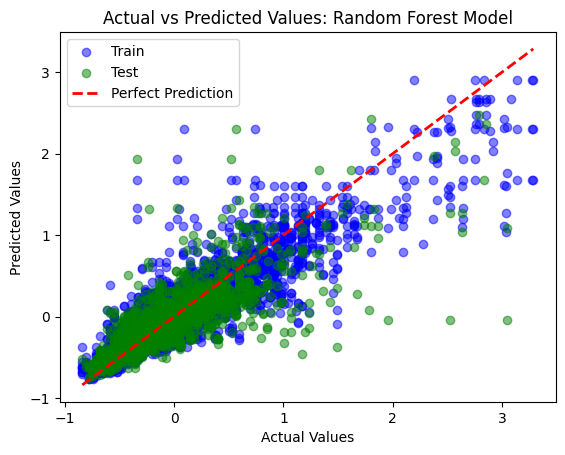

In [95]:
# Plotting the actual vs predicted values for the training data
plt.scatter(y_train, y_rf_train_pred, color='blue', alpha=0.5, label='Train')

# Plotting the actual vs predicted values for the test data
plt.scatter(y_test, y_rf_test_pred, color='green', alpha=0.5, label='Test')

# Plotting the perfect prediction line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, color='red', label='Perfect Prediction')

# Setting labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values: Random Forest Model')

# Adding the legend
plt.legend()

# Displaying the plot
plt.show()

Mean Squared Error: 0.08204259468411323
Root Mean Squared Error: 0.2864307851543078
R2 Score: 0.6417448677313791

Feature ranking:
1. ST_B10 (0.2725046258697646)
2. SR_B5 (0.1342049141832146)
3. SR_B7 (0.11250810917308278)
4. SR_B1 (0.10604739110299918)
5. SR_B6 (0.10134071815114361)
6. SR_B4 (0.09570190575264922)
7. SR_B2 (0.09295786775796108)
8. SR_B3 (0.08473446800918495)


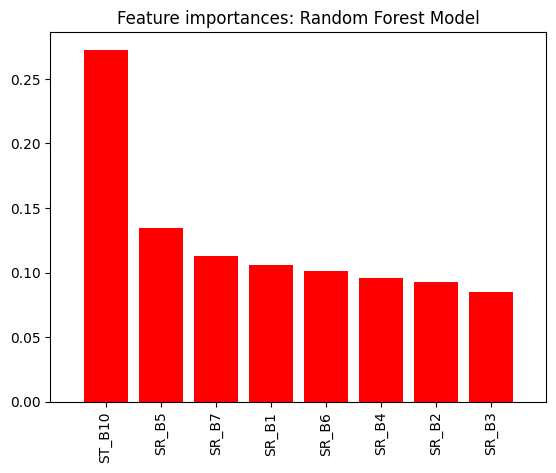

In [96]:
model = best_rf_model

# Predicting the test set results
y_pred = model.predict(x_test)

# Evaluating the performance of the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")

# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("\nFeature ranking:")

for f in range(x.shape[1]):
    print(f"{f+1}. {x.columns[indices[f]]} ({importances[indices[f]]})")

# Plot the feature importances of the forest

plt.figure()
plt.title("Feature importances: Random Forest Model")
plt.bar(range(x.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices], rotation=90)
plt.xlim([-1, x.shape[1]])
plt.show()


# Saving the model

In [ ]:
# joblib.dump(model, 'data/model/RF_model.pkl')

# Loading Model

In [97]:
model = joblib.load('data/model/RF_model.pkl')

In [99]:
df_Landsat = pd.read_csv('data/2021/Landsat.csv')
df_Landsat = df_Landsat.drop('Unnamed: 0', axis=1)
df_Landsat

,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,longitude,latitude,time,ST_B10,system:index
0,-0.000900,0.002592,0.008862,0.002537,0.041752,0.016370,0.009385,-124.599878,47.900102,1.640891e+12,272.745996,279
1,-0.075453,-0.071712,-0.036430,-0.041958,0.233785,0.056493,0.024372,-124.599878,48.000085,1.640891e+12,272.428120,280
2,-0.006703,-0.011322,0.018955,0.013373,0.171745,0.032265,0.019477,-124.599878,48.100067,1.640891e+12,272.397358,281
3,-0.006840,-0.002275,0.020495,0.008725,0.403762,0.070242,0.027150,-124.599878,48.200050,1.640891e+12,271.566779,282
4,-0.004062,-0.007225,0.017250,0.016095,0.271955,0.024867,0.020082,-124.599878,48.300032,1.640891e+12,269.731302,283
...,...,...,...,...,...,...,...,...,...,...,...,...
81688,-0.015420,-0.009975,-0.000322,-0.004832,0.082535,0.019175,0.013758,-67.199957,45.100054,1.640013e+12,268.733241,491
81689,0.299098,0.324838,0.340705,0.371368,0.576600,0.025390,0.049425,-67.099975,44.800106,1.640013e+12,263.343023,748
81690,0.016480,0.020550,-0.143460,-0.172473,0.132365,0.028800,0.037270,-67.099975,45.000071,1.640013e+12,263.325933,750
81691,0.006690,-0.000570,0.025225,0.000090,0.137342,0.006085,0.018295,-66.999992,44.800106,1.640013e+12,264.939238,8


In [100]:
data_for_model = df_Landsat.drop(['time', 'longitude', 'latitude', 'system:index'], axis=1)
data_for_plotting = df_Landsat.drop(['time', 'system:index', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10'], axis=1)

In [101]:
# from scipy import stats

scaler = StandardScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(data_for_model), columns=data_for_model.columns)

df_normalized.to_csv(f'data/normal_finalData.csv')
data_for_model = df_normalized
data_for_plotting = data_for_plotting.loc[data_for_model.index]
data_for_model

,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,ST_B10
0,-0.872629,-0.888461,-0.967539,-1.035178,-1.316331,-1.585069,-1.591649,0.244577
1,-1.054174,-1.070399,-1.089492,-1.156270,-0.693140,-1.306605,-1.467588,0.229100
2,-0.886758,-0.922532,-0.940365,-1.005691,-0.894475,-1.474752,-1.508107,0.227602
3,-0.887093,-0.900379,-0.936218,-1.018339,-0.141523,-1.211176,-1.444597,0.187163
4,-0.880330,-0.912499,-0.944955,-0.998282,-0.569270,-1.526094,-1.503099,0.097796
...,...,...,...,...,...,...,...,...
81688,-0.907987,-0.919233,-0.992270,-1.055236,-1.183982,-1.565601,-1.555455,0.049202
81689,-0.142094,-0.099435,-0.074035,-0.031416,0.419375,-1.522467,-1.260212,-0.213240
81690,-0.830306,-0.844492,-1.377676,-1.511464,-1.022272,-1.498801,-1.360827,-0.214072
81691,-0.854146,-0.896205,-0.923482,-1.041839,-1.006119,-1.656450,-1.517895,-0.135523


In [102]:
predicted_pm10 = model.predict(data_for_model)
data_for_plotting['predicted_pm10'] = predicted_pm10
data_for_plotting

,longitude,latitude,predicted_pm10
0,-124.599878,47.900102,-0.127166
1,-124.599878,48.000085,-0.187361
2,-124.599878,48.100067,-0.254843
3,-124.599878,48.200050,0.174154
4,-124.599878,48.300032,-0.089897
...,...,...,...
81688,-67.199957,45.100054,-0.140142
81689,-67.099975,44.800106,-0.420806
81690,-67.099975,45.000071,-0.244904
81691,-66.999992,44.800106,-0.298308


# Saving the final map of PM10

In [103]:
%%time

# Initialize a map centered around the mean coordinates
m = folium.Map(location=[data_for_plotting['latitude'].mean(), data_for_plotting['longitude'].mean()])

# Create a color map
color_map = branca.colormap.linear.YlOrRd_09.scale(min(predicted_pm10), max(predicted_pm10))

# Add the color map to the map
color_map.add_to(m)

# Add a marker cluster to the map
marker_cluster = MarkerCluster().add_to(m)

# Convert the predicted values into a list
predicted_pm10_list = predicted_pm10.tolist()

# Add the predicted data points to the map
data_for_plotting = data_for_plotting.reset_index(drop=True)
for index, row in data_for_plotting.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,  # adjust size as needed
        color=color_map(predicted_pm10_list[index]),  # use the color map to get the color
        fill=True,
        fill_color=color_map(predicted_pm10_list[index]),  # use the color map to get the color
        fill_opacity=0.6,
        popup=f'Predicted PM10: {predicted_pm10_list[index]}',
    ).add_to(m)

    
# Save it to a file
m.save('data/final_maps/predicted_pm10_map_2021.html')

CPU times: total: 1min 48s
Wall time: 1min 50s


In [104]:
%%time

# Initialize a map centered around the mean coordinates
m = folium.Map(location=[38.9072, -77.0369], zoom_start=13)

# Create a color map
color_map = branca.colormap.linear.YlOrRd_09.scale(min(predicted_pm10), max(predicted_pm10))

# Add the color map to the map
color_map.add_to(m)

# Convert the predicted values into a list
predicted_pm10_list = predicted_pm10.tolist()

city = ox.geocode_to_gdf('Fresno, California, USA')

# Fetch points of interest within the city
pois = ox.geometries_from_polygon(city.geometry[0], tags={'industrial':True, 'mine':True})
    
# Convert city boundaries to GeoJson and add to map
folium.GeoJson(city.geometry[0]).add_to(m)

# Initialize a marker cluster for factories
factories = MarkerCluster().add_to(m)

# Add factories to map
for _, poi in pois.iterrows():
    if isinstance(poi.geometry, Point):
        folium.Marker([poi.geometry.y, poi.geometry.x], popup=poi.name).add_to(factories)
    else:  # assuming the geometry is a Polygon
        centroid = poi.geometry.centroid
        folium.Marker([centroid.y, centroid.x], popup=poi.name).add_to(factories)
        
# Add the predicted data points to the map
data_for_plotting = data_for_plotting.reset_index(drop=True)
for index, row in data_for_plotting.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,  # adjust size as needed
        color=color_map(predicted_pm10_list[index]),  # use the color map to get the color
        fill=True,
        fill_color=color_map(predicted_pm10_list[index]),  # use the color map to get the color
        fill_opacity=0.6,
        popup=f'Predicted PM10: {predicted_pm10_list[index]}',
    ).add_to(m)

# Fetch the boundary of San Francisco

        
# Save it to a file
m.save('data/final_maps/Fresno_pm10_factories.html')

CPU times: total: 1min 52s
Wall time: 2min 1s
